In [7]:
# ----------------------------------------------------------
# Import Libraries
# ----------------------------------------------------------

import sys
from pathlib import Path
import configparser
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# File Paths
# -----------------------------
current_dir = Path.cwd()
# If running from 6-ResultsAnalysis, top_dir is parent; else current
top_dir = current_dir.parent if current_dir.name == '6-ResultAnalysis' else current_dir

libs_dir = str(top_dir / "0-Libs")
config_dir = top_dir / "0-Config"

data_dir = top_dir / "0-Data"
super_dir        = str(data_dir / "00-SuperRes")
highres_dir      = str(data_dir / "0-HighRes")
routine_dir      = str(data_dir / "1-Routine")
active_dir       = str(data_dir / "2-Active")
long_active_dir  = str(data_dir / "3-LongActive")
long_routine_dir = str(data_dir / "4-LongRoutine")

sys.path.append(libs_dir)

print("Libraries Imported, paths set.")

# -----------------------------
# Config
# -----------------------------
config = configparser.ConfigParser()
config.read(config_dir / "config.ini")
seed = int(config['OVERALL']['seed'])
np.random.seed(seed)



Libraries Imported, paths set.


In [8]:
# -----------------------------
# Helpers
# -----------------------------
def load_csv_or_none(path: Path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def compute_true_effluent_from_super(top_dir: Path, config: configparser.ConfigParser):
    """
    Recompute true effluent for superres data,
    """
    from asm3_model import ode_system_wrapper
    from plant_config import get_reactor_initial_values
    from scipy.integrate import solve_ivp

    super_states = pd.read_csv(top_dir / "0-Data/00-SuperRes/Super_Influent_States.csv")
    t_eval = super_states['Time'].to_numpy(dtype=float)
    influent_np = super_states.to_numpy(dtype=float)

    # theta_true from config (same keys as in DataGen)
    keys = [
        'true_param_k_H','true_param_K_X','true_param_small_k_STO','true_param_eta_NOX',
        'true_param_K_O2','true_param_K_NOX','true_param_K_S','true_param_big_K_STO',
        'true_param_mu_H','true_param_K_NH4','true_param_K_ALK','true_param_b_H_O2',
        'true_param_b_H_NOX','true_param_b_STO_O2','true_param_b_STO_NOX','true_param_mu_A',
        'true_param_K_A_NH4','true_param_K_A_O2','true_param_K_A_ALK','true_param_b_A_O2',
        'true_param_b_A_NOX','true_param_f_S_I','true_param_Y_STO_O2','true_param_Y_STO_NOX',
        'true_param_Y_H_O2','true_param_Y_H_NOX','true_param_Y_A','true_param_f_X_I',
        'true_param_i_N_S_I','true_param_i_N_S_S','true_param_i_N_X_I','true_param_i_N_X_S',
        'true_param_i_N_BM','true_param_i_SS_X_I','true_param_i_SS_X_S','true_param_i_SS_BM'
    ]
    theta_true_array = np.array([float(config['TRUEPARAMS'][k]) for k in keys], dtype=float)

    r1_V = float(config['REACTOR']['r1_V'])
    y0 = get_reactor_initial_values(top_dir)
    reactor_volumes = [r1_V]

    # Build ODE wrapper
    ode_fun = lambda t, y: ode_system_wrapper(t, y, theta_true_array, influent_np, reactor_volumes)

    t_span = (float(t_eval[0]), float(t_eval[-1]))
    sol = solve_ivp(fun=ode_fun, t_span=t_span, y0=y0, t_eval=t_eval, method='RK45')

    Qout = influent_np[:,1]
    effluent_states_true = np.column_stack([sol.t, Qout, sol.y.T])
    effluent_states_true_df = pd.DataFrame(
        effluent_states_true,
        columns=['Time','Flowrate','S_O2','S_I','S_S','S_NH4','S_N2','S_NOX','S_ALK','X_I','X_S','X_H','X_STO','X_A','X_SS']
    )

    # Build compounds from states (same mapping as DataGen)
    def compounds_from_states(df_states: pd.DataFrame):
        COD = df_states['S_I'] + df_states['S_S'] + df_states['X_I'] + df_states['X_S'] + df_states['X_STO'] + df_states['X_H'] + df_states['X_A']
        NH4 = df_states['S_NH4']
        NOX = df_states['S_NOX']
        TKN = df_states['S_NH4'] + df_states['S_N2']
        ALK = df_states['S_ALK']
        TSS = df_states['X_SS']
        return pd.DataFrame({
            'Time': df_states['Time'],
            'Flowrate': df_states['Flowrate'],
            'COD': COD, 'NH4+NH3': NH4, 'NO3+NO2': NOX, 'TKN': TKN, 'Alkalinity': ALK, 'TSS': TSS
        })

    effluent_compounds_true_df = compounds_from_states(effluent_states_true_df)
    return effluent_states_true_df, effluent_compounds_true_df

def plot_series(x, y, label, ylabel, title, xlim=None, ylim=None):
    plt.figure(figsize=(20, 8))
    plt.plot(x, y, linestyle='None', marker='o', markersize=4, label=label)  # points only
    plt.xlabel('Time (days)')
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_all_group(datasets_dict, group_name, effluent_true_df=None):
    """
    datasets_dict: mapping name->DataFrame (all same schema for the group)
    group_name: 'influent_states' | 'effluent_states' | 'influent_compounds' | 'effluent_compounds'
    effluent_true_df: DataFrame with true effluent (states or compounds) to overlay when group_name is effluent_*
    """
    df0 = next(iter(datasets_dict.values()))
    all_cols = list(df0.columns)
    exclude = ['Time']
    y_cols = [c for c in all_cols if c not in exclude]
    fontsize=24

    for name, df in datasets_dict.items():
        for col in y_cols:
            # units
            if group_name.endswith('states'):
                unit = '(mg/L)' if col.startswith(('S_', 'X_')) and col != 'Flowrate' else ('(m³/day)' if col=='Flowrate' else '')
                ylabel = f"{col} {unit}".strip()
            else:
                if col in ['COD','NH4+NH3','NO3+NO2','TKN','Alkalinity','TSS']:
                    ylabel = f"{col} (mg/L)"
                elif col == 'Flowrate':
                    ylabel = "Flowrate (m³/day)"
                else:
                    ylabel = col

            title = f"{group_name.replace('_',' ').title()} – {name} – {col}"

            # one figure per dataset-variable
            fig, ax = plt.subplots(figsize=(20, 8))
            ax.plot(df['Time'], df[col], linestyle='None', marker='o', markersize=4, label=name)  # points only

            # Overlay True effluent as a BLACK LINE (if applicable)
            if group_name.startswith('effluent') and effluent_true_df is not None and col in effluent_true_df.columns:
                t_true = effluent_true_df['Time']
                y_true = effluent_true_df[col]
                tmin, tmax = df['Time'].min(), df['Time'].max()
                mask = (t_true >= tmin) & (t_true <= tmax)
                ax.plot(t_true[mask], y_true[mask], '-', linewidth=2, color='black', label='True (Super, no noise)')
            
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            ax.set_xlabel('Time (days)', fontsize=fontsize)
            ax.set_ylabel(ylabel, fontsize=fontsize)
            # ax.set_title(title, fontsize=fontsize)
            # ax.legend(fontsize=fontsize, frameon=False)
            ax.grid(False)
            plt.tight_layout()
            plt.show()


def build_loadings_df(compounds_df: pd.DataFrame) -> pd.DataFrame:
    fl = compounds_df['Flowrate']
    return pd.DataFrame({
        'Time': compounds_df['Time'],
        'COD': compounds_df['COD'] * fl / 1000.0,
        'NH4+NH3': compounds_df['NH4+NH3'] * fl / 1000.0,
        'NO3+NO2': compounds_df['NO3+NO2'] * fl / 1000.0,
        'TKN': compounds_df['TKN'] * fl / 1000.0,
        'Alkalinity': compounds_df['Alkalinity'] * fl / 1000.0,
        'TSS': compounds_df['TSS'] * fl / 1000.0
    })


def plot_all_loadings(datasets_compounds_dict, label_prefix):
    fontsize=24
    keys = ['COD','NH4+NH3','NO3+NO2','TKN','Alkalinity','TSS']
    for name, dfc in datasets_compounds_dict.items():
        loads = build_loadings_df(dfc)
        for k in keys:
            plt.figure(figsize=(20, 8))
            plt.plot(loads['Time'], loads[k], linestyle='None', marker='o', markersize=4,
                     label=f'{label_prefix} {name}')  # points only
            plt.xlabel('Time (days)', fontsize=fontsize)
            plt.ylabel(f'{k} loading (kg/day)', fontsize=fontsize)
            plt.title(f'{label_prefix} {name} – {k} Loading', fontsize=fontsize)
            plt.legend(fontsize=fontsize)
            plt.tight_layout()
            plt.show()

In [9]:
# -----------------------------
# Load ALL datasets (incl. SuperRes)
# -----------------------------
data = {
    'HighRes': {
        'influent_states':   load_csv_or_none(Path(highres_dir) / "HighRes_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(highres_dir) / "HighRes_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(highres_dir) / "HighRes_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(highres_dir) / "HighRes_Effluent_Compounds.csv"),
    },
    'Routine': {
        'influent_states':   load_csv_or_none(Path(routine_dir) / "Routine_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(routine_dir) / "Routine_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(routine_dir) / "Routine_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(routine_dir) / "Routine_Effluent_Compounds.csv"),
    },
    'Active': {
        'influent_states':   load_csv_or_none(Path(active_dir) / "Active_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(active_dir) / "Active_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(active_dir) / "Active_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(active_dir) / "Active_Effluent_Compounds.csv"),
    },
    'LongActive': {
        'influent_states':   load_csv_or_none(Path(long_active_dir) / "LongActive_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(long_active_dir) / "LongActive_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(long_active_dir) / "LongActive_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(long_active_dir) / "LongActive_Effluent_Compounds.csv"),
    },
    'LongRoutine': {
        'influent_states':   load_csv_or_none(Path(long_routine_dir) / "LongRoutine_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(long_routine_dir) / "LongRoutine_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(long_routine_dir) / "LongRoutine_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(long_routine_dir) / "LongRoutine_Effluent_Compounds.csv"),
    },
    'SuperRes': {
        'influent_states':   load_csv_or_none(Path(super_dir) / "Super_Influent_States.csv"),
        'effluent_states':   load_csv_or_none(Path(super_dir) / "Super_Effluent_States.csv"),
        'influent_compounds':load_csv_or_none(Path(super_dir) / "Super_Influent_Compounds.csv"),
        'effluent_compounds':load_csv_or_none(Path(super_dir) / "Super_Effluent_Compounds.csv"),
    }
}

print("Data loaded.")

Data loaded.


In [10]:
# -----------------------------
# True Effluent (non-corrupted) for overlay
# -----------------------------

effluent_true_states, effluent_true_compounds = compute_true_effluent_from_super(top_dir, config)


In [11]:
# -----------------------------
# GROUP: Influents (States & Compounds)
# -----------------------------
influent_states_datasets = {k: v['influent_states'] for k, v in data.items() if v['influent_states'] is not None}
influent_compounds_datasets = {k: v['influent_compounds'] for k, v in data.items() if v['influent_compounds'] is not None}

# print("Plotting ALL Influent States...")
# plot_all_group(influent_states_datasets, 'influent_states', effluent_true_df=None)

# print("Plotting ALL Influent Compounds...")
# plot_all_group(influent_compounds_datasets, 'influent_compounds', effluent_true_df=None)

# print("Plotting ALL Influent Loadings (kg/day)...")
# plot_all_loadings(influent_compounds_datasets, label_prefix="Influent")


--------------------------------------------------
Plotting ALL Effluent Compounds (with True overlay if available)...
--------------------------------------------------


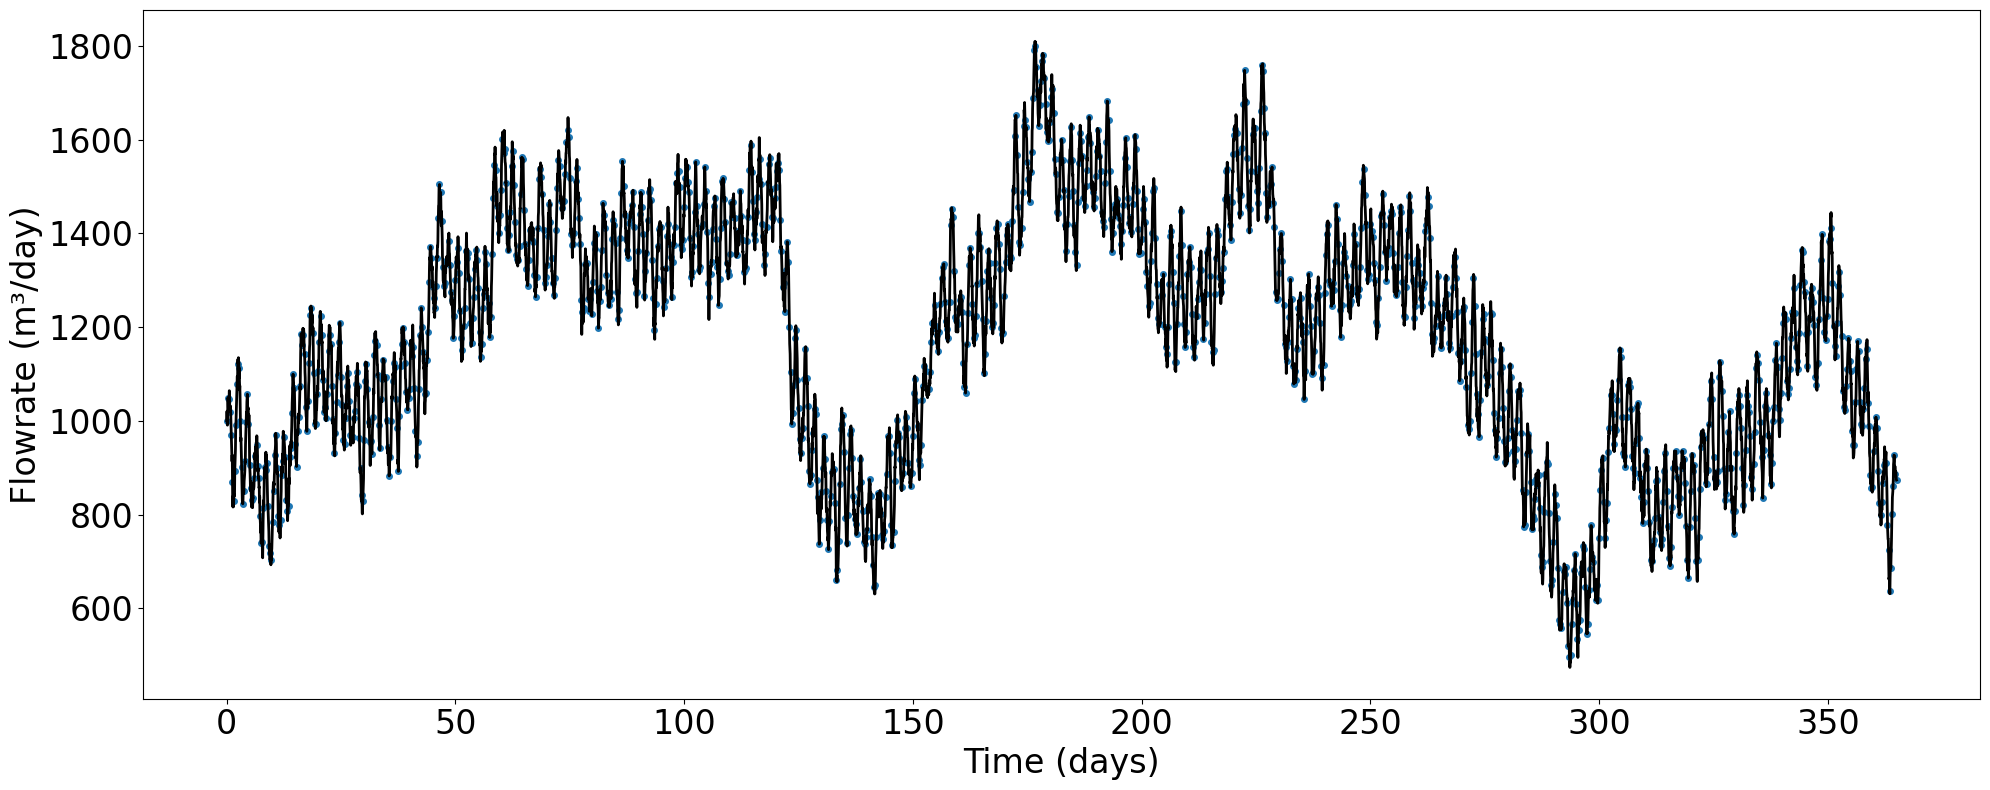

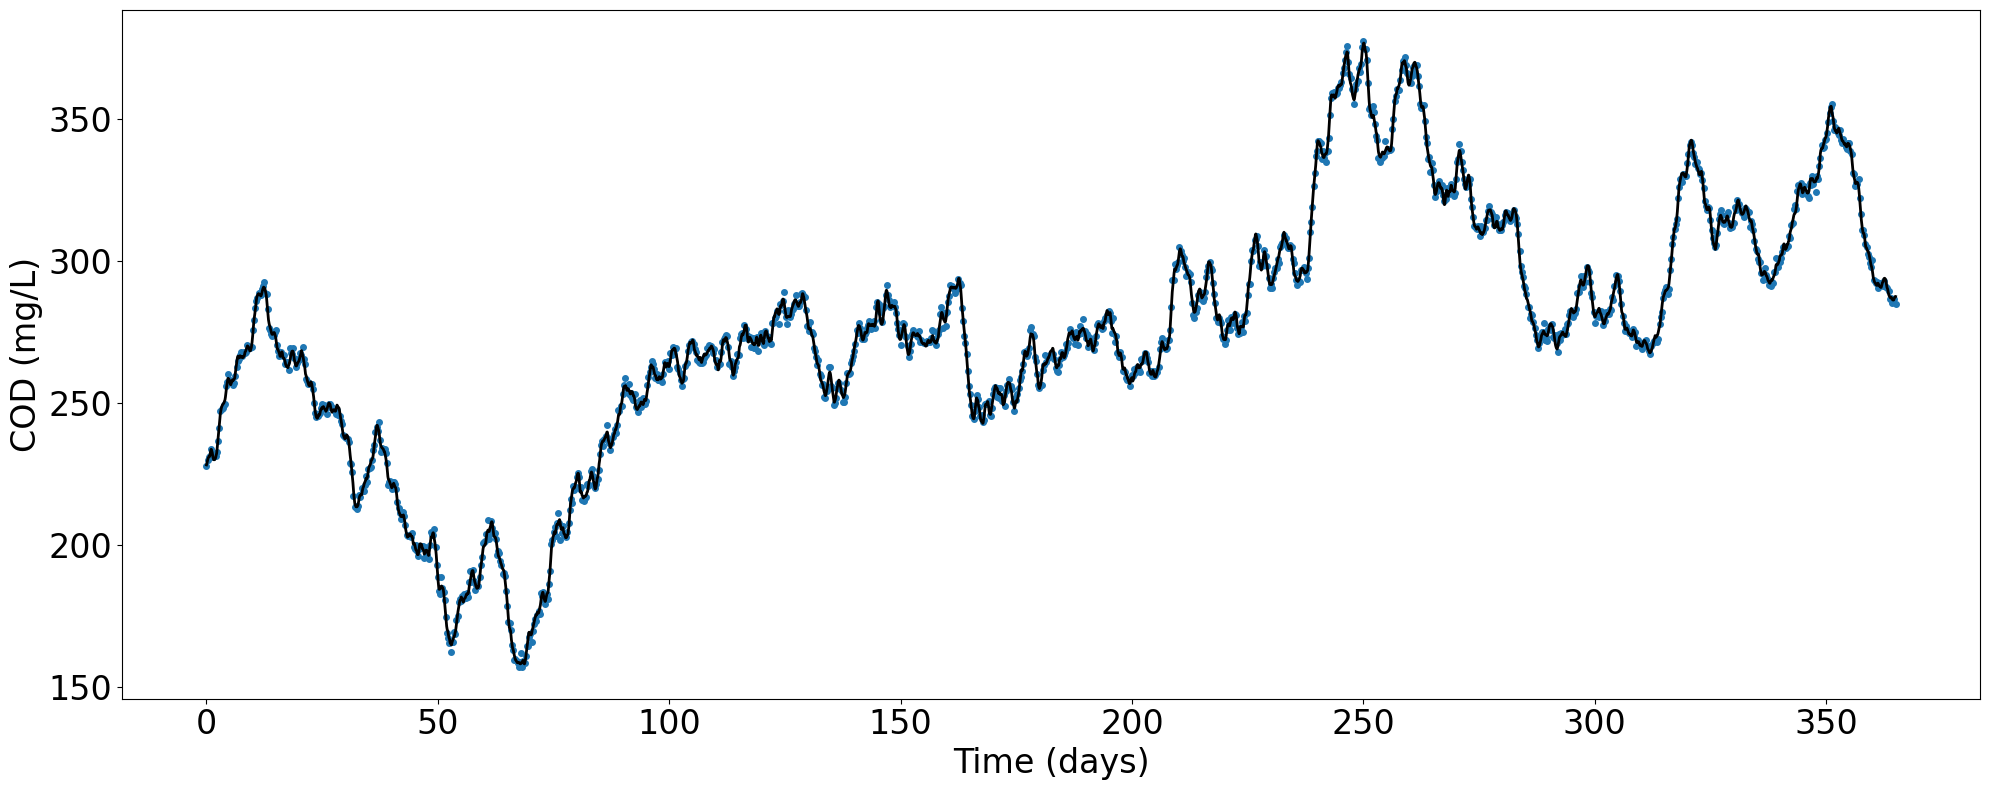

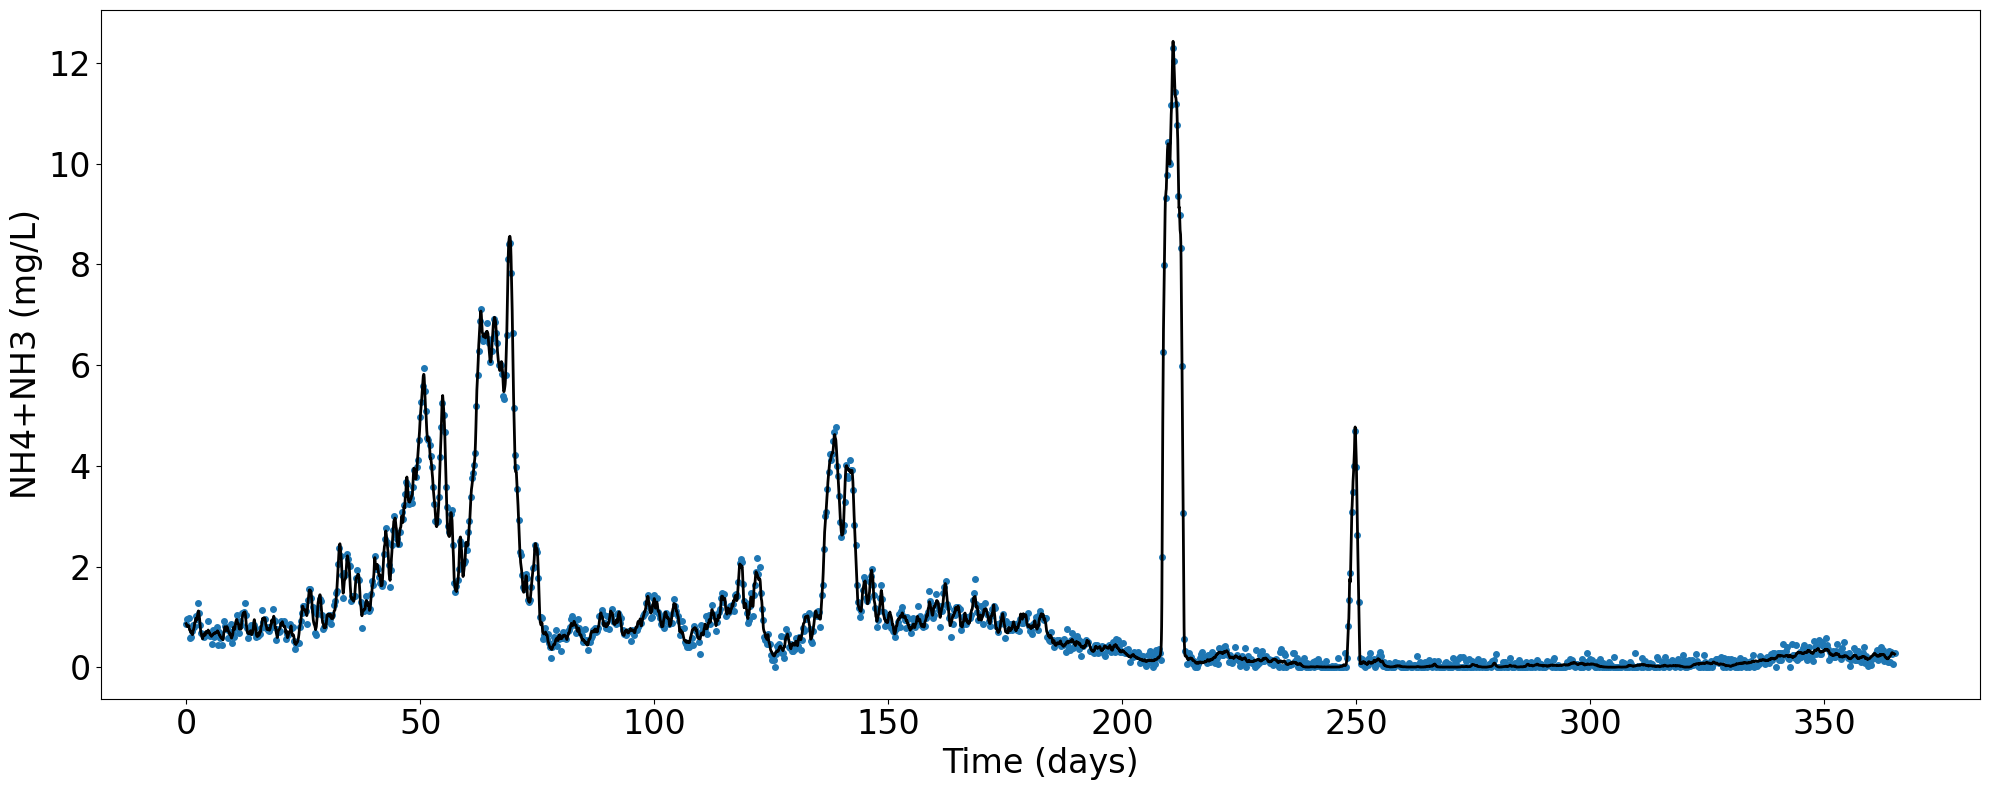

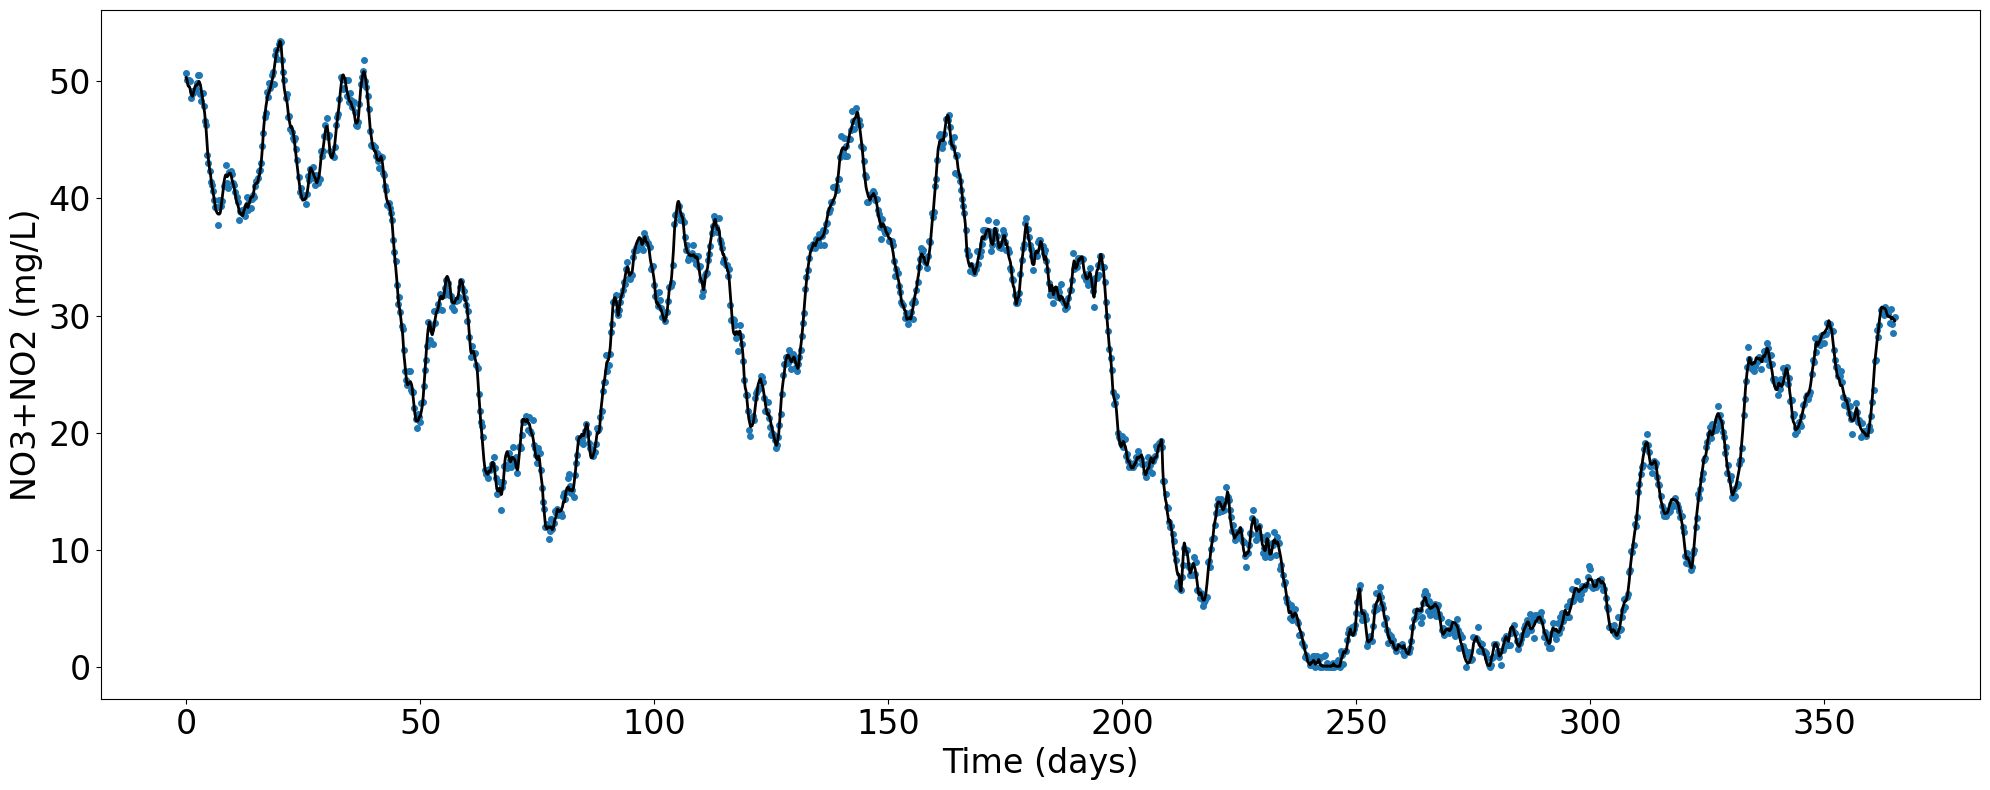

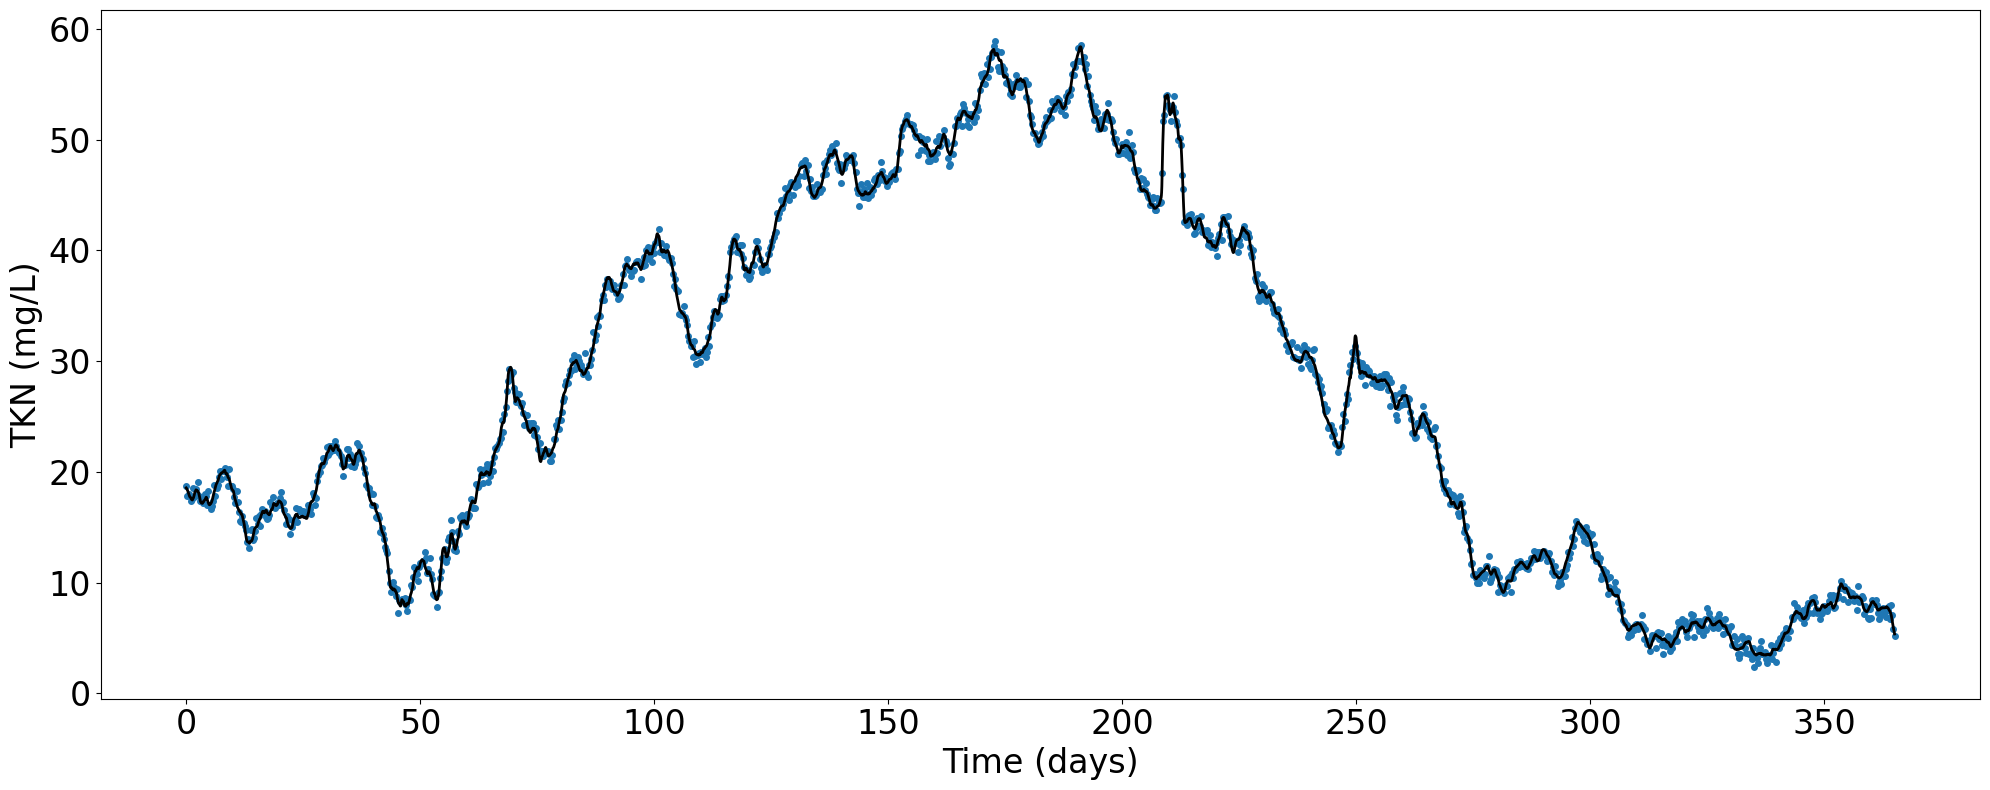

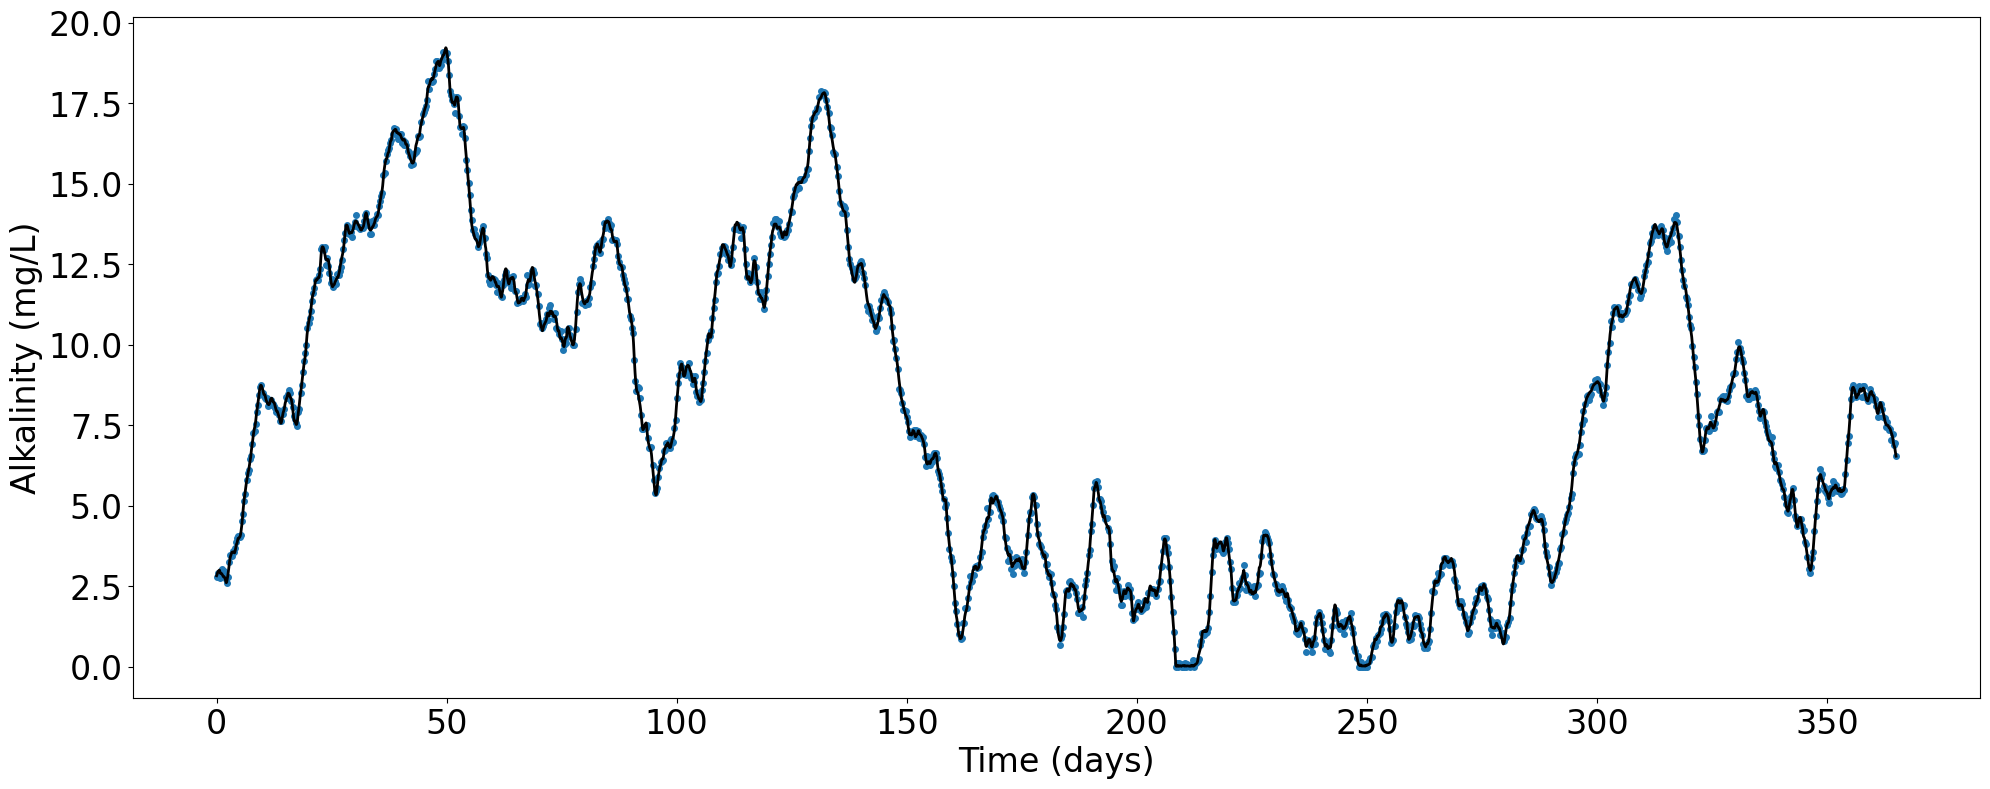

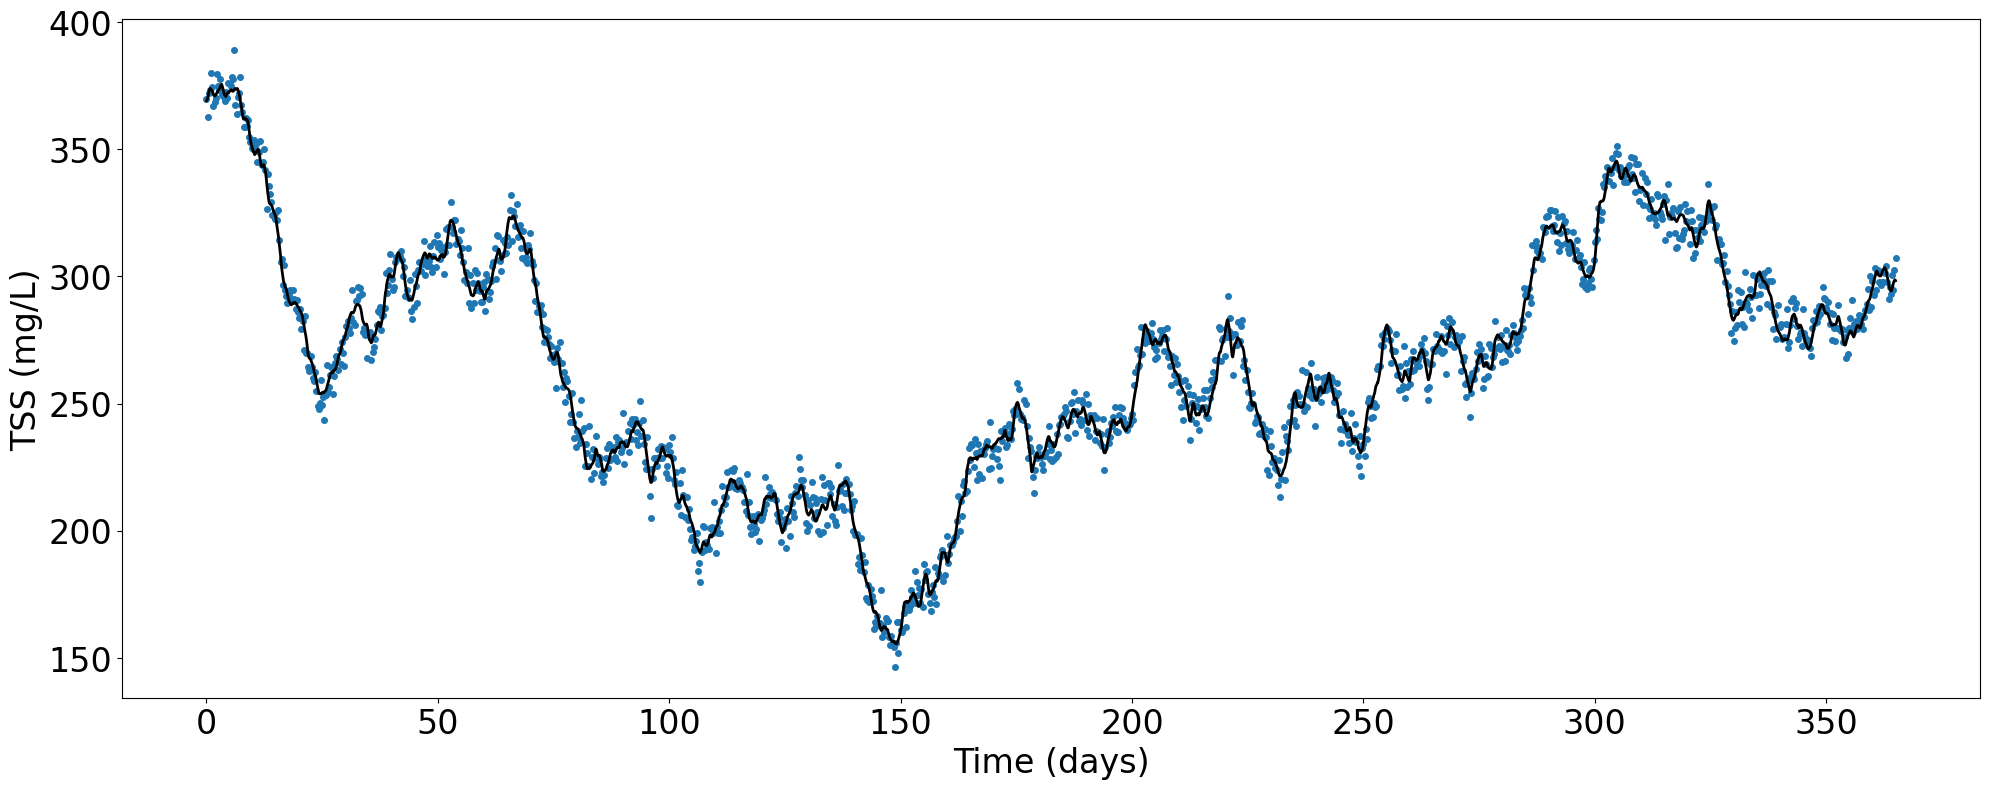

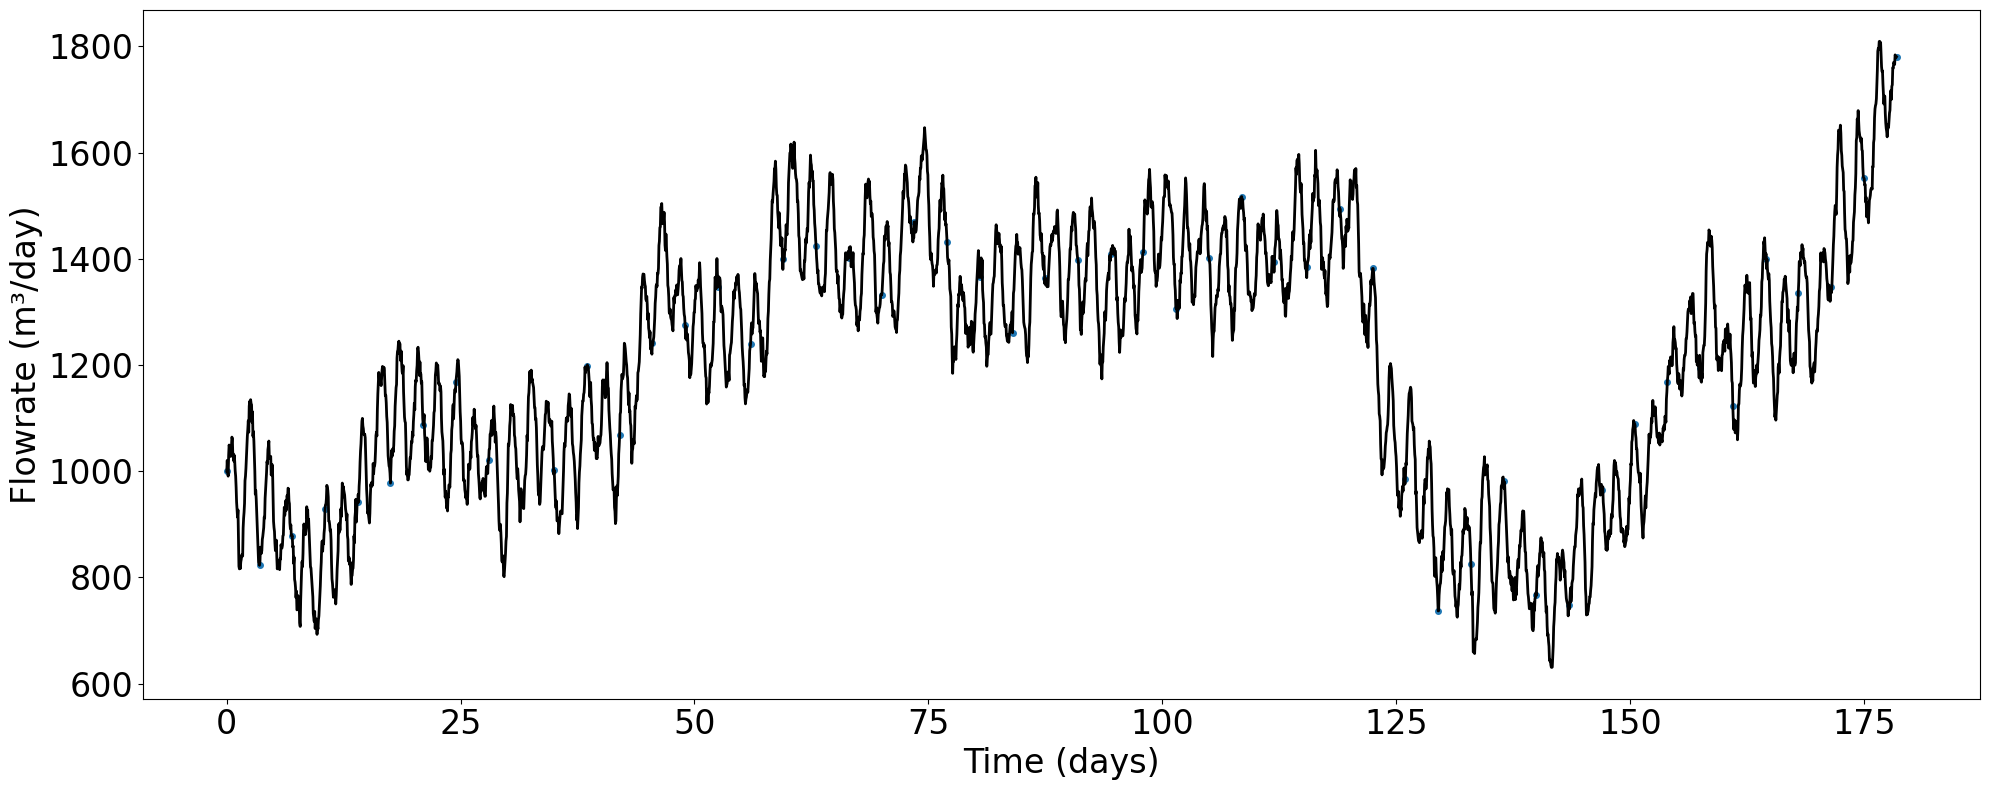

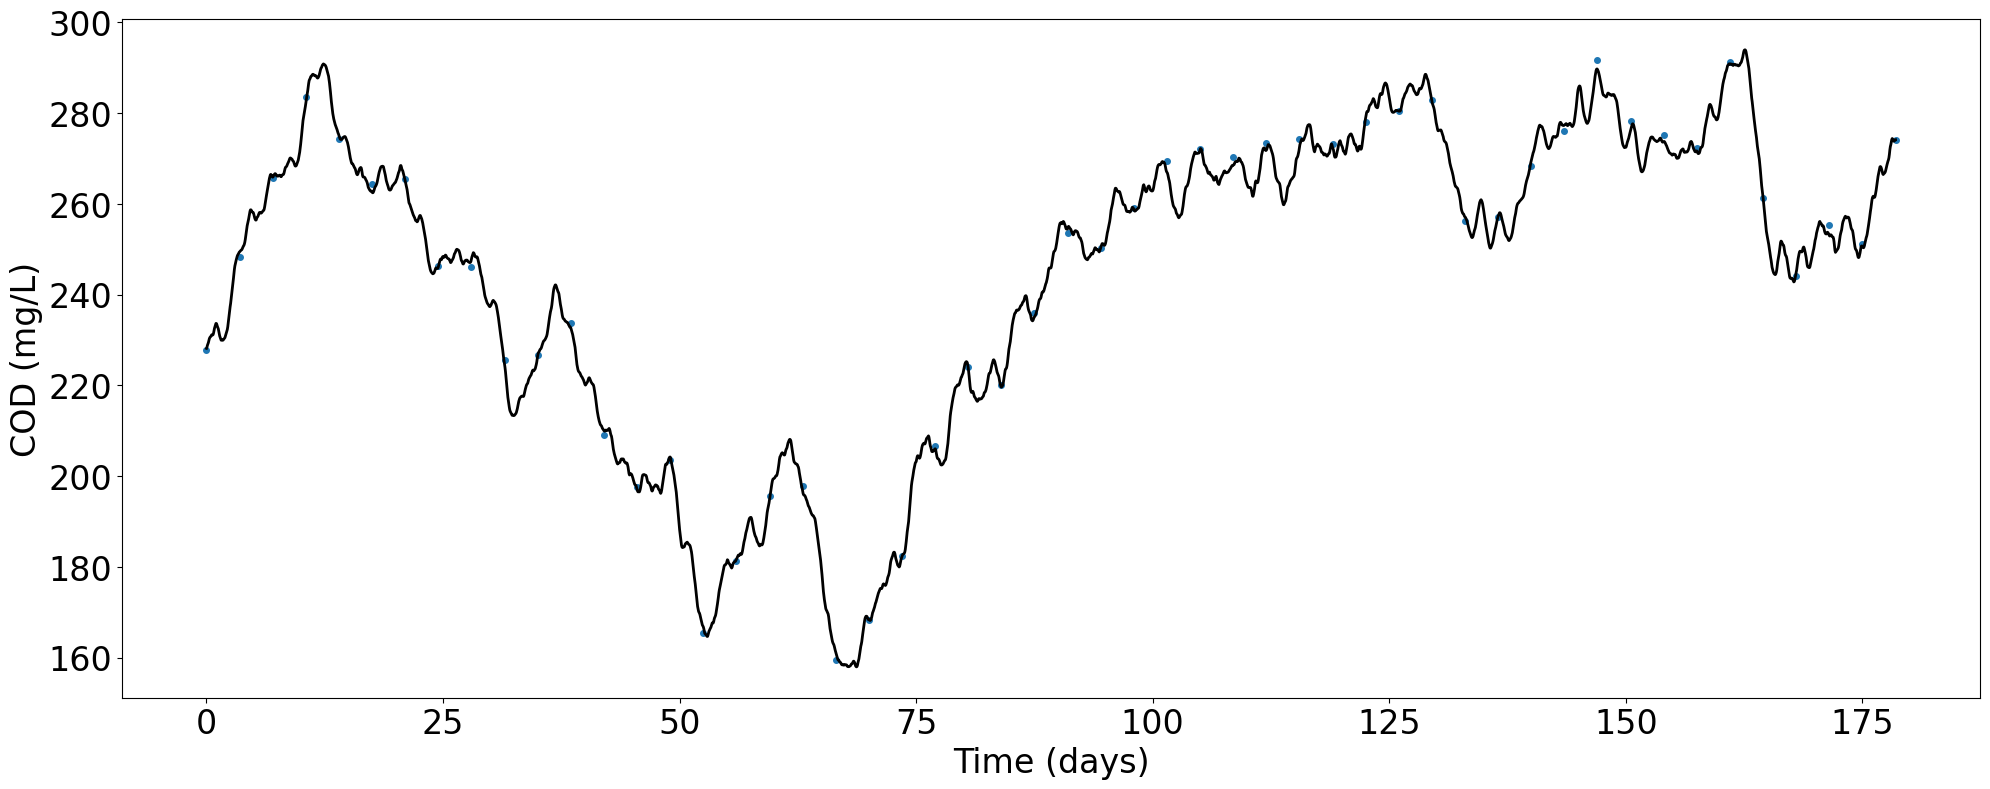

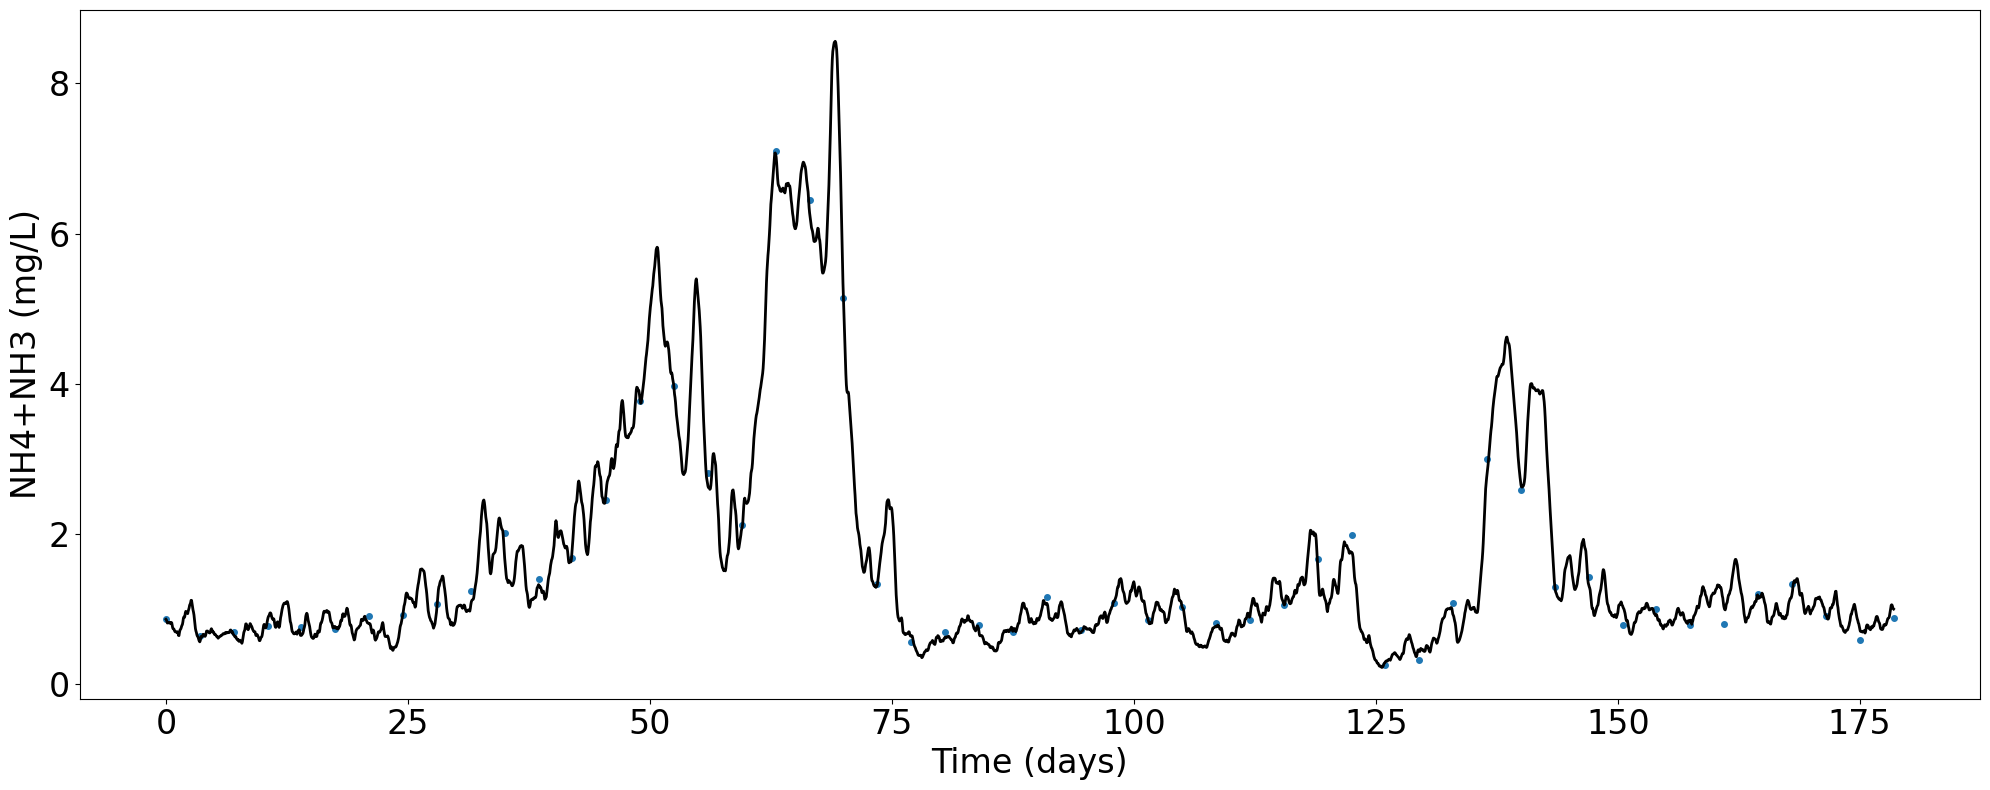

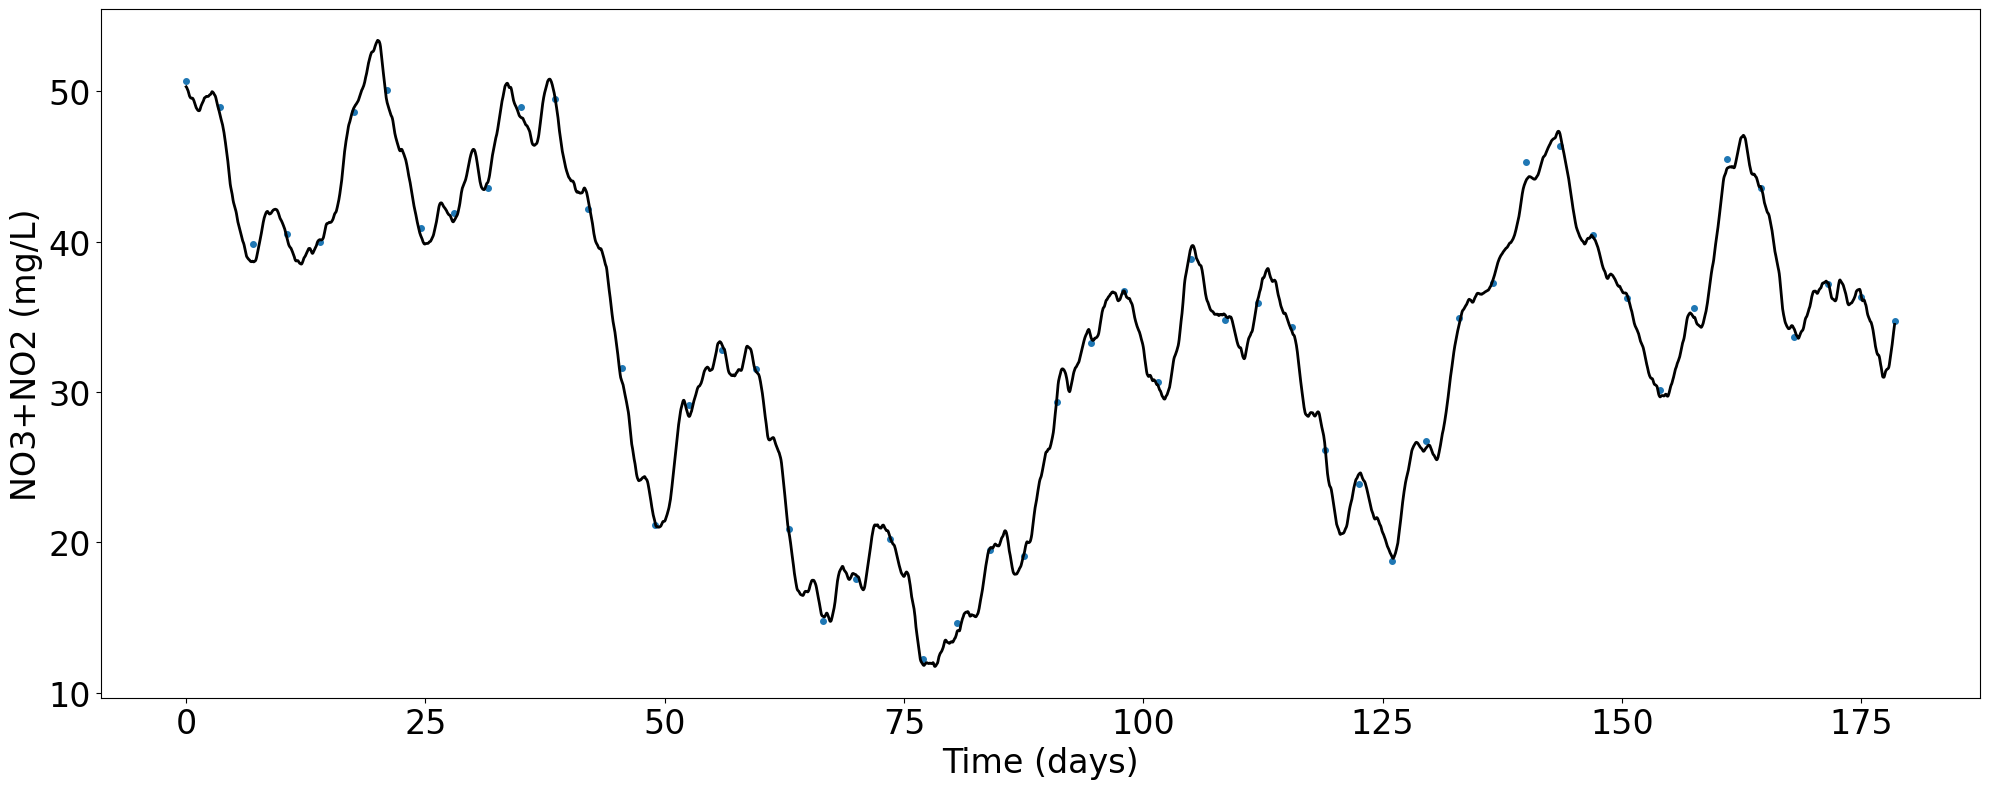

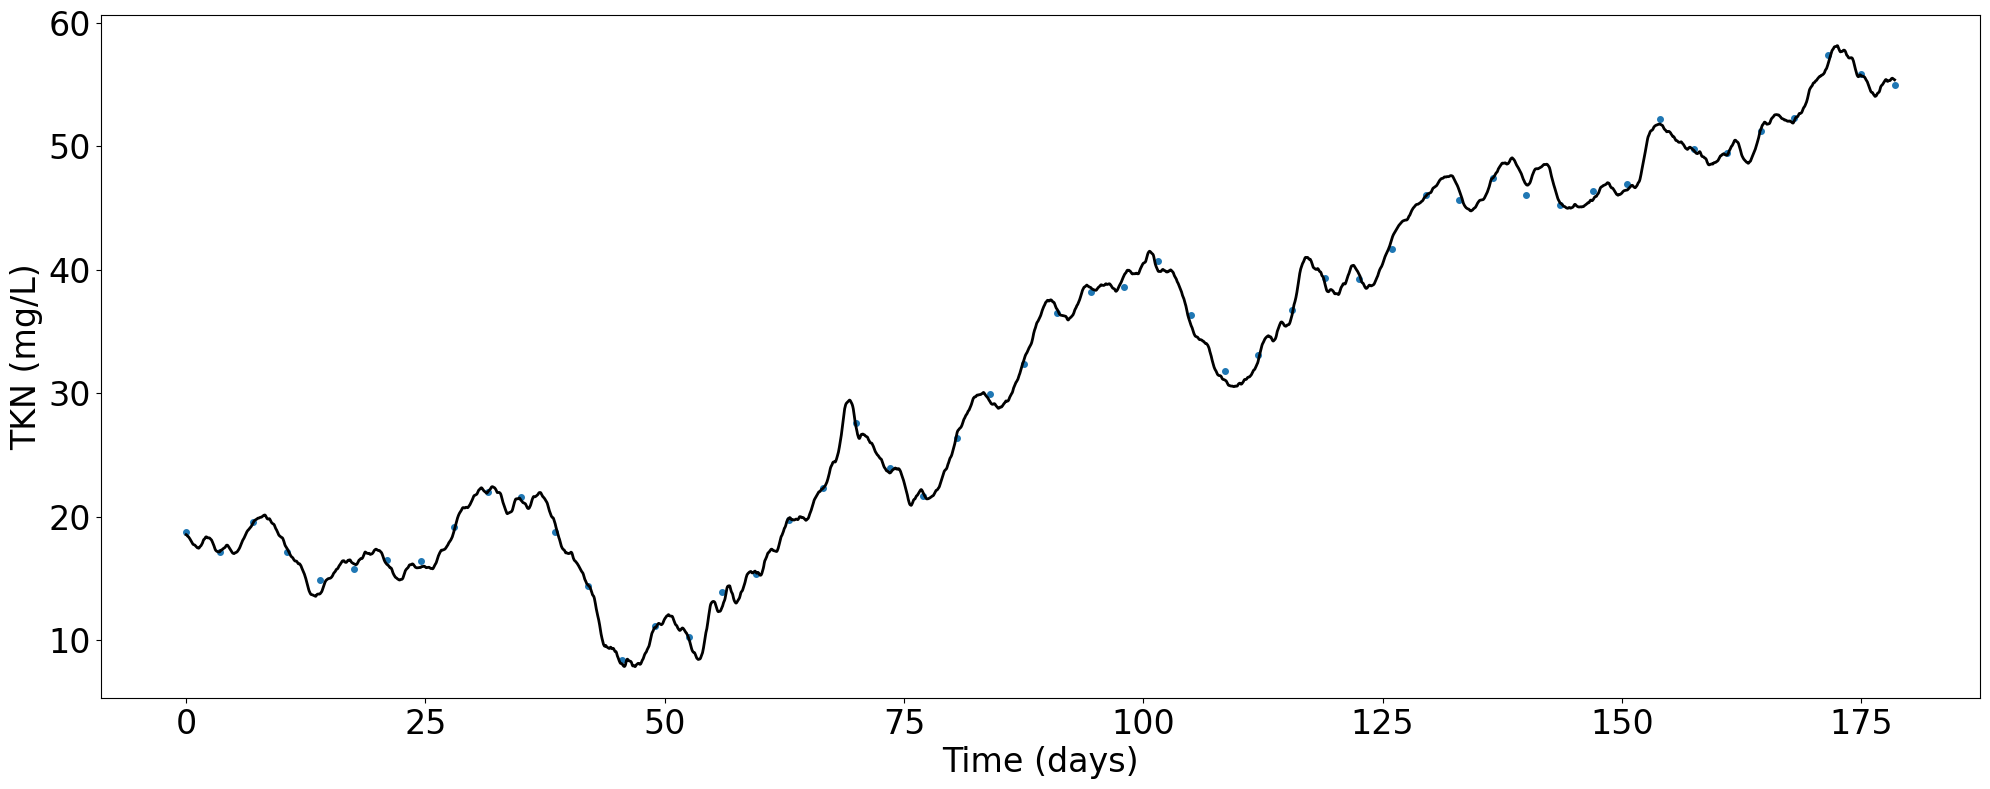

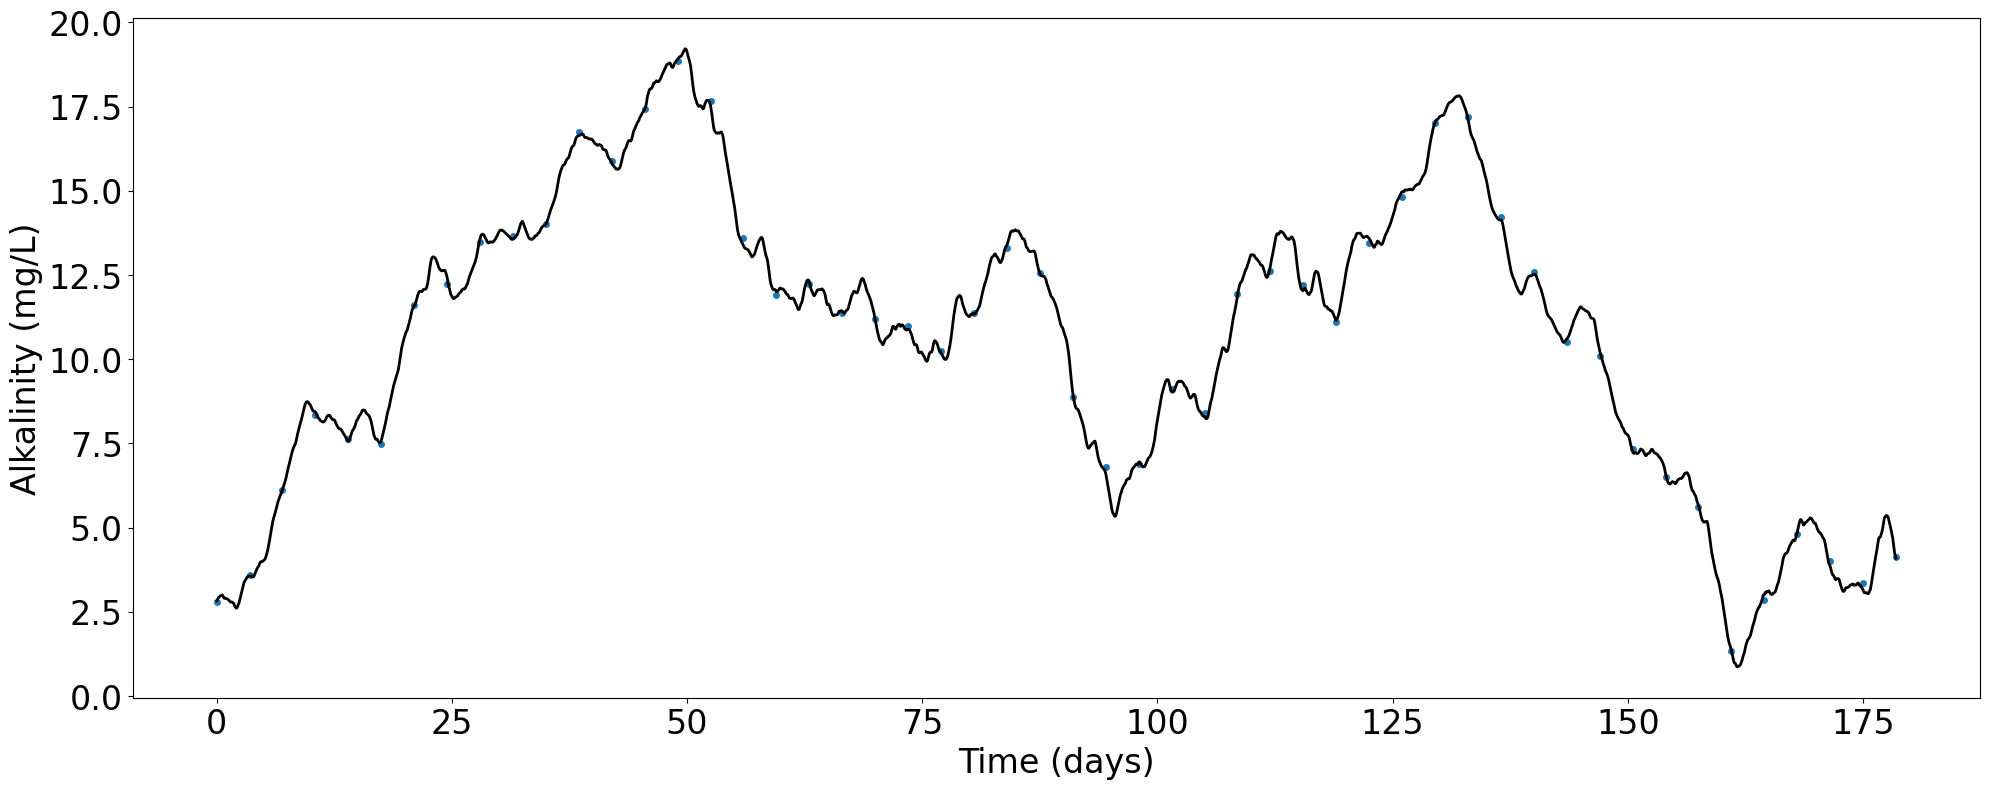

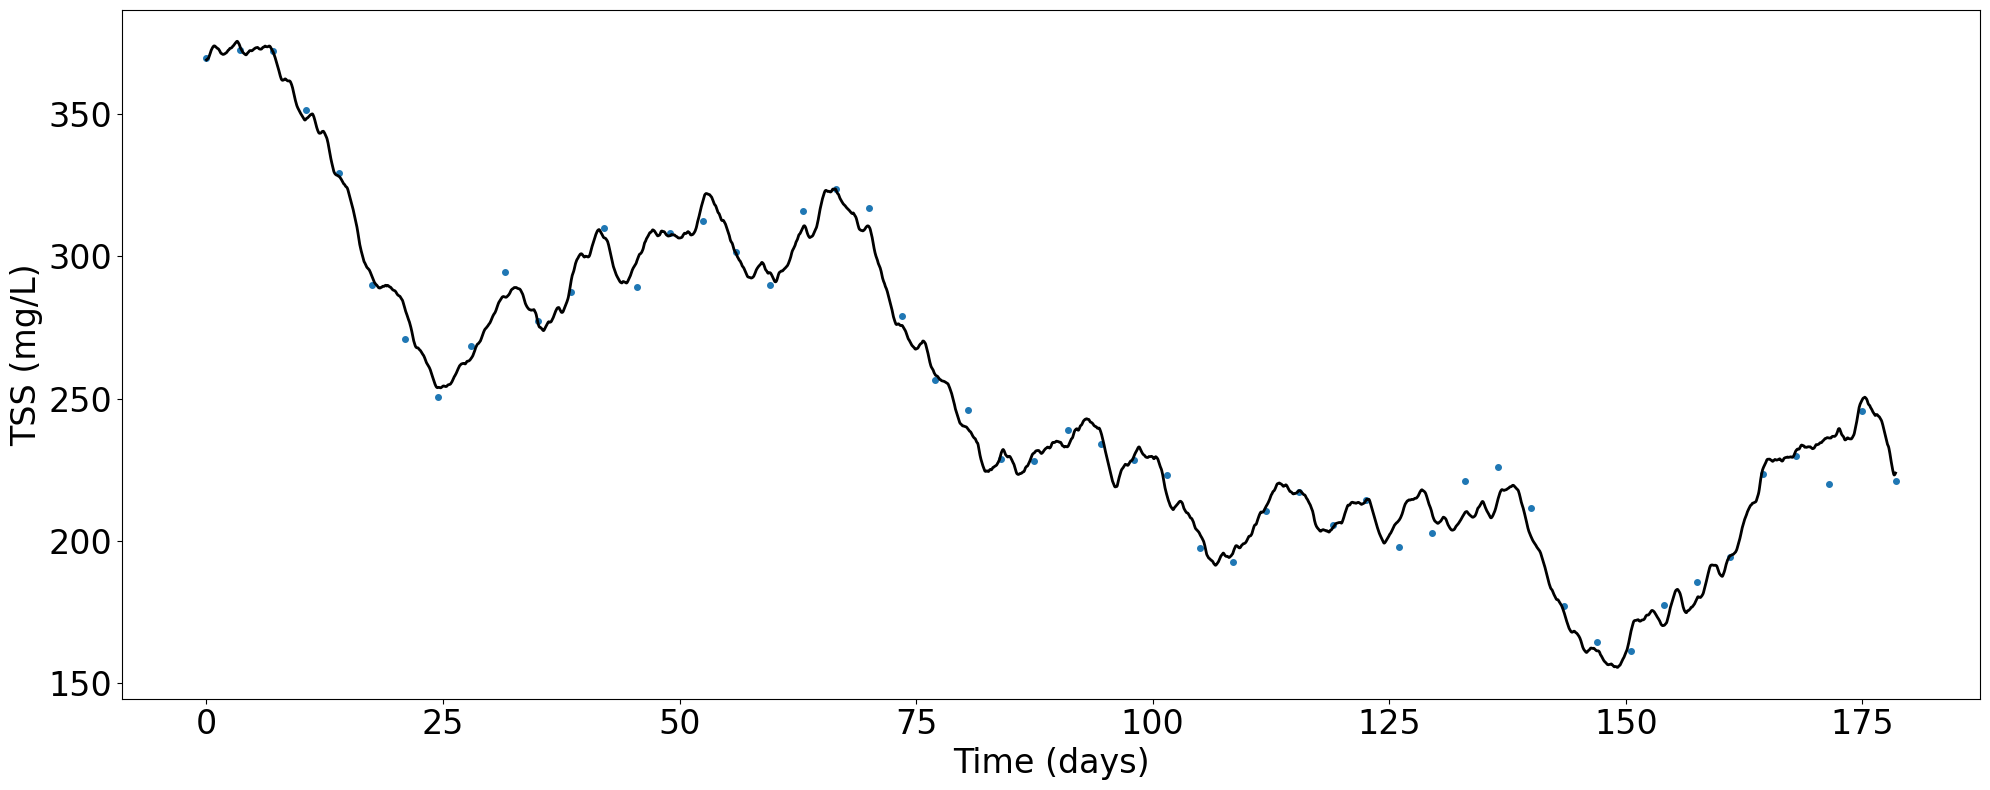

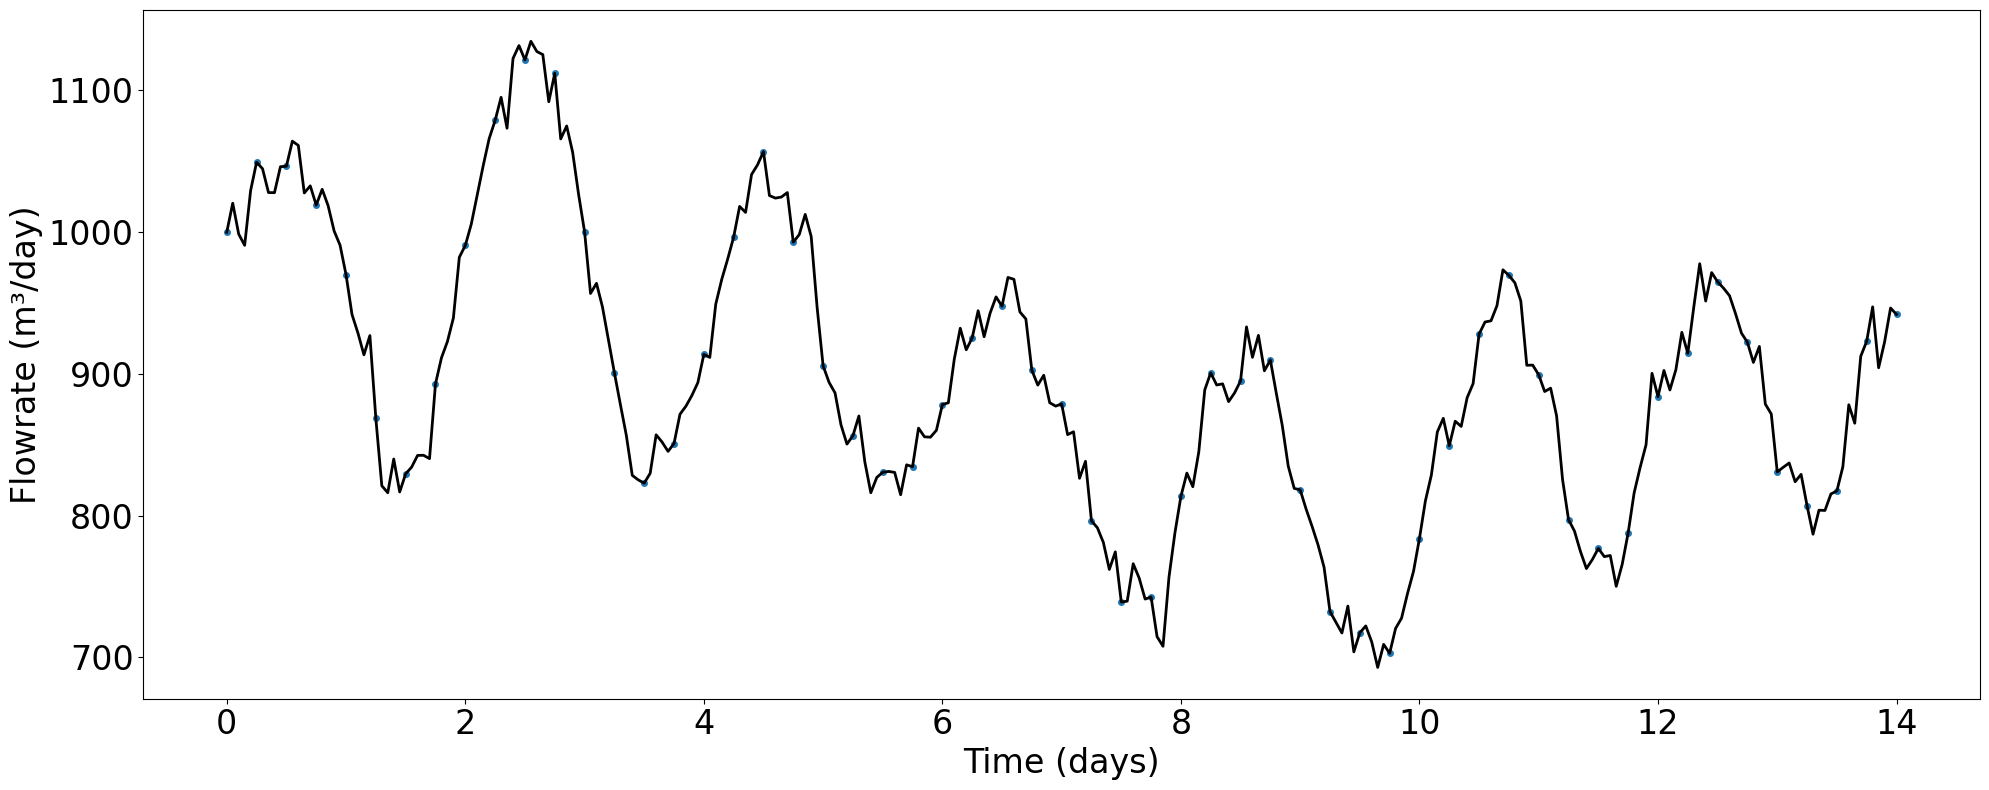

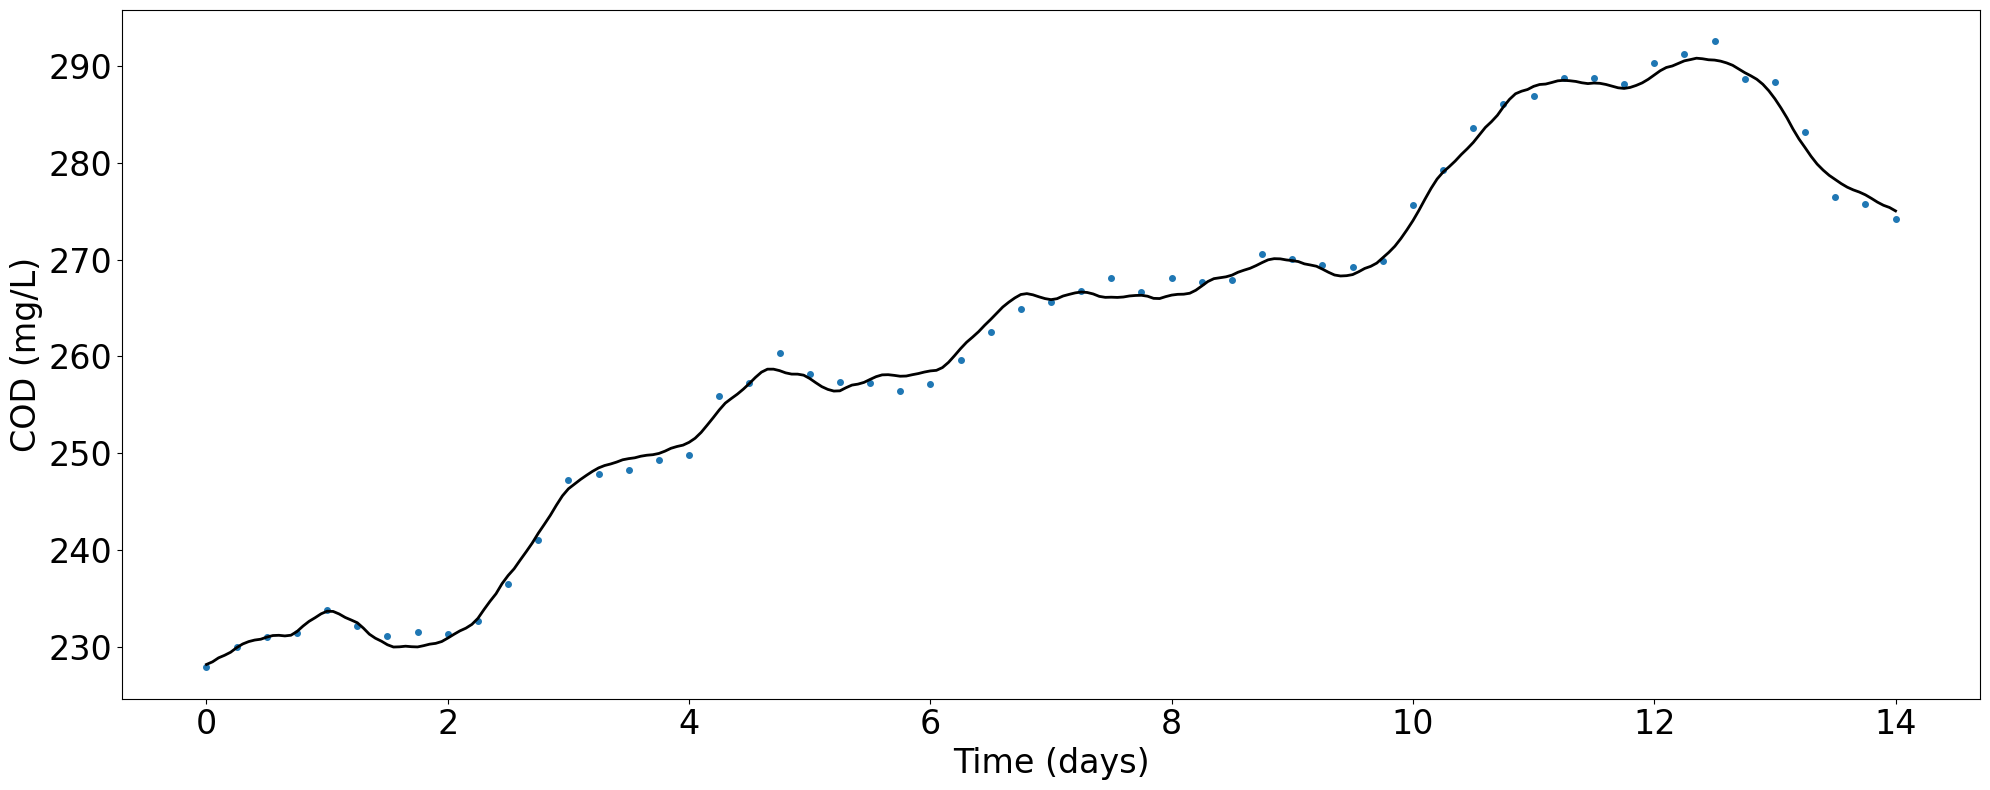

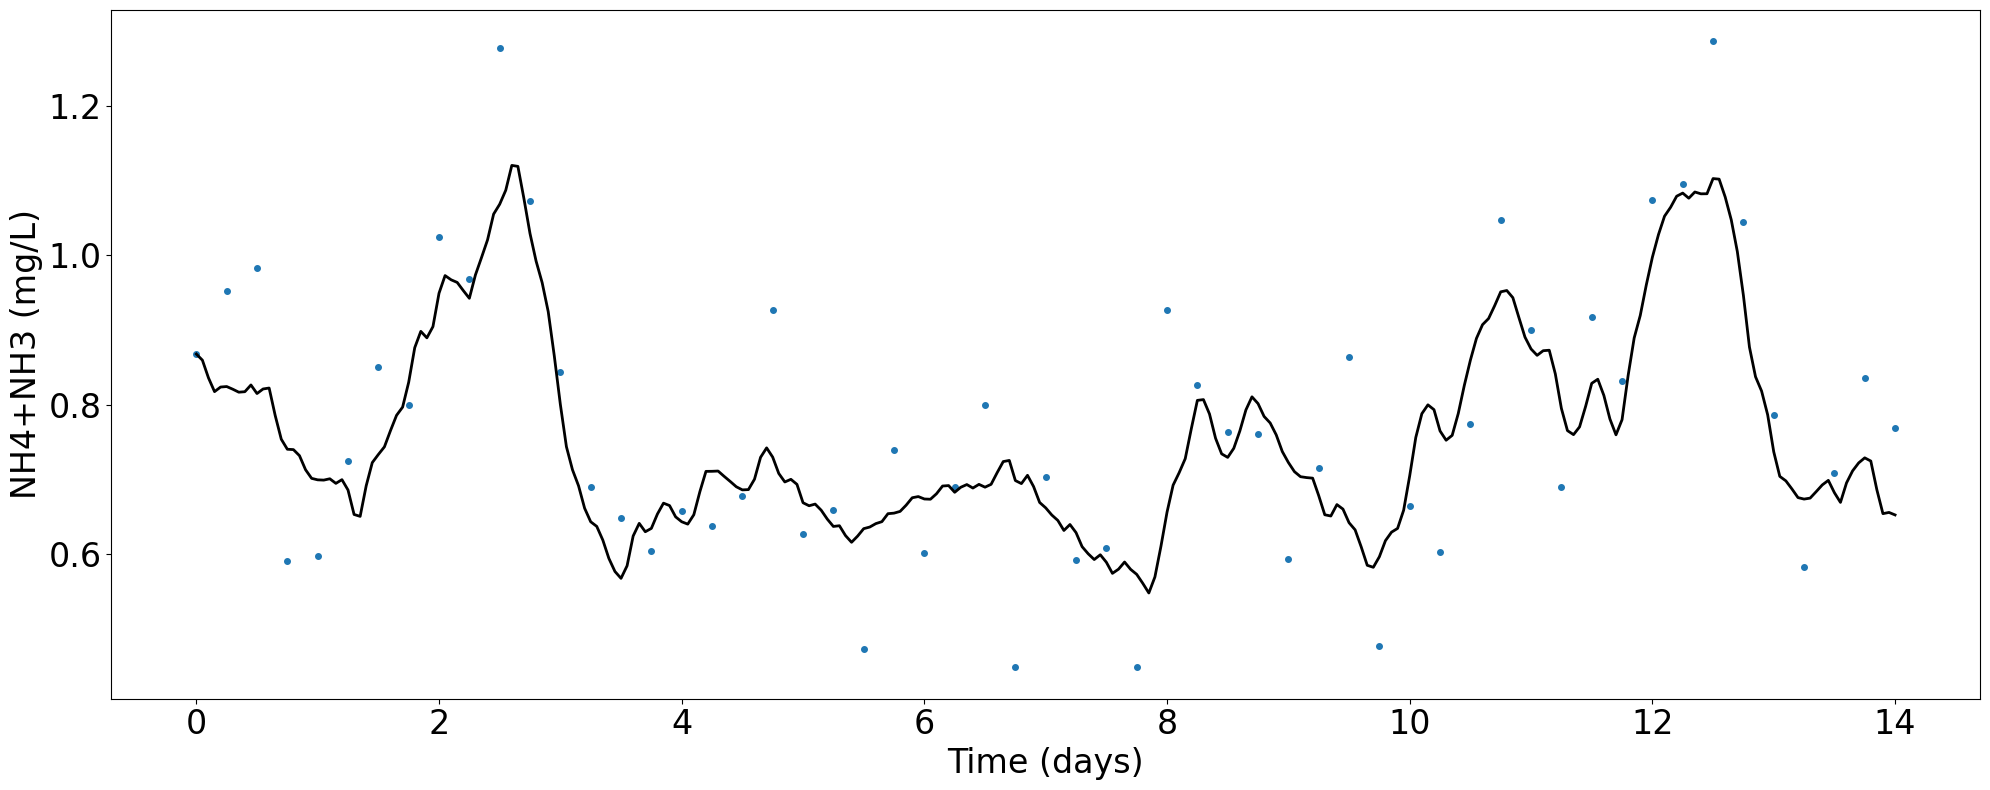

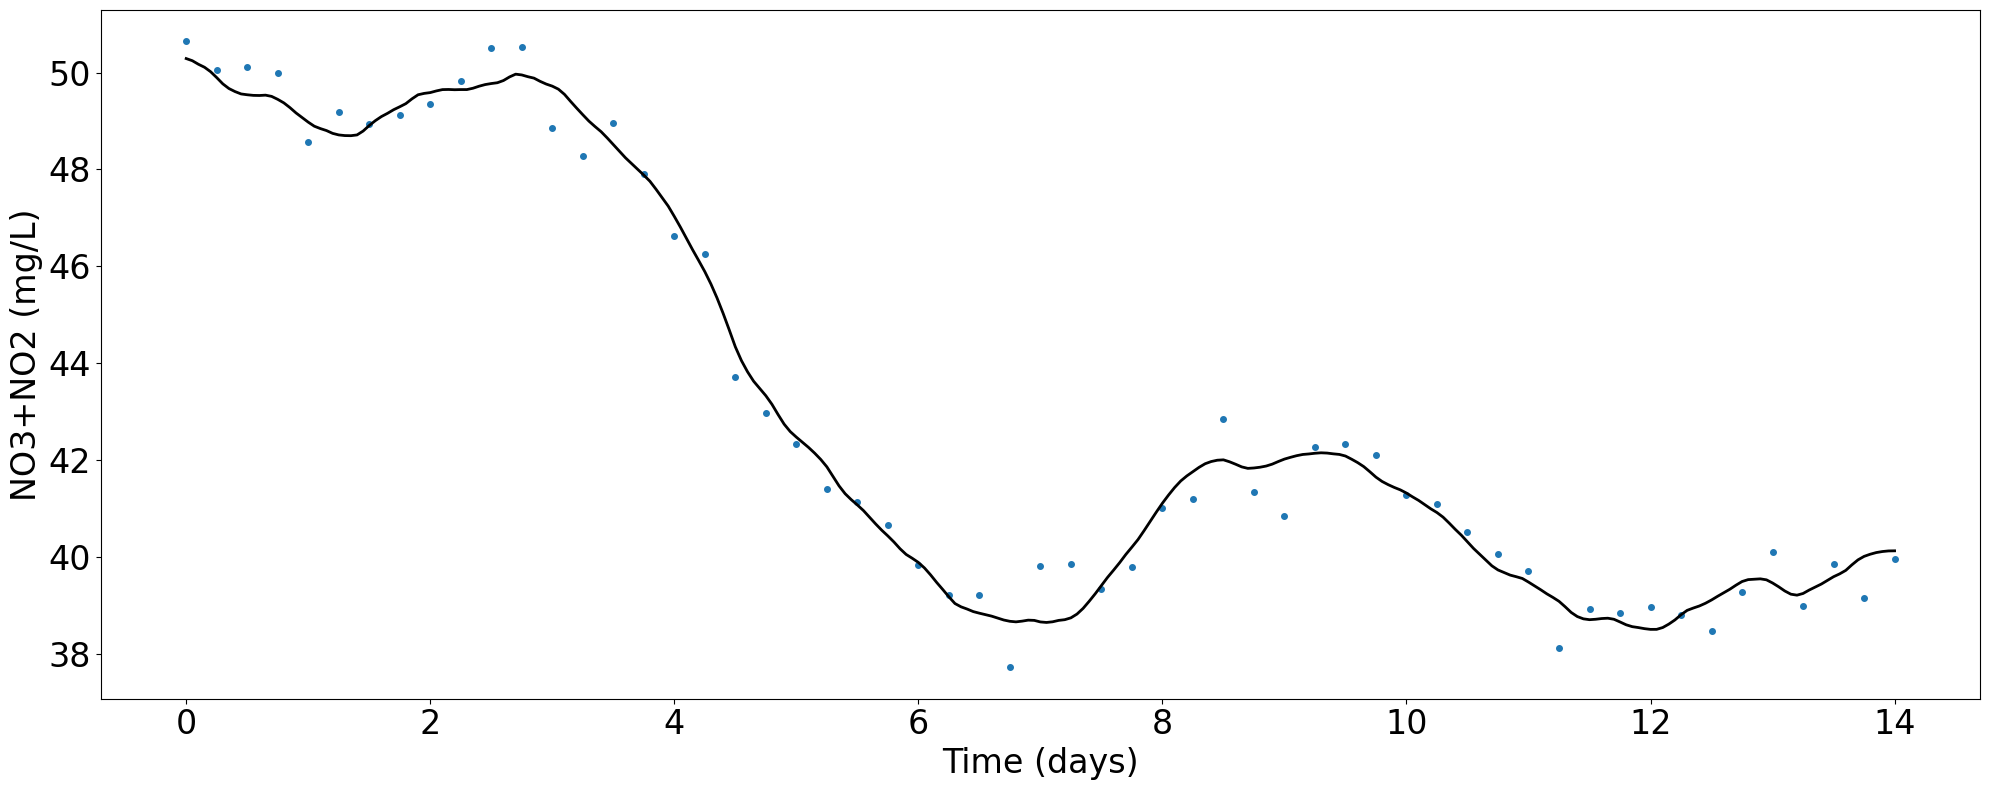

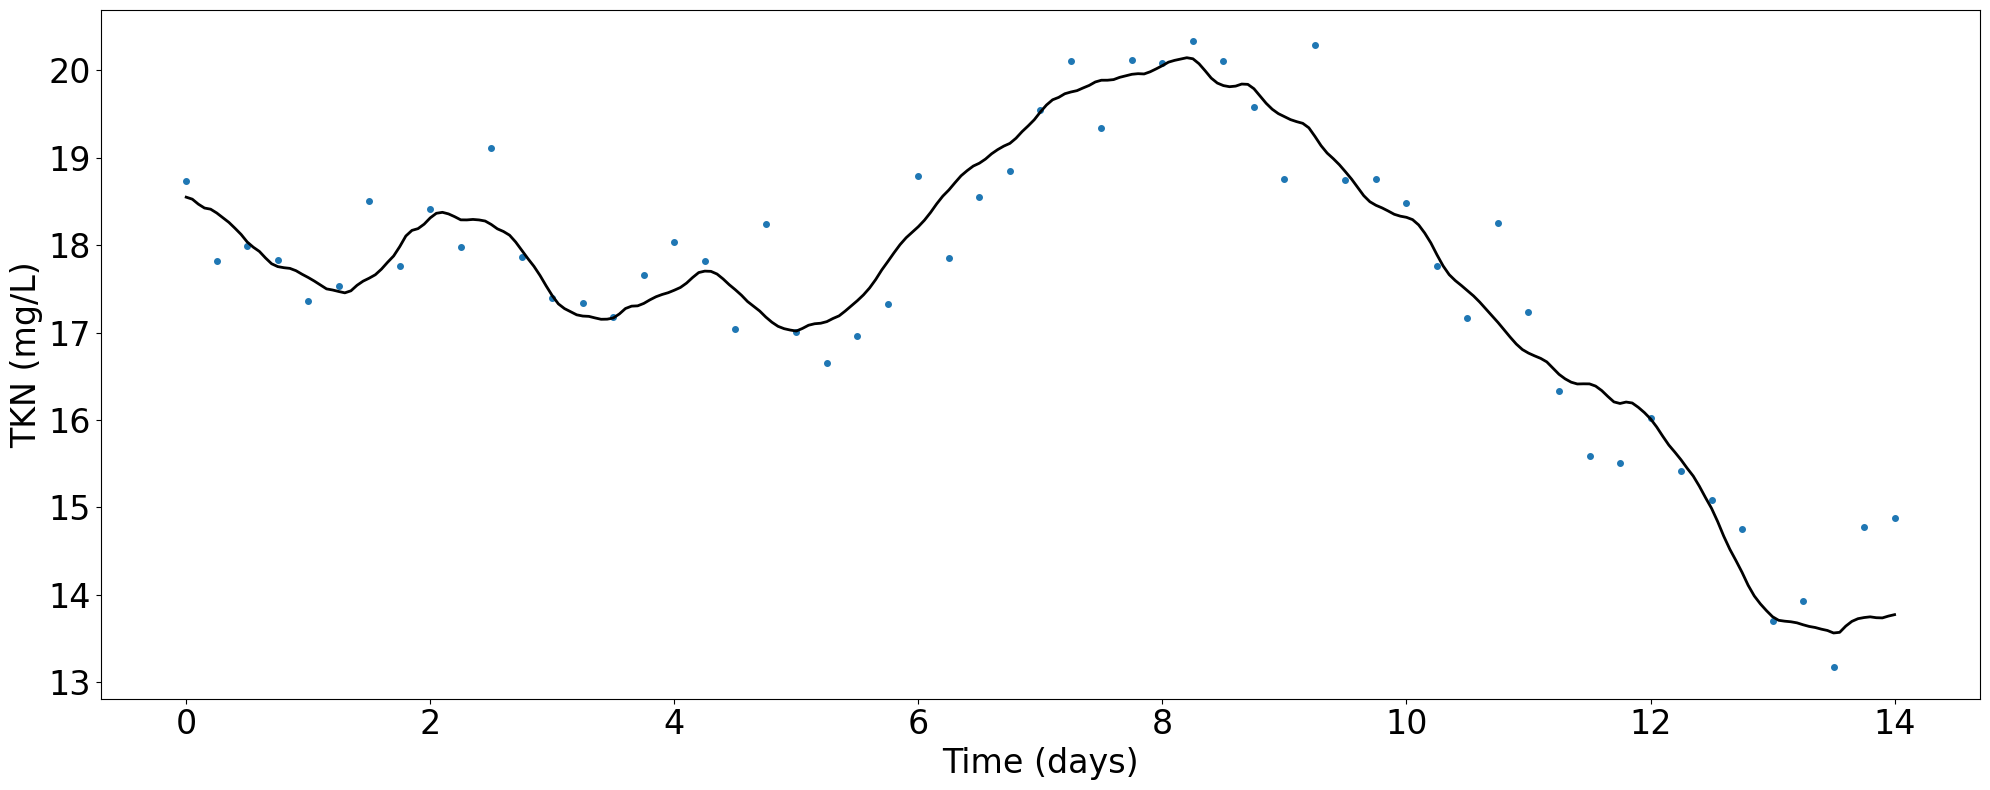

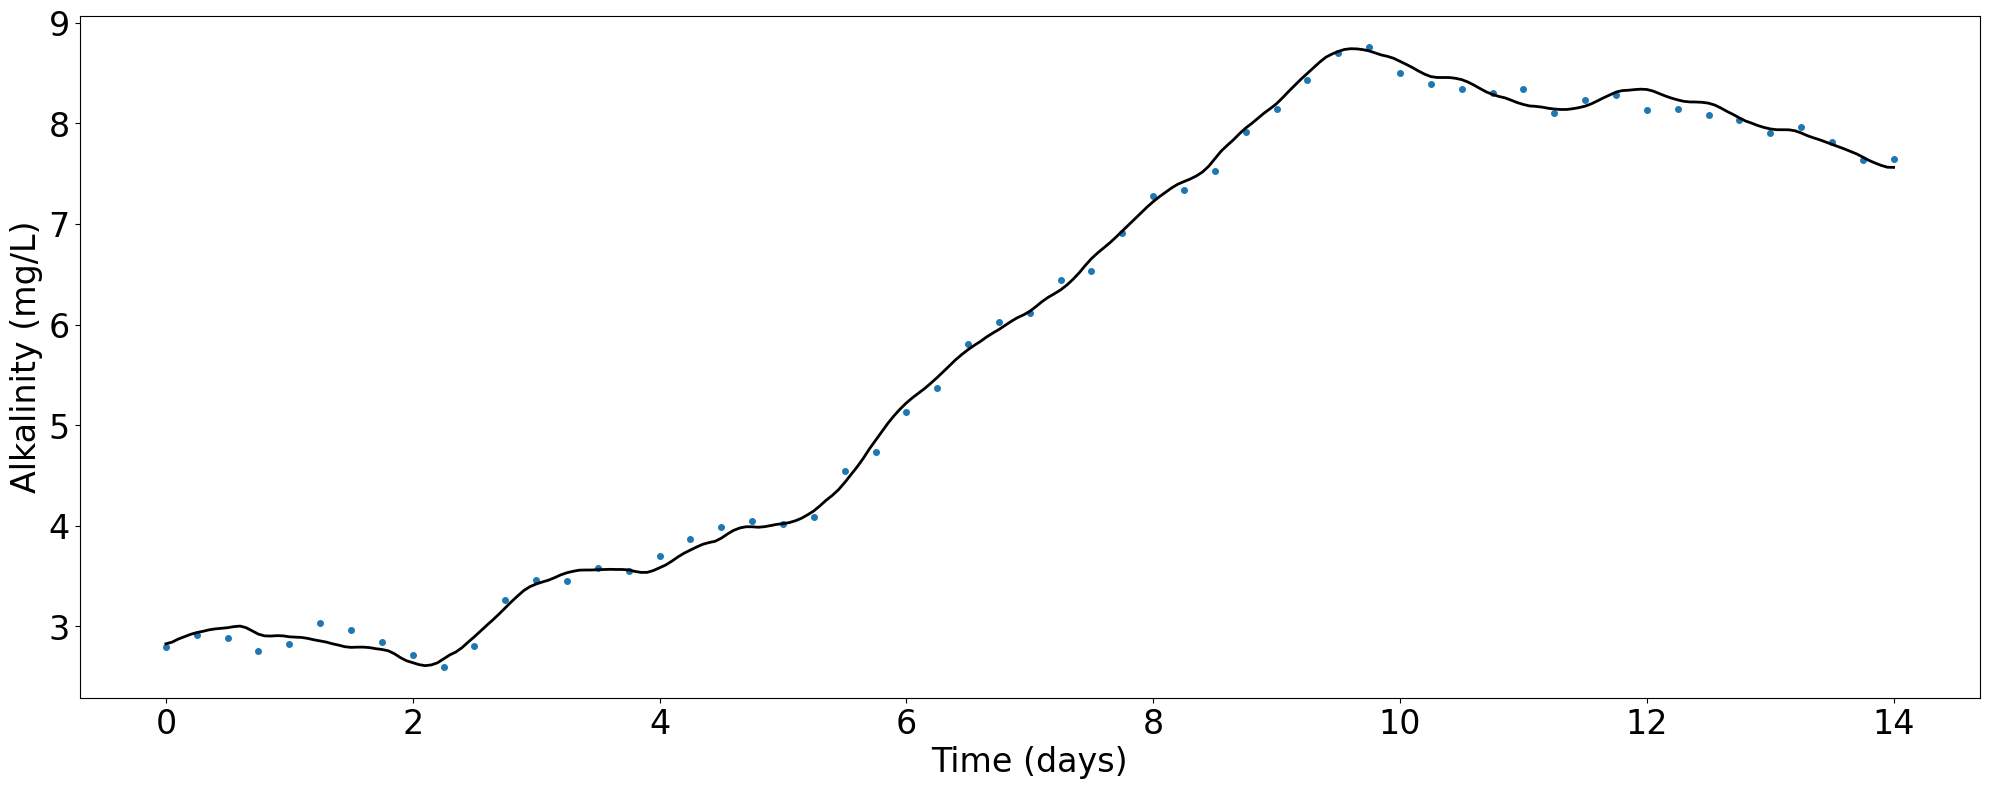

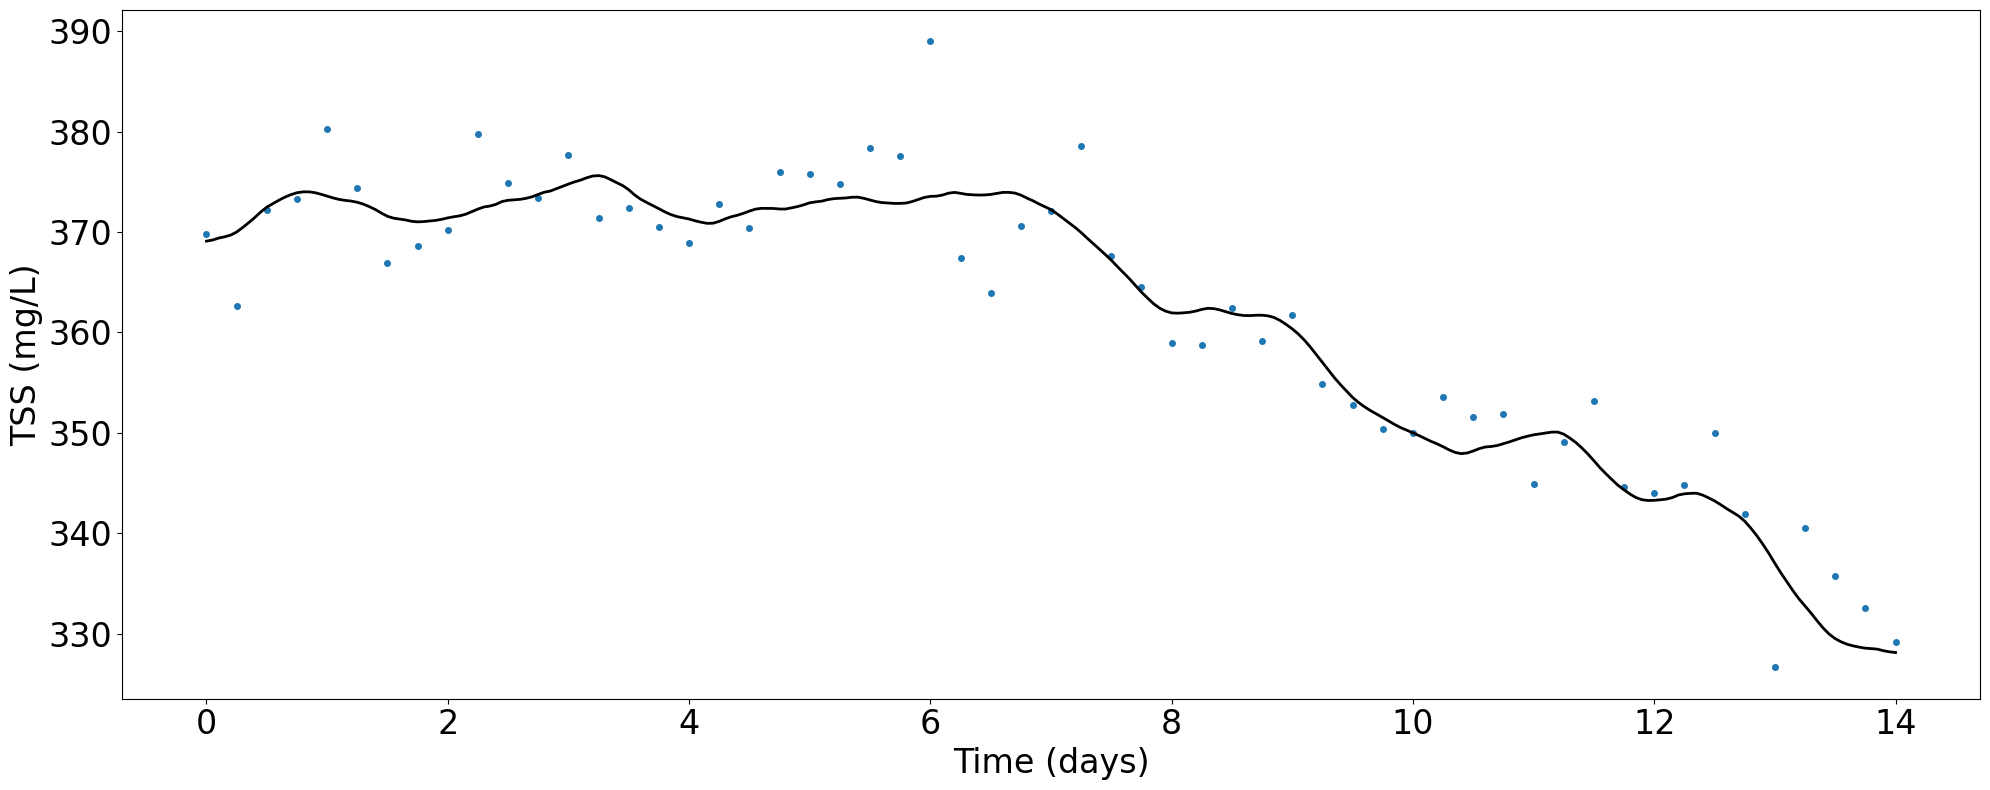

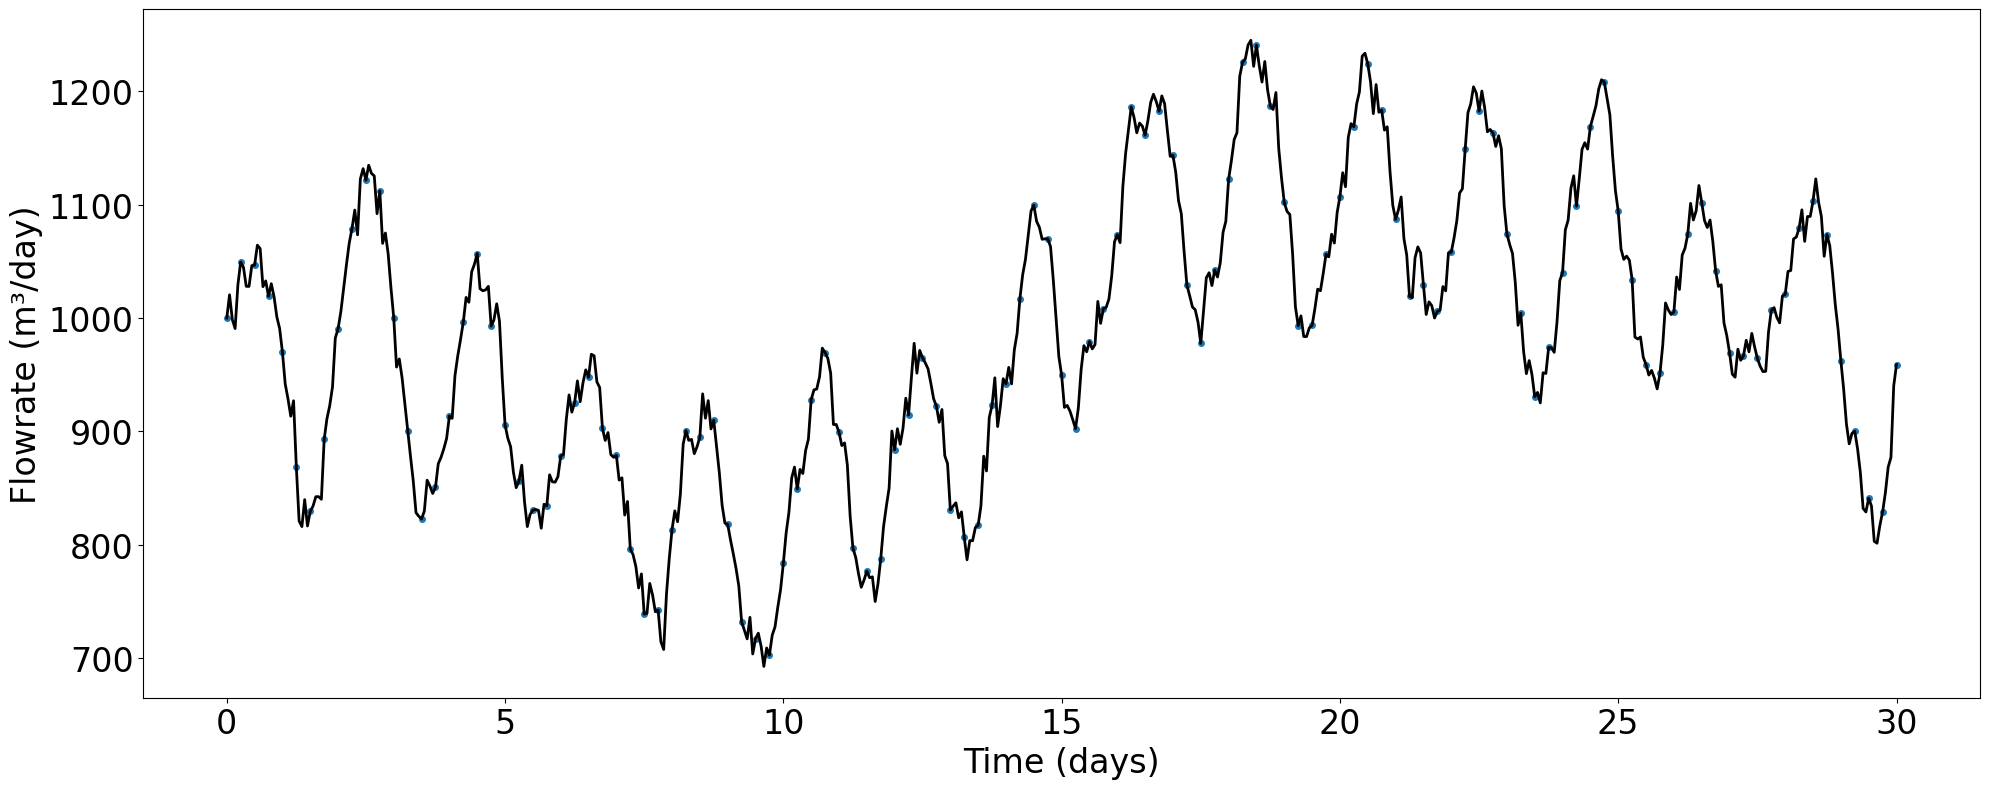

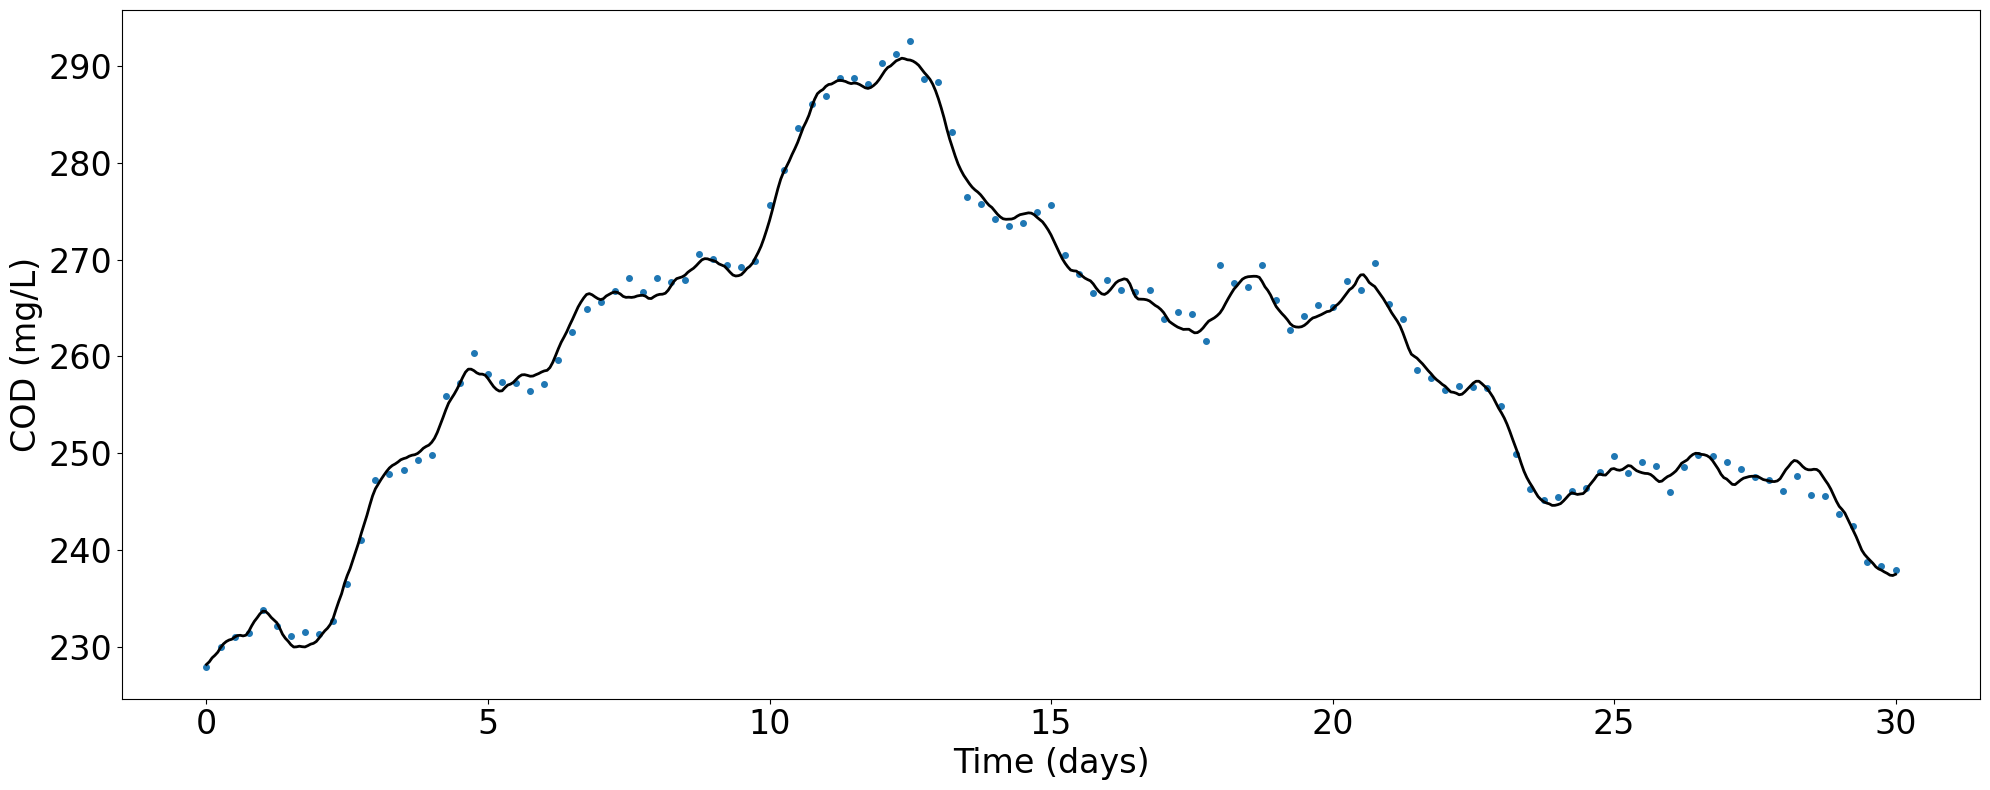

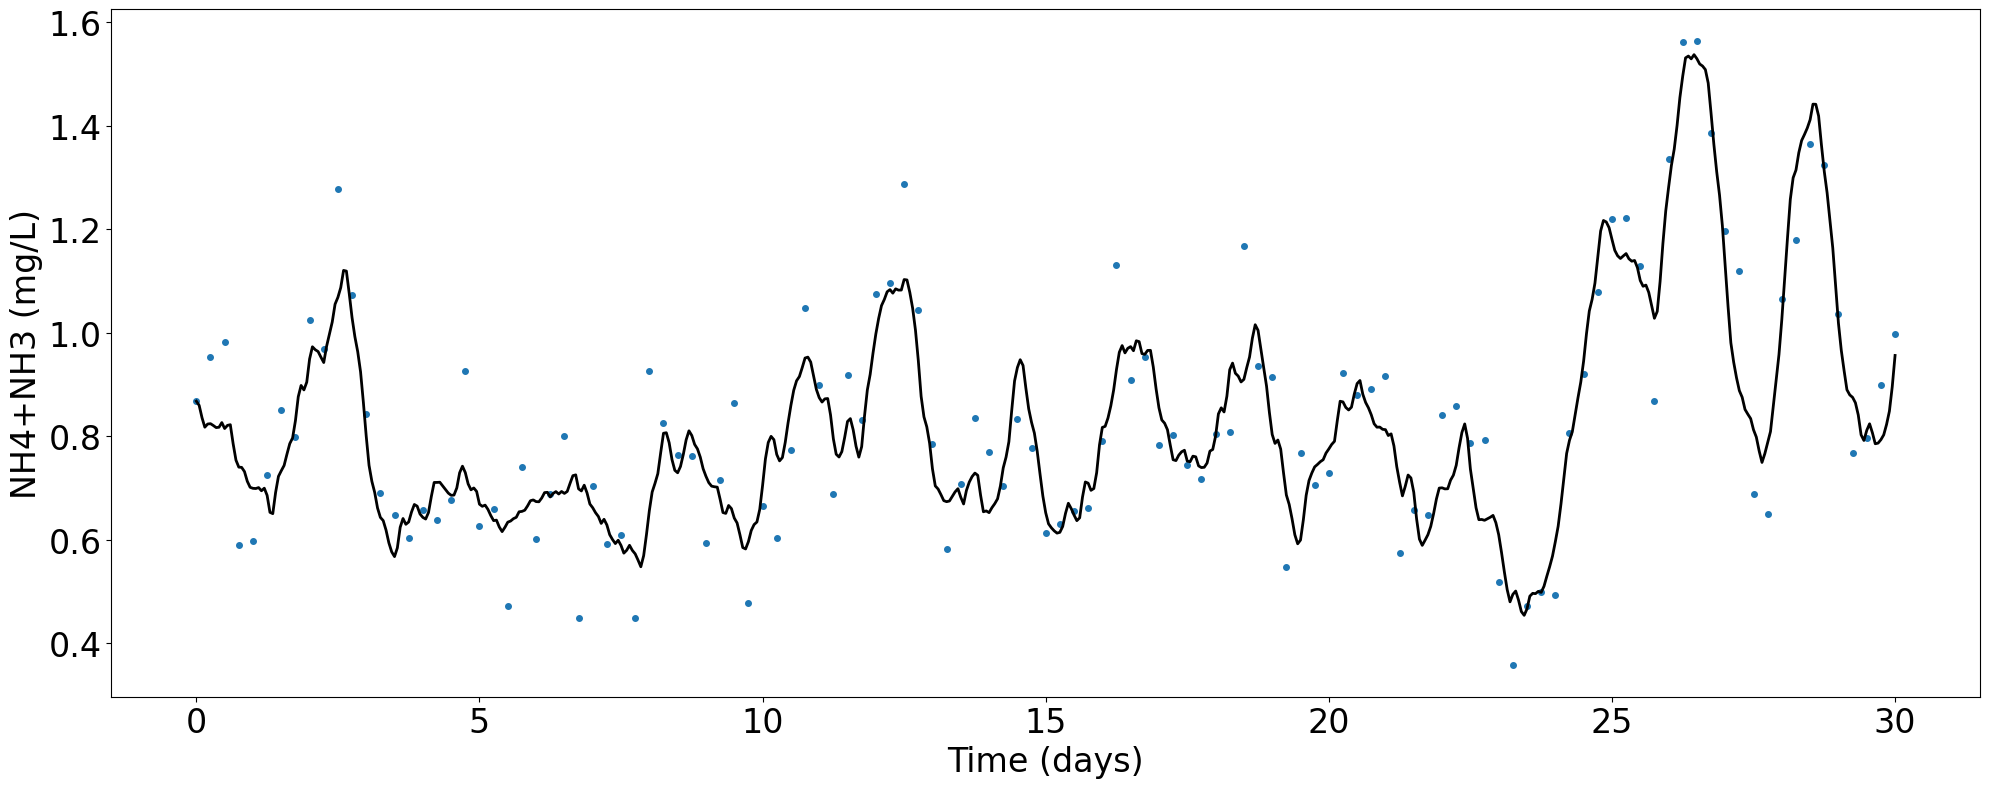

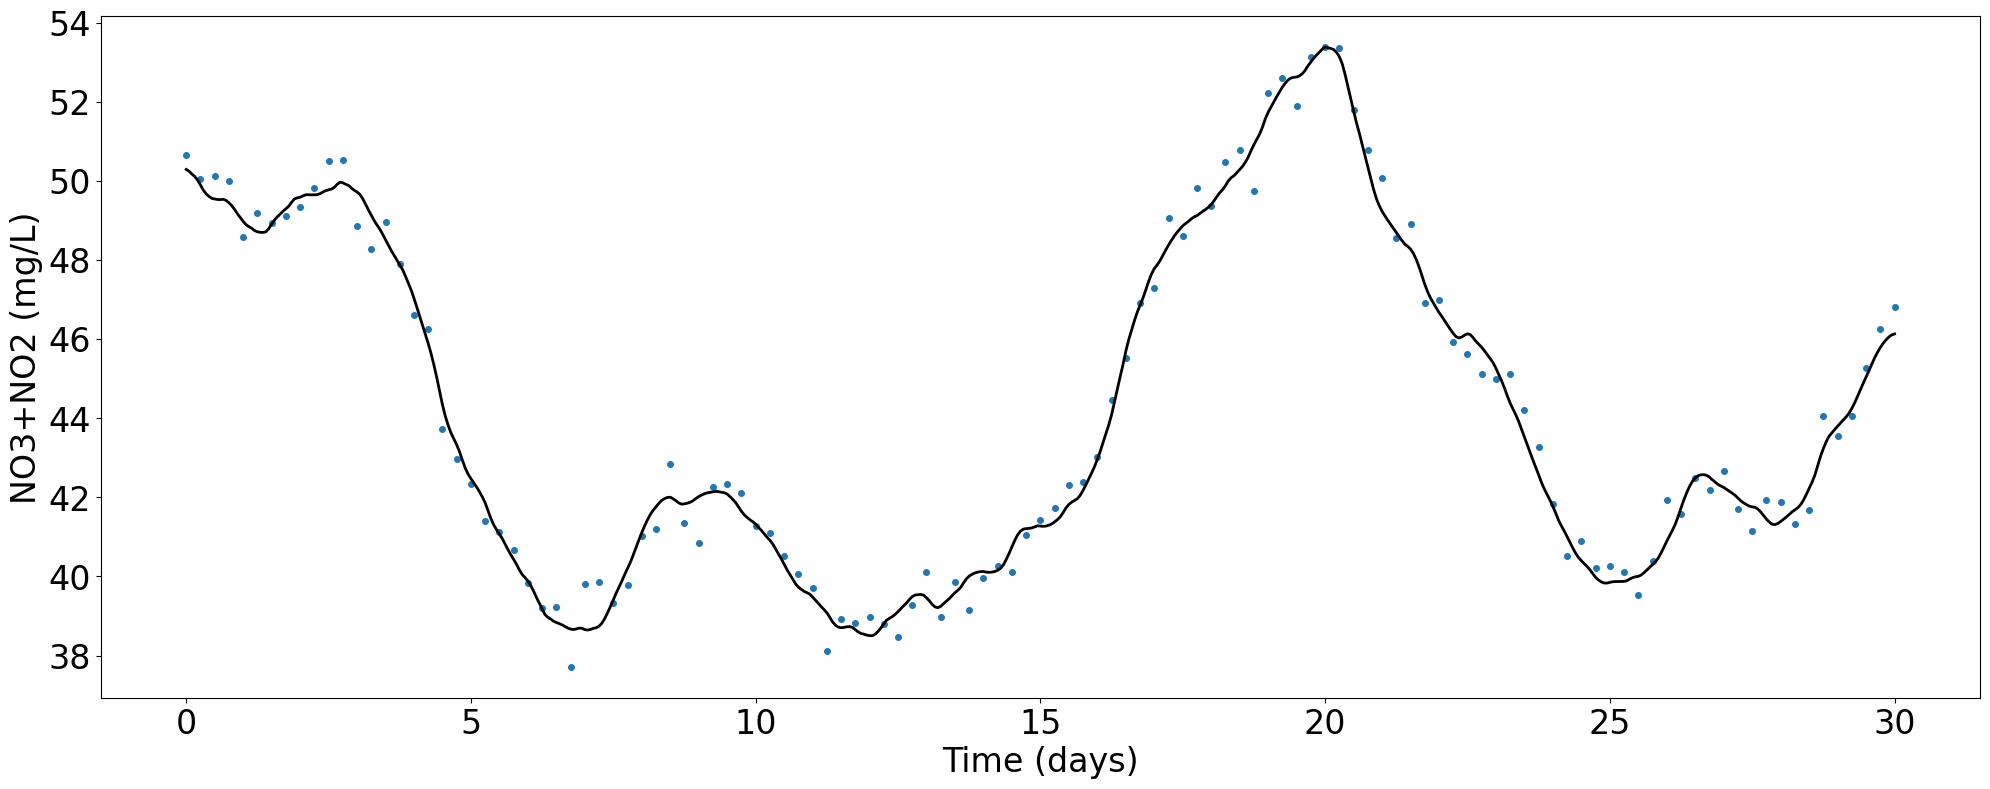

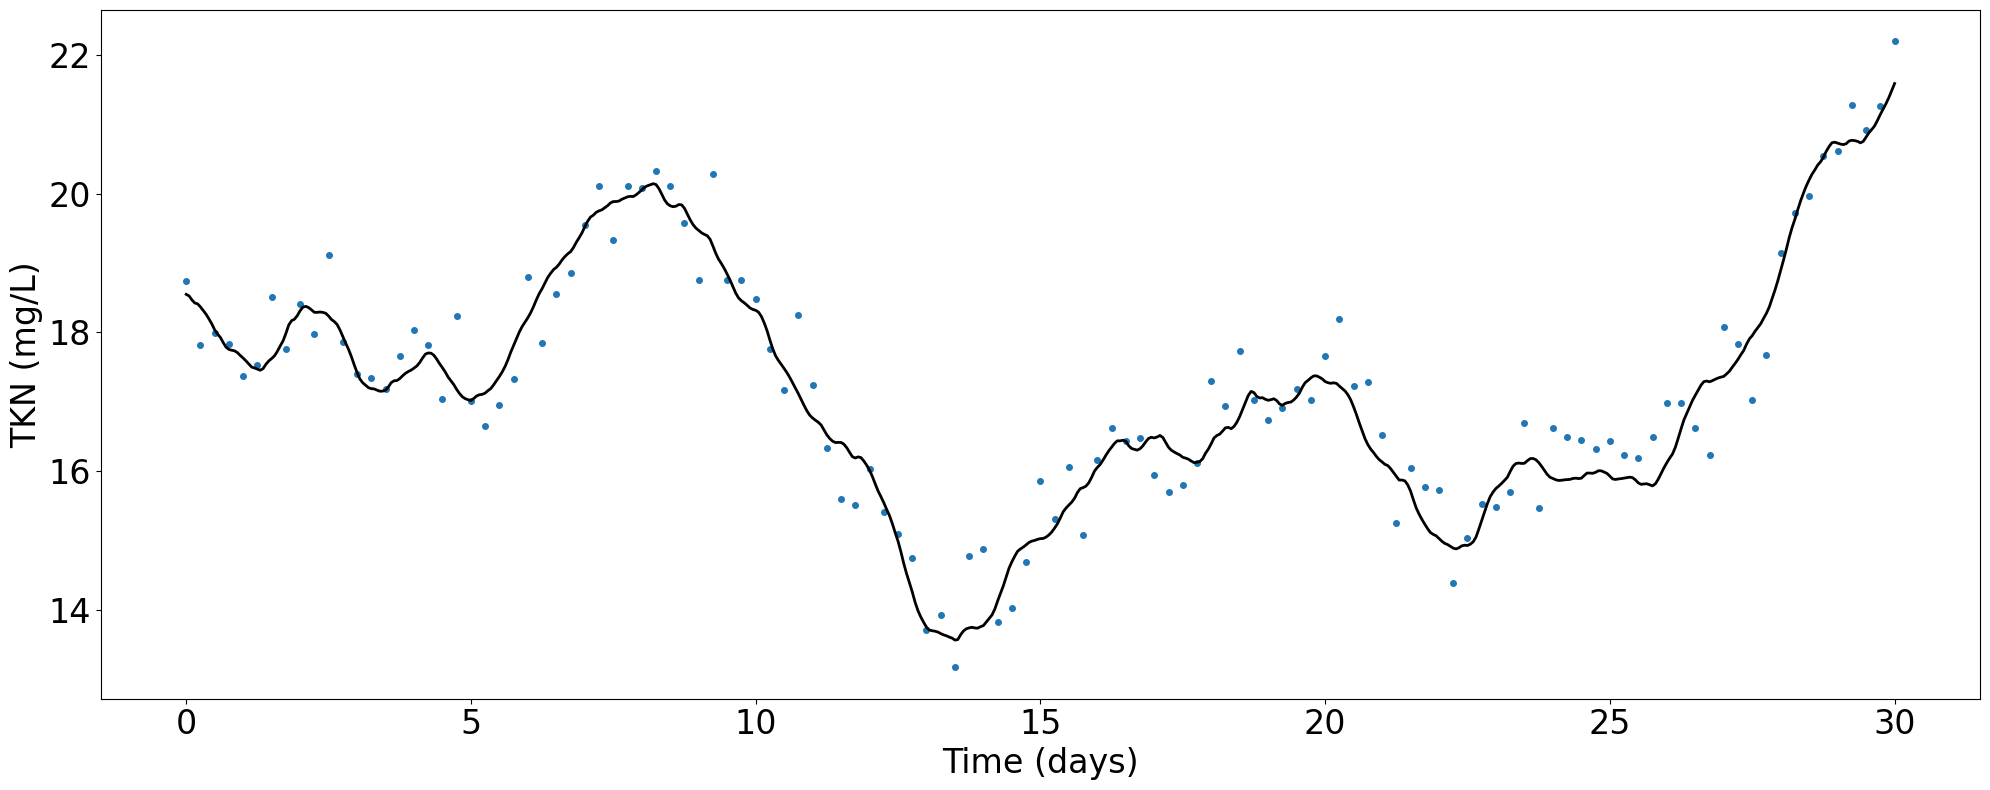

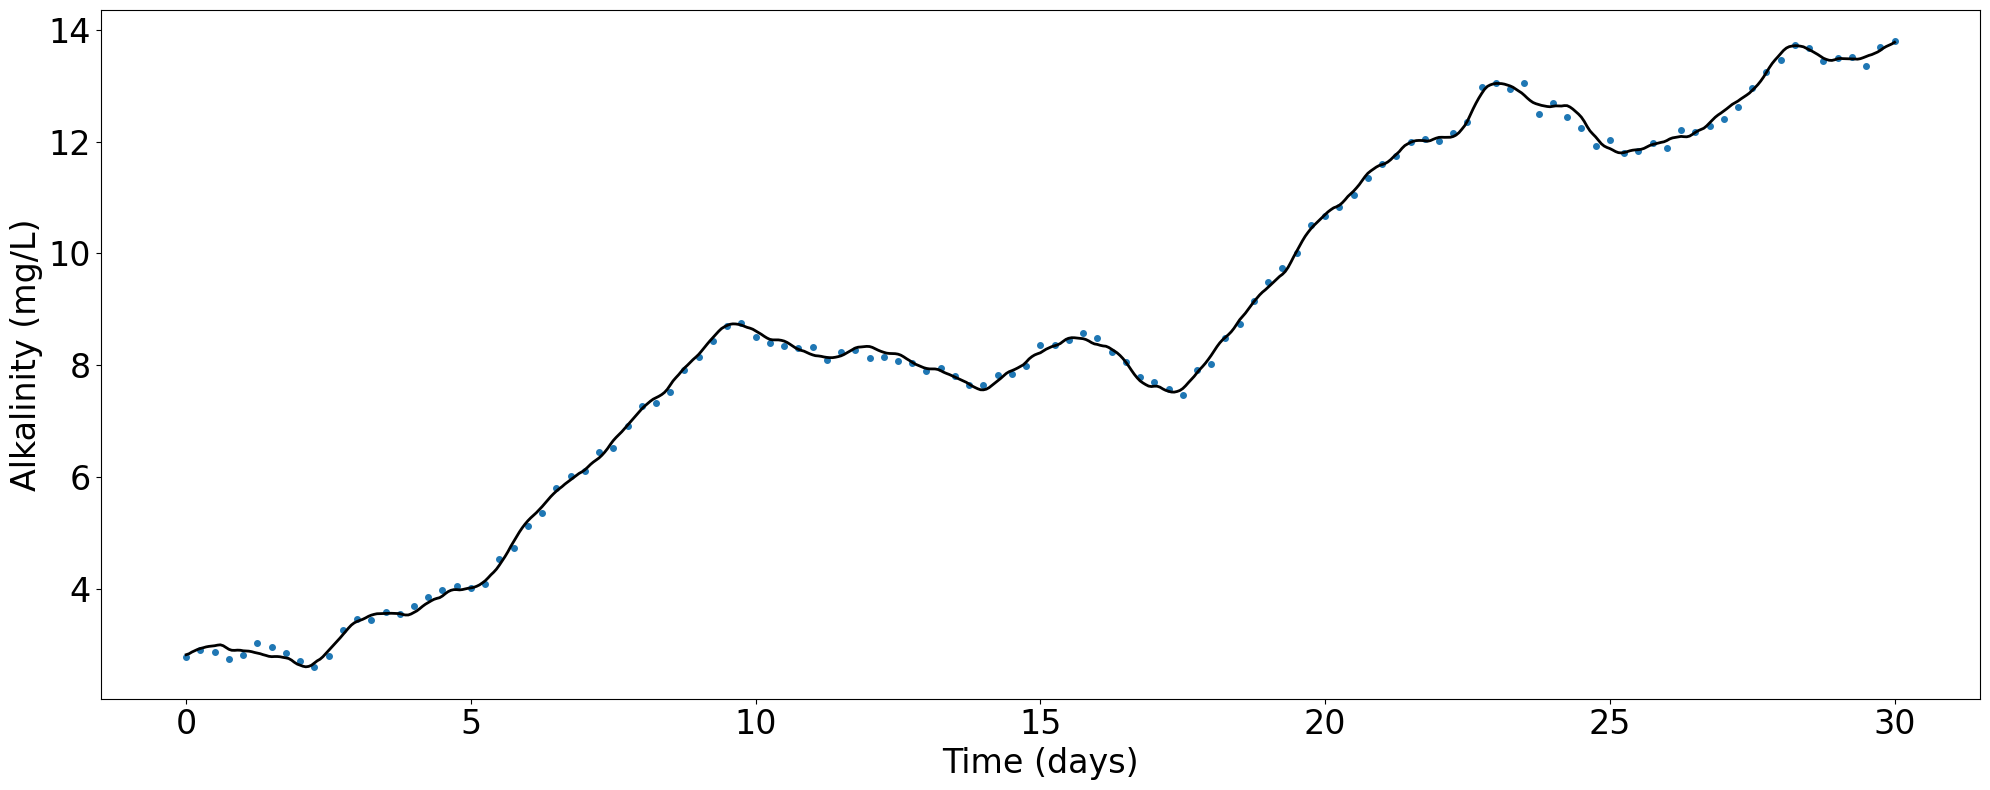

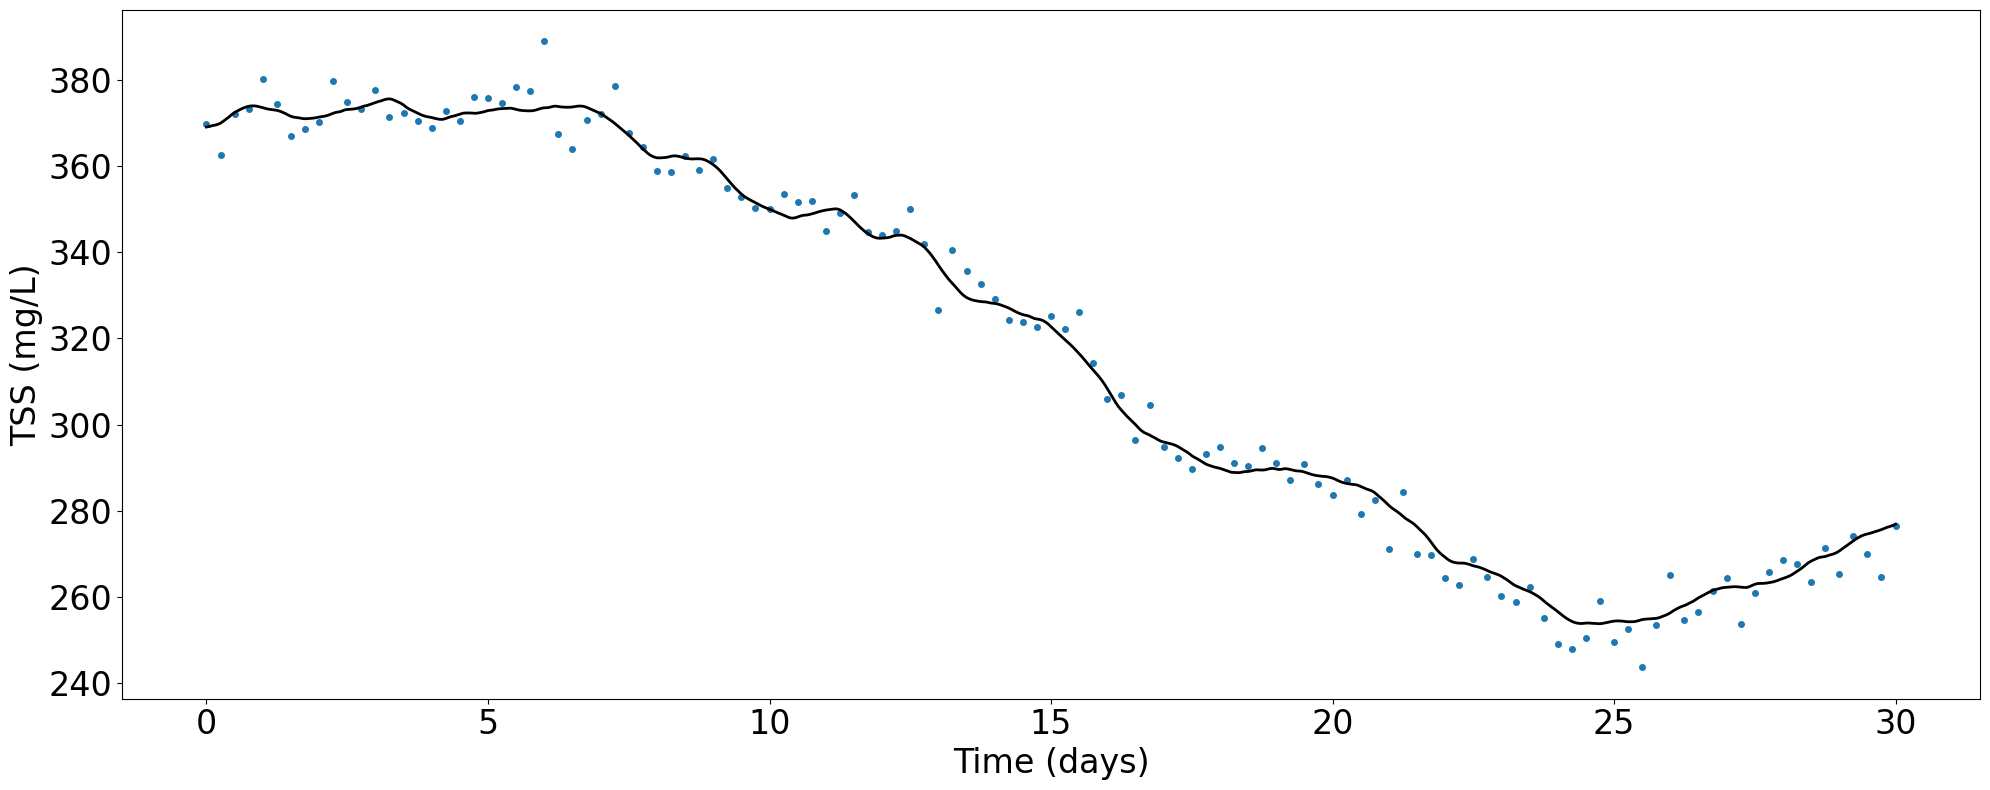

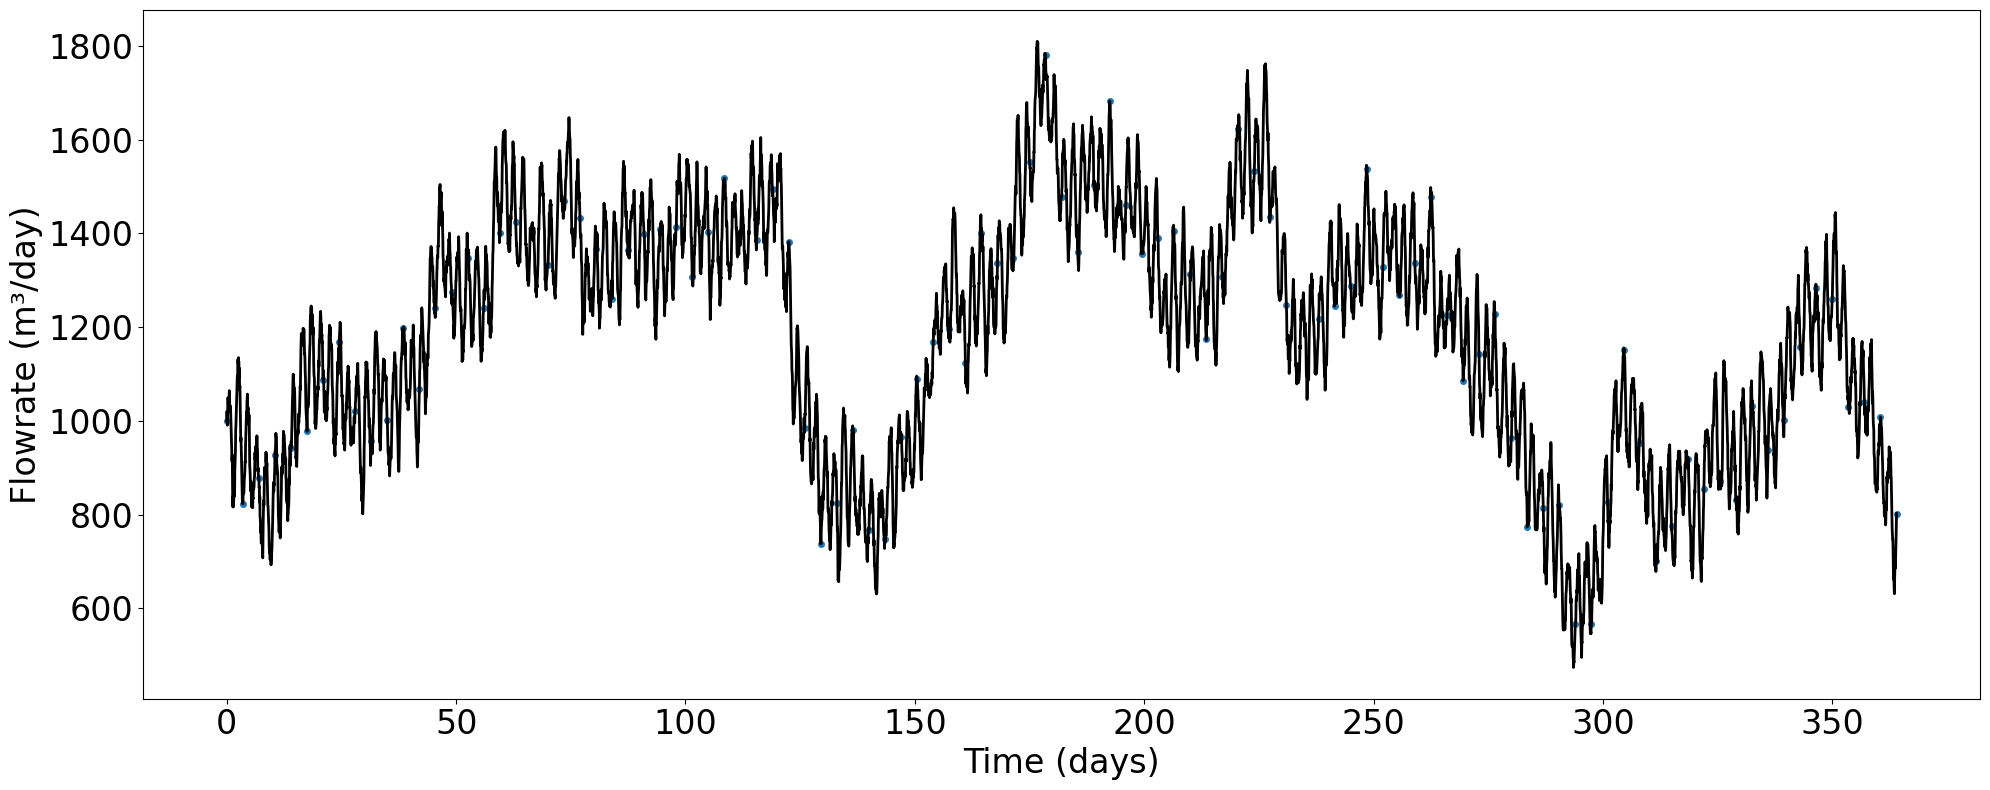

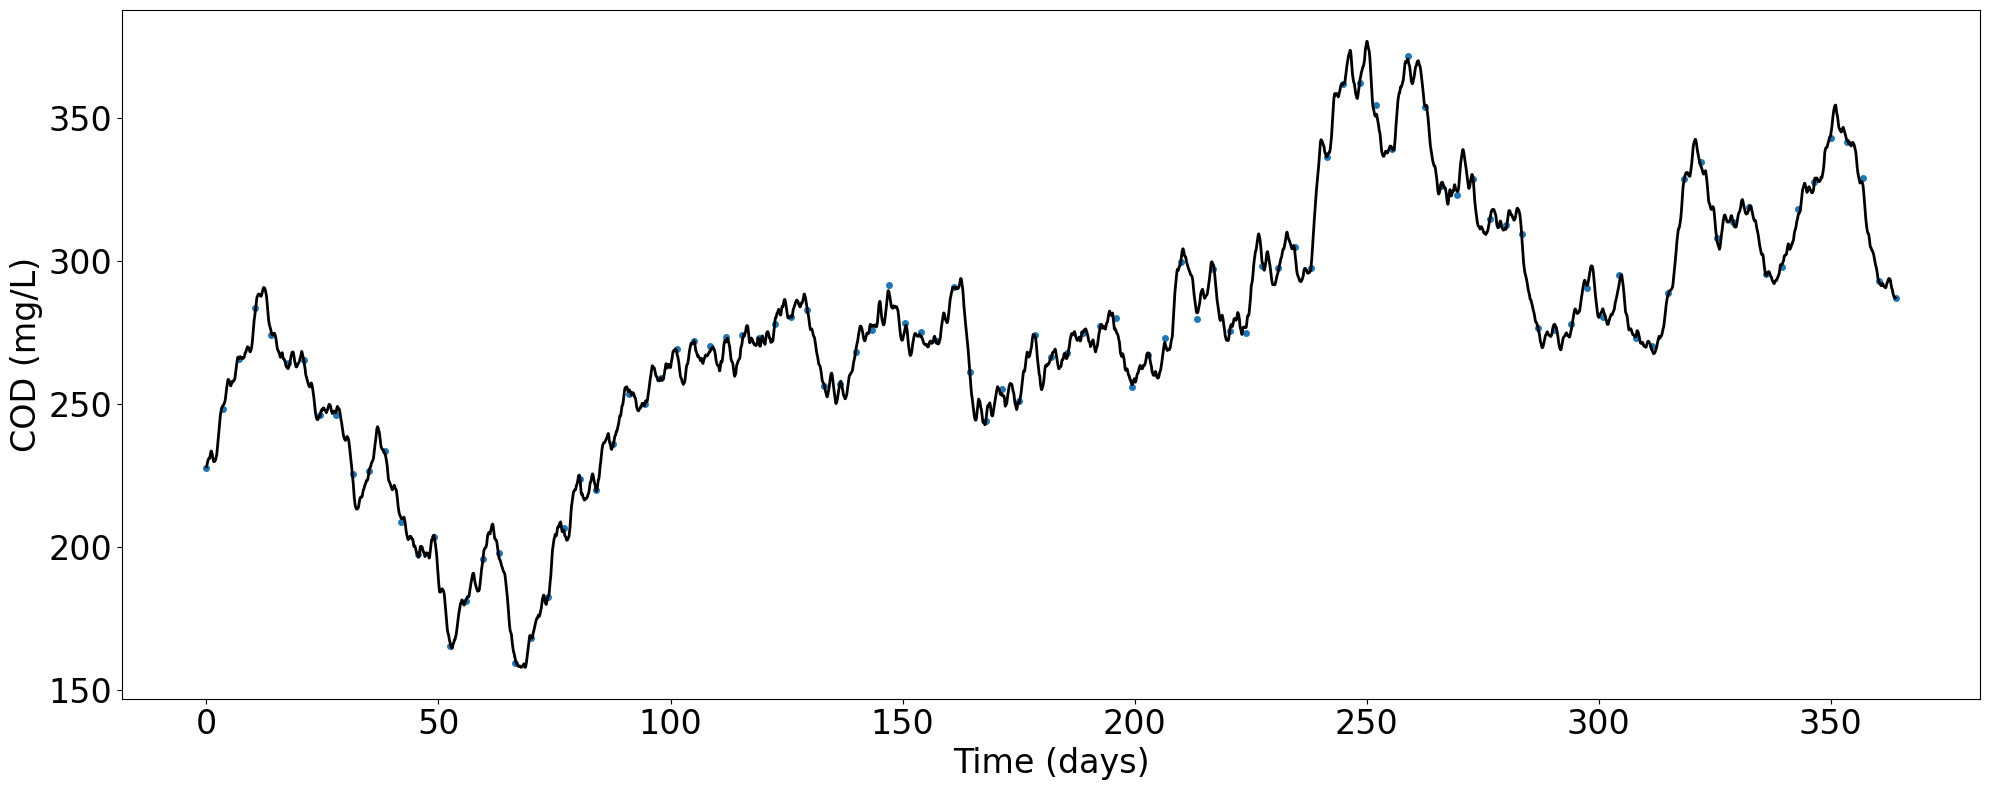

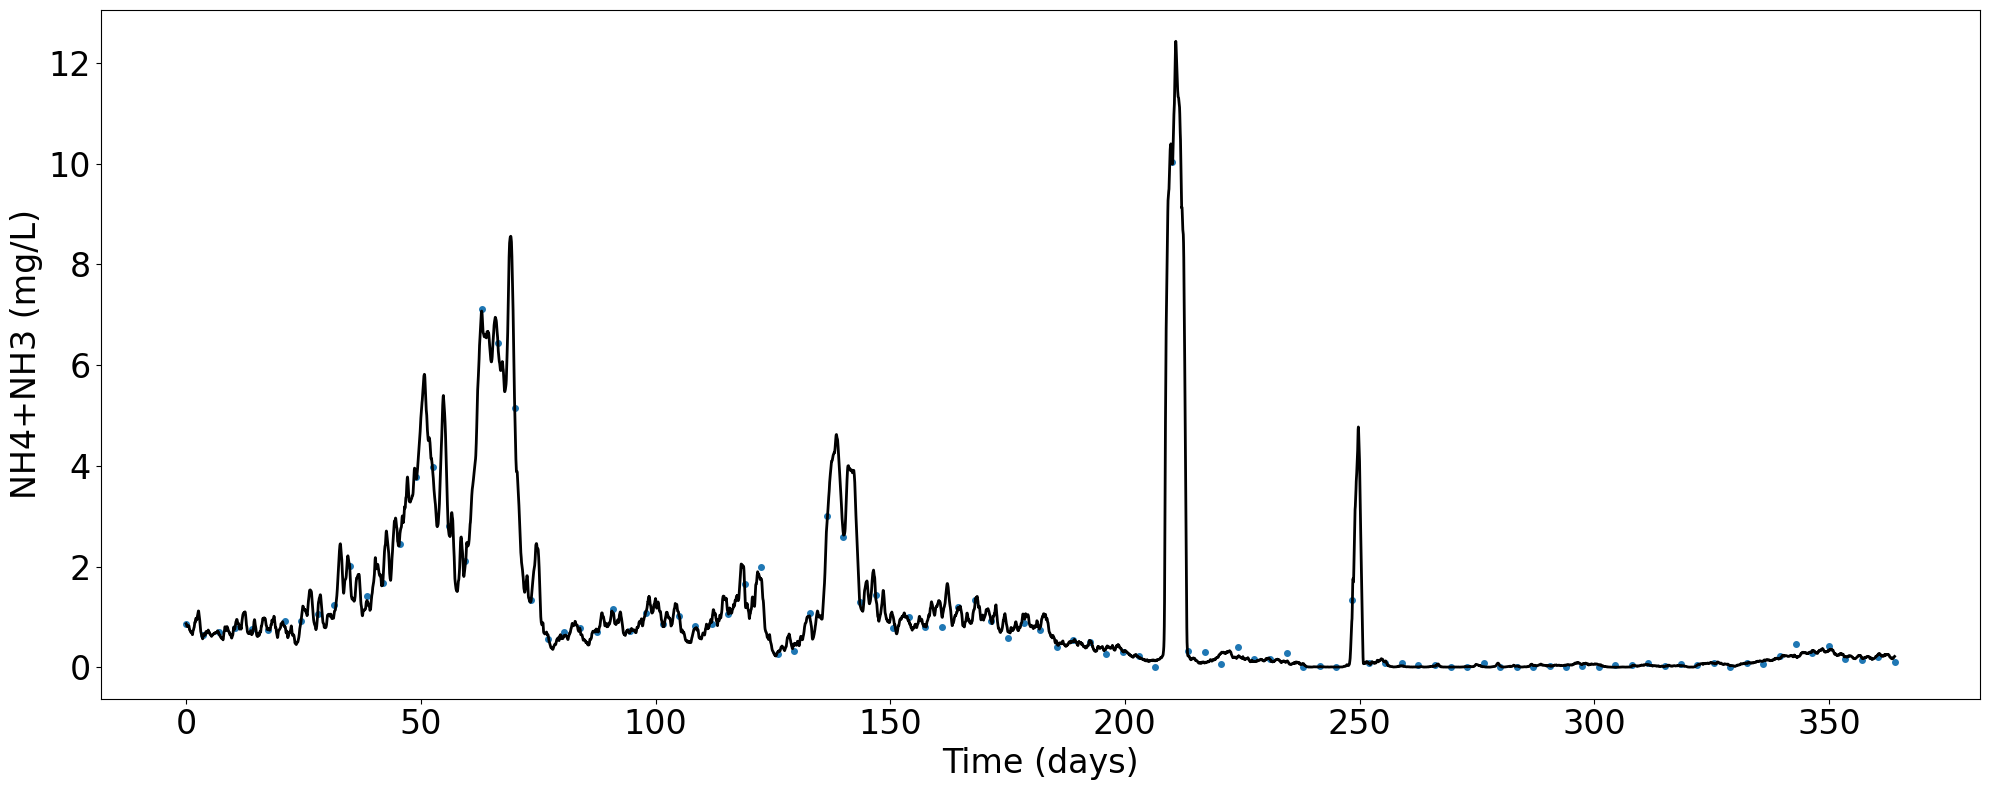

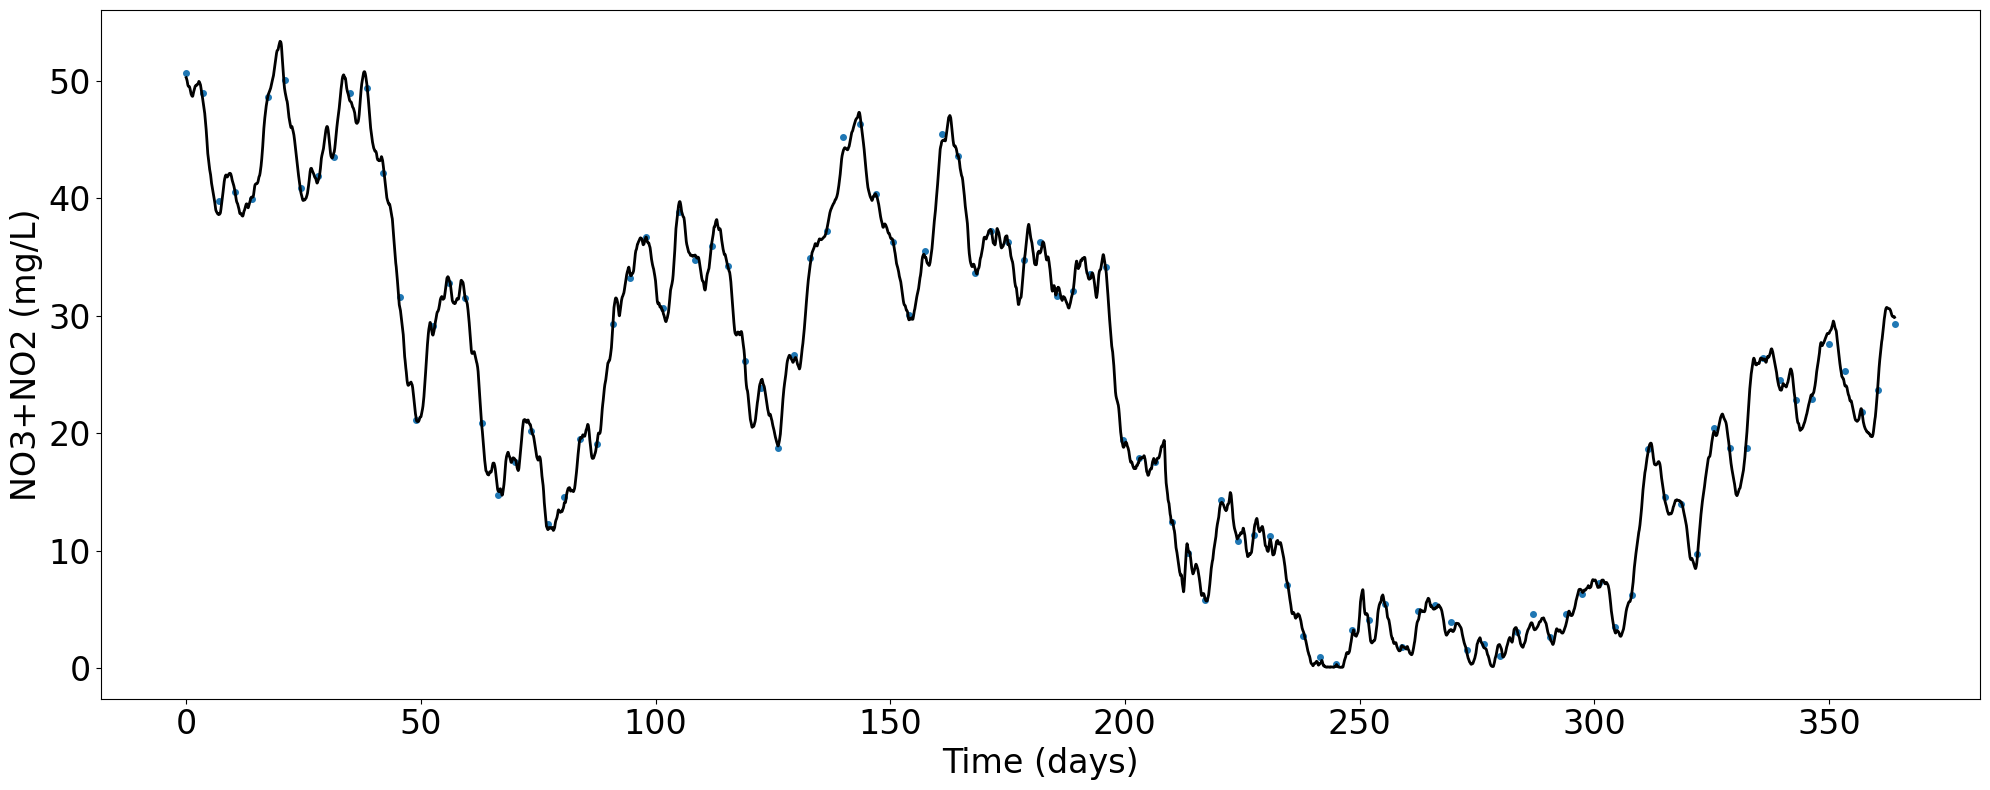

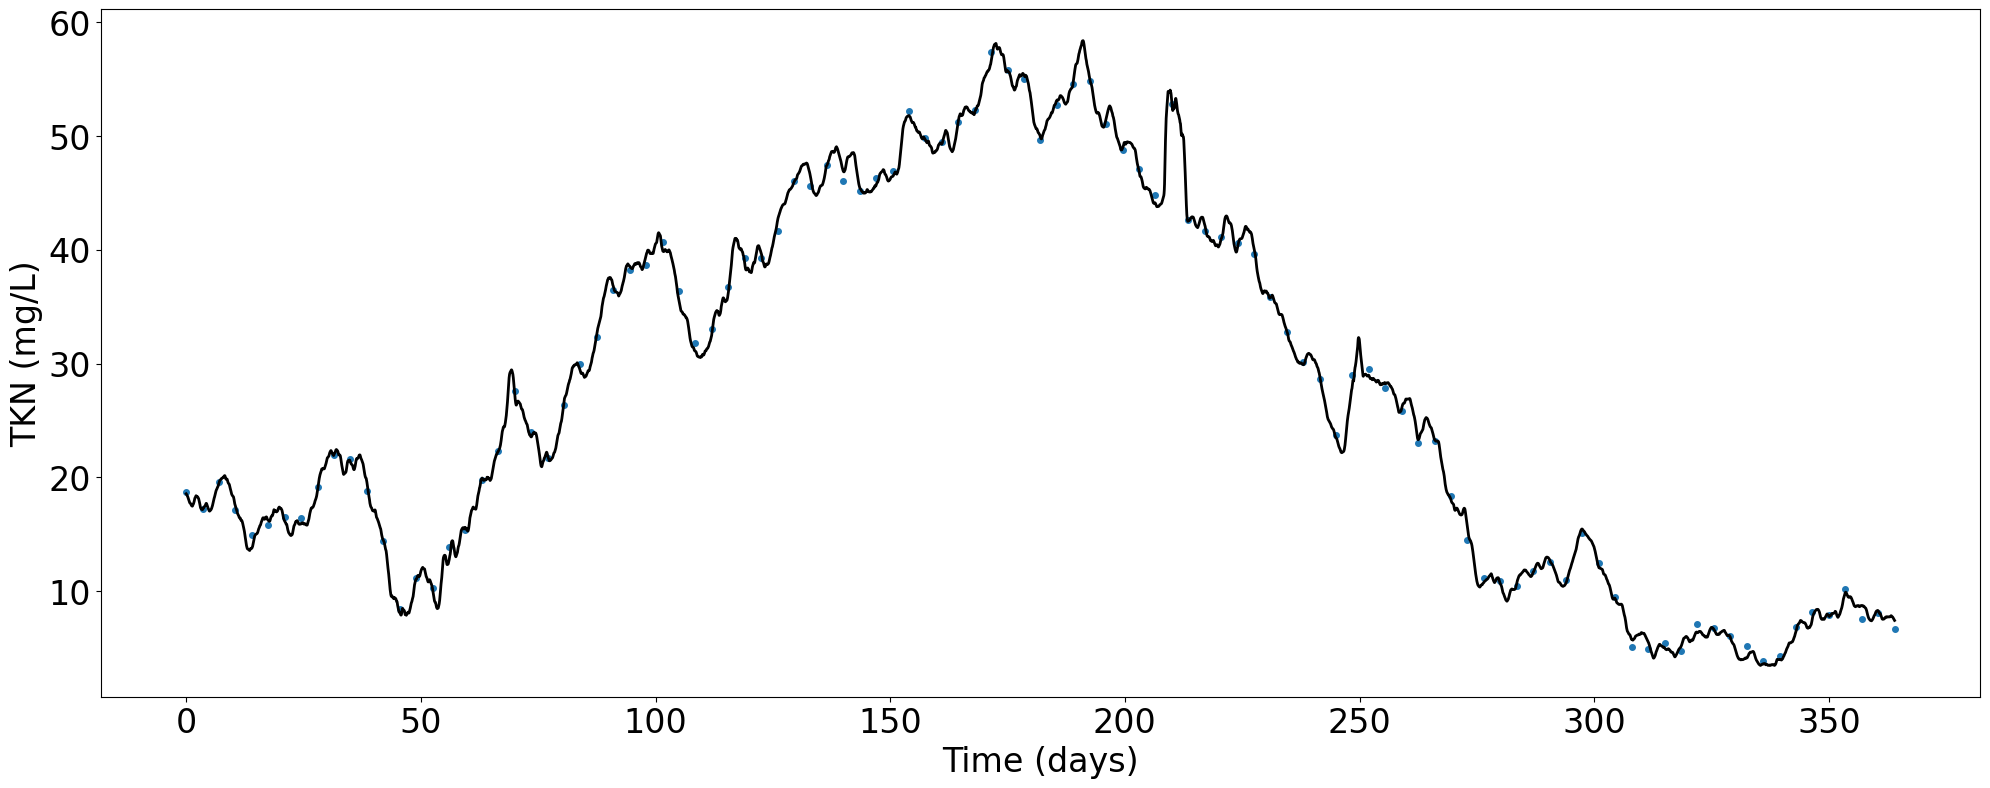

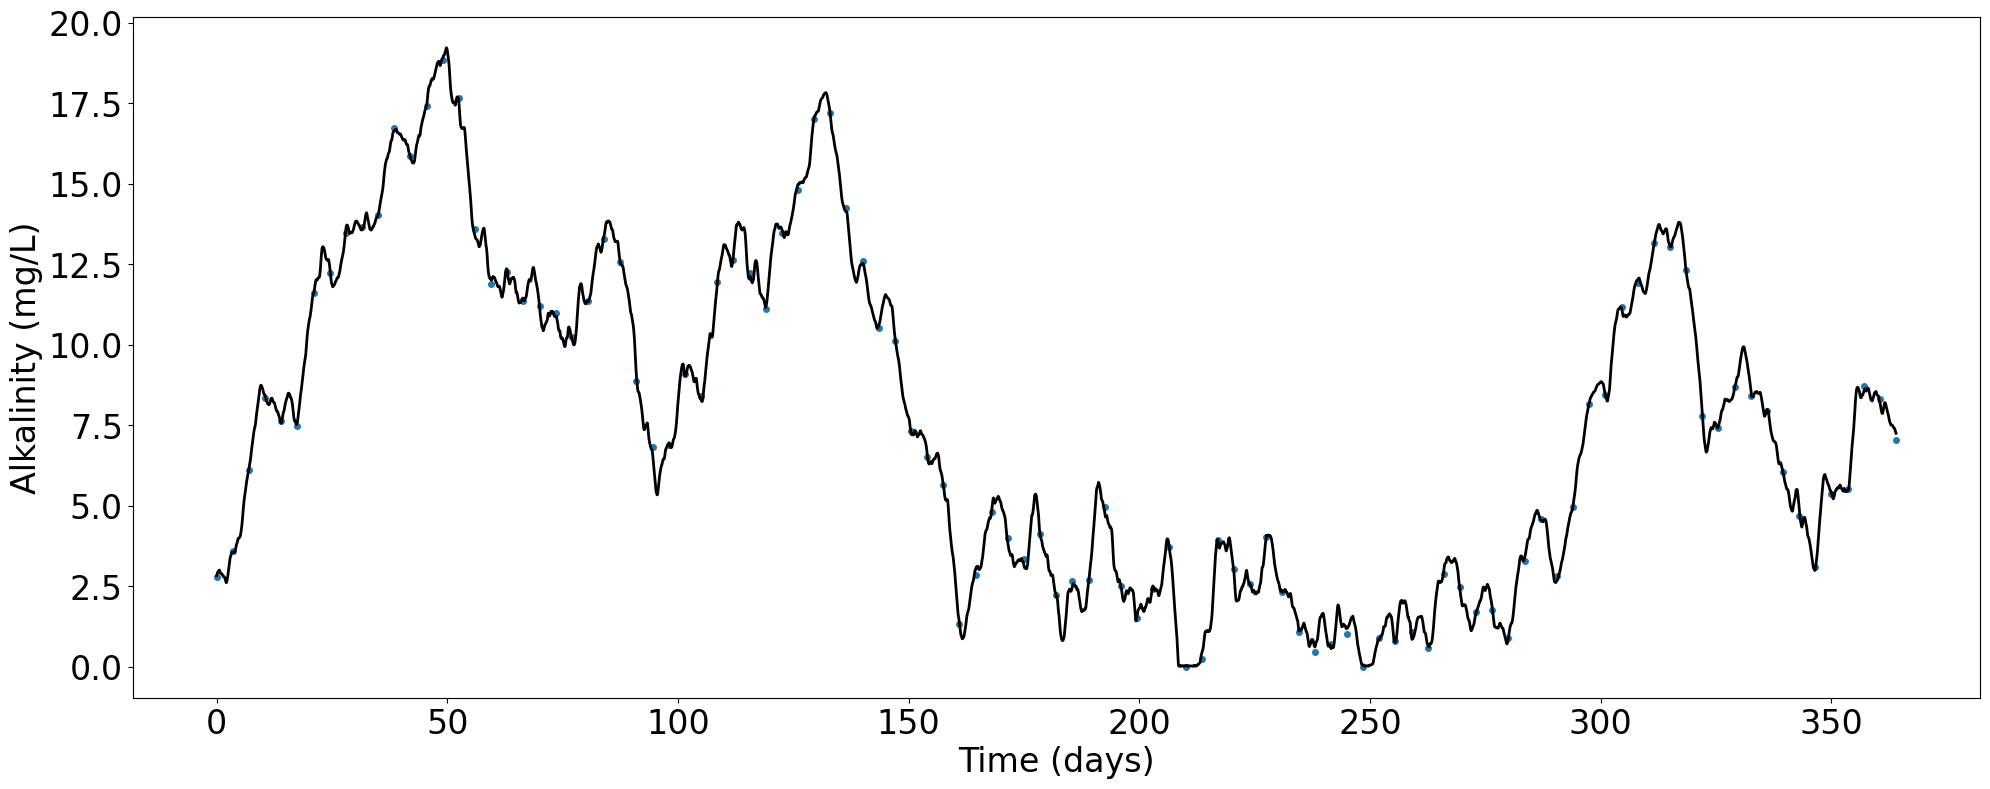

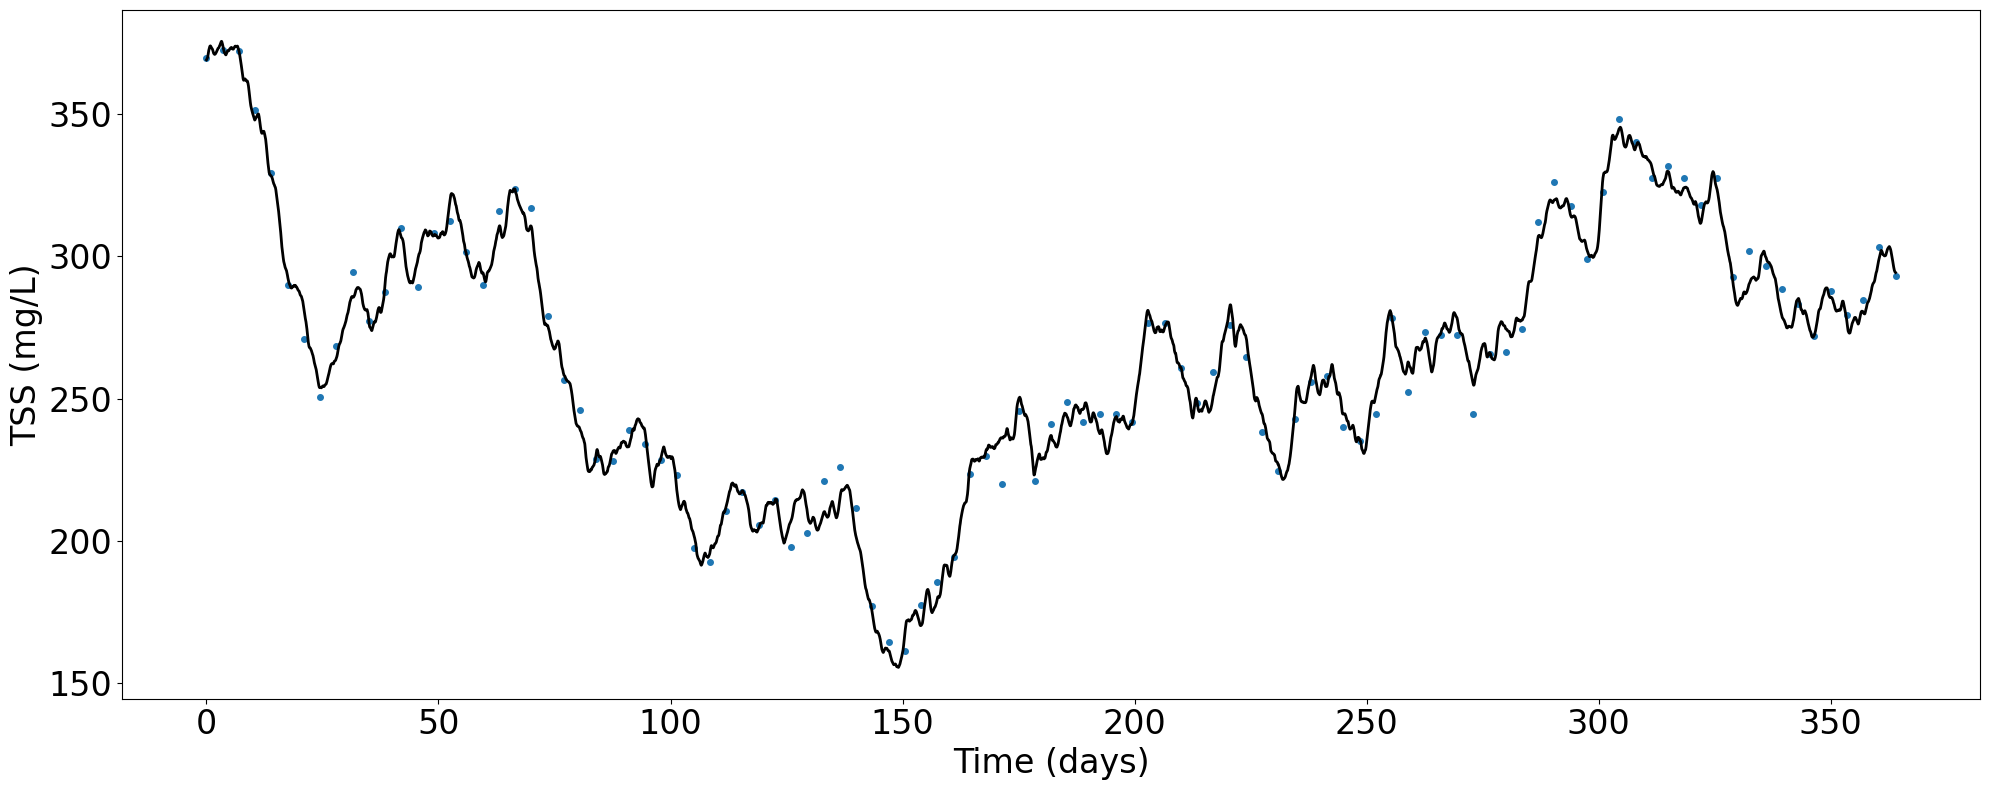

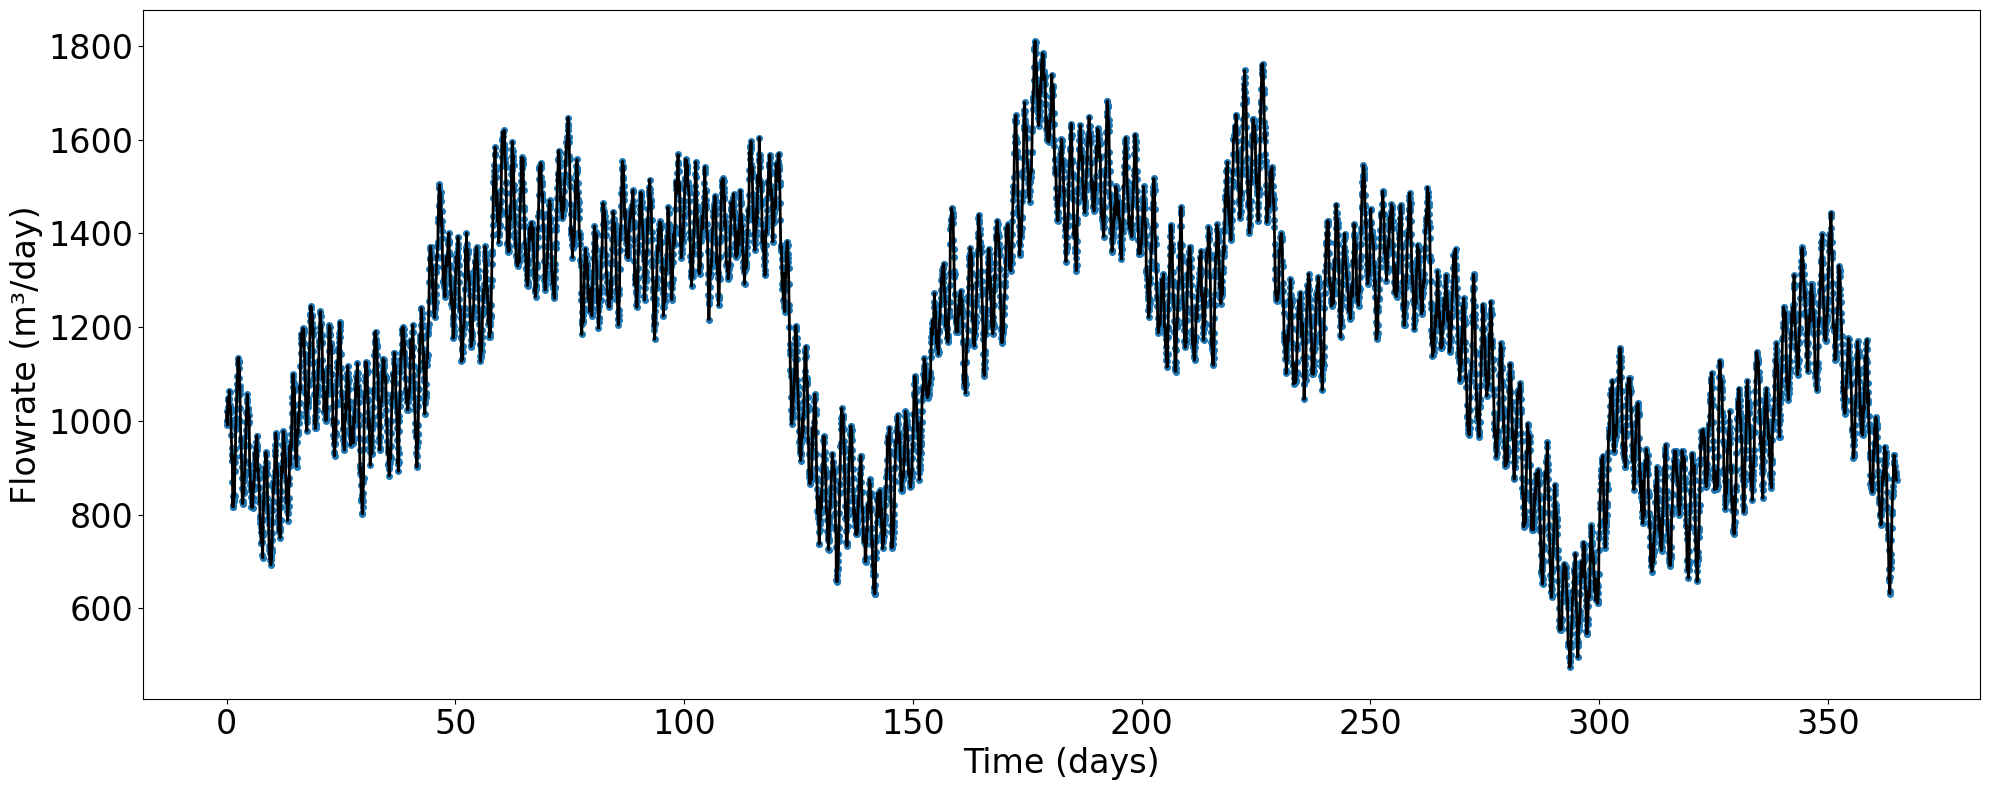

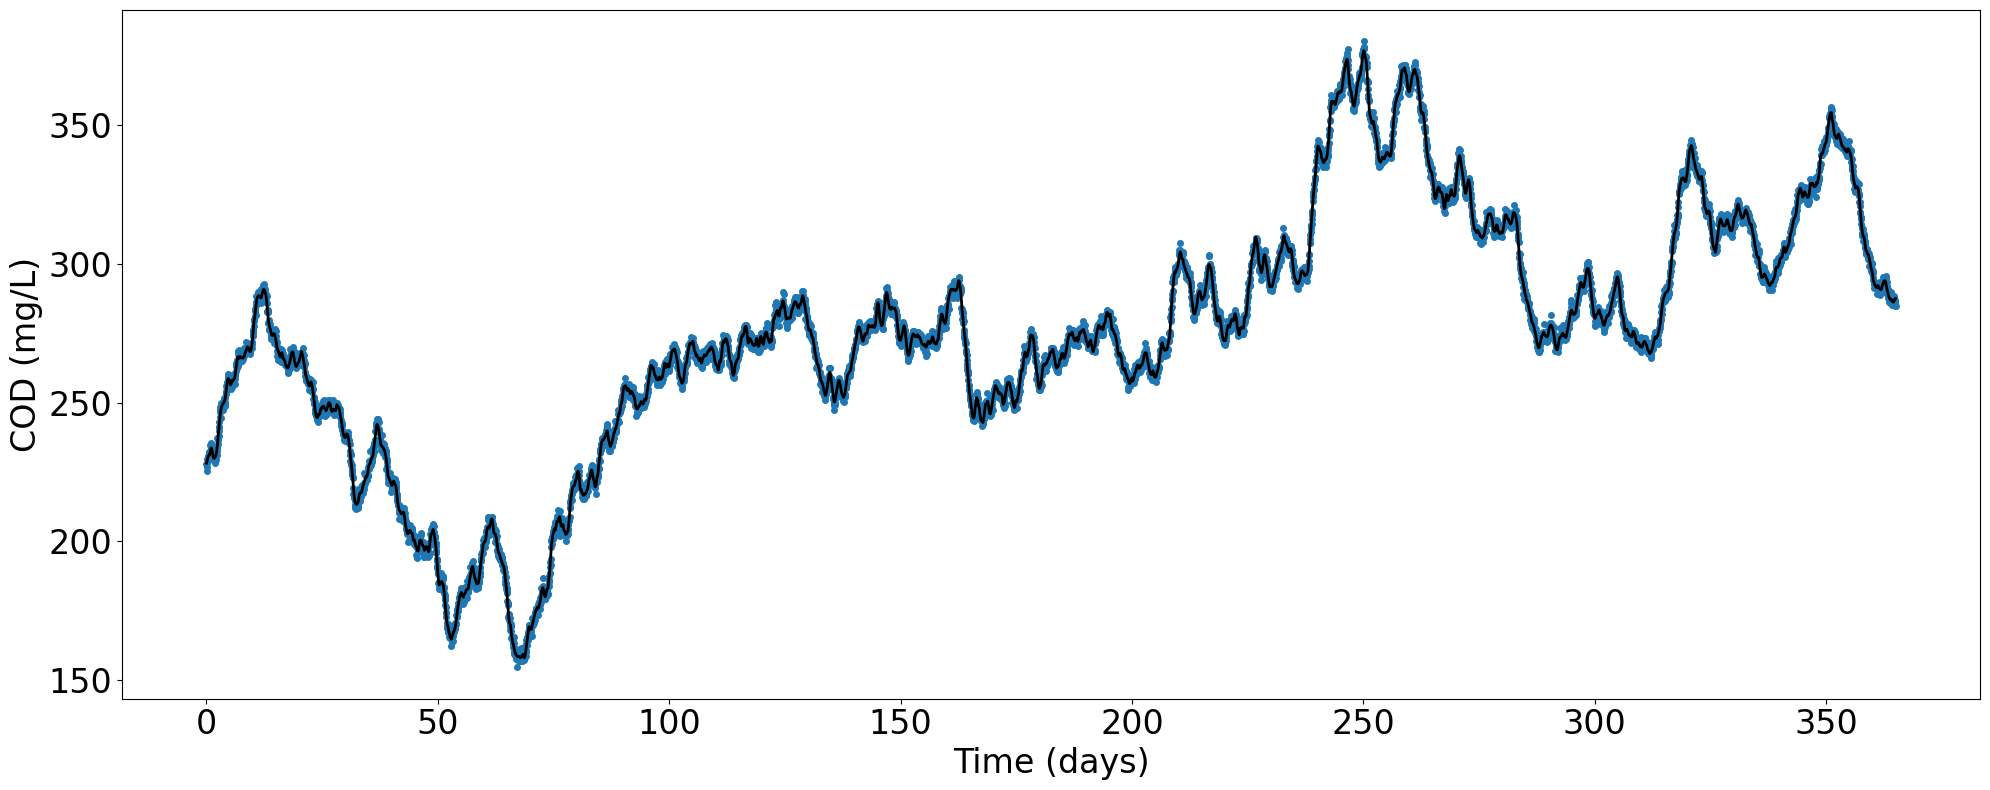

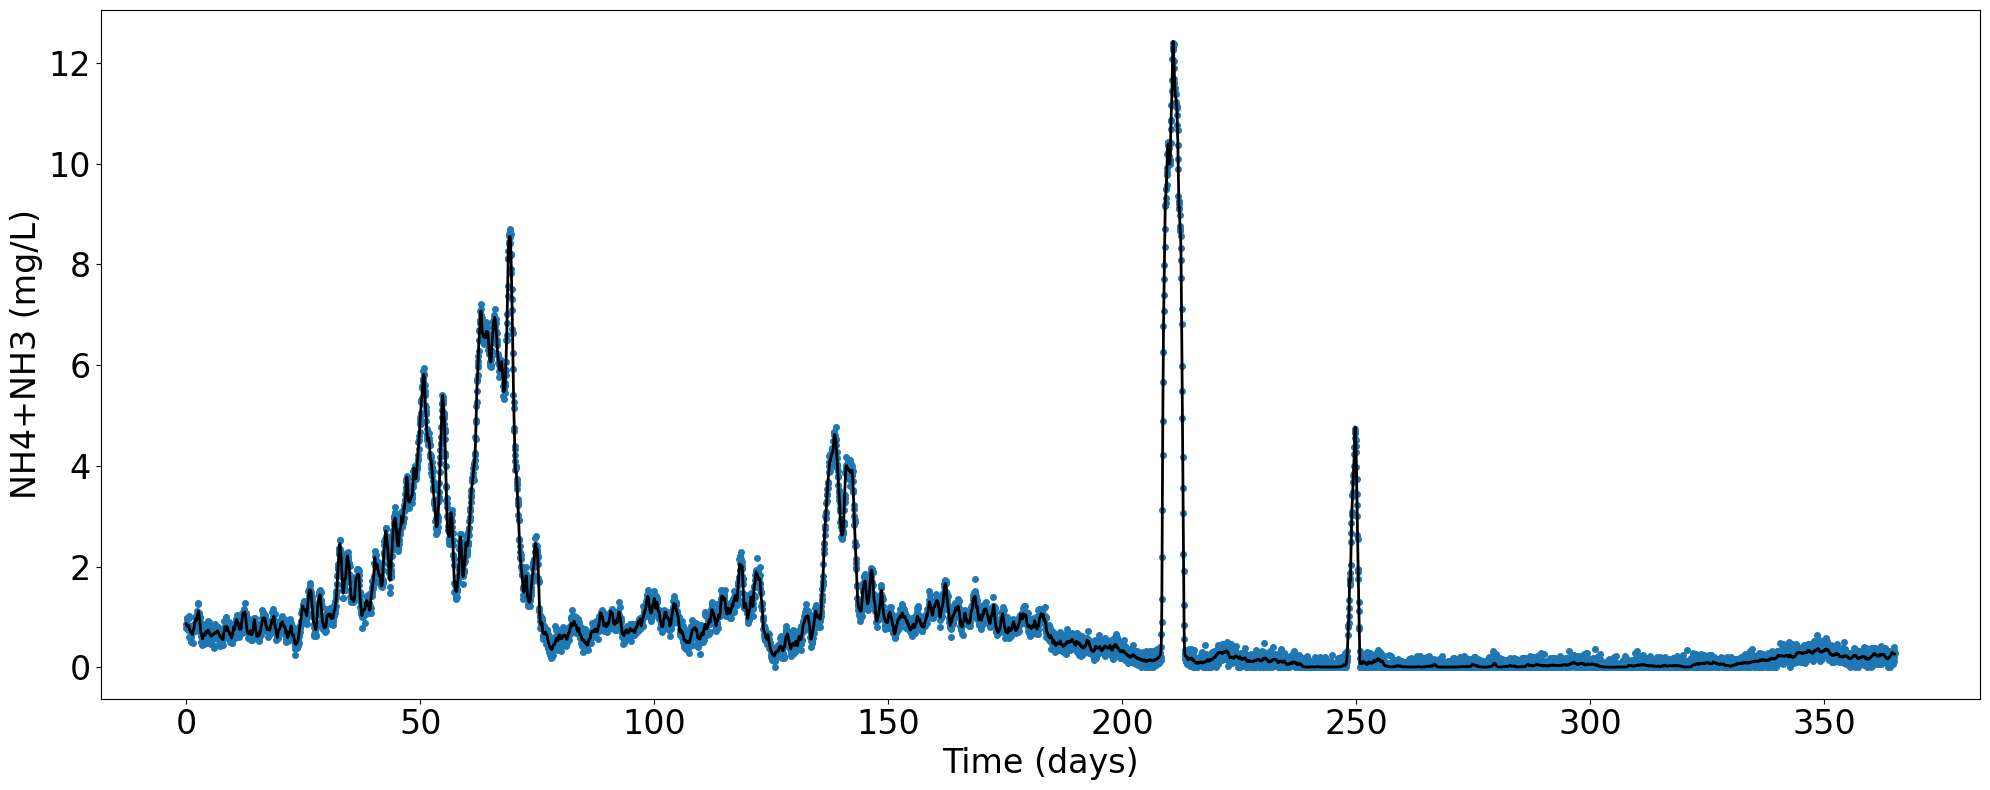

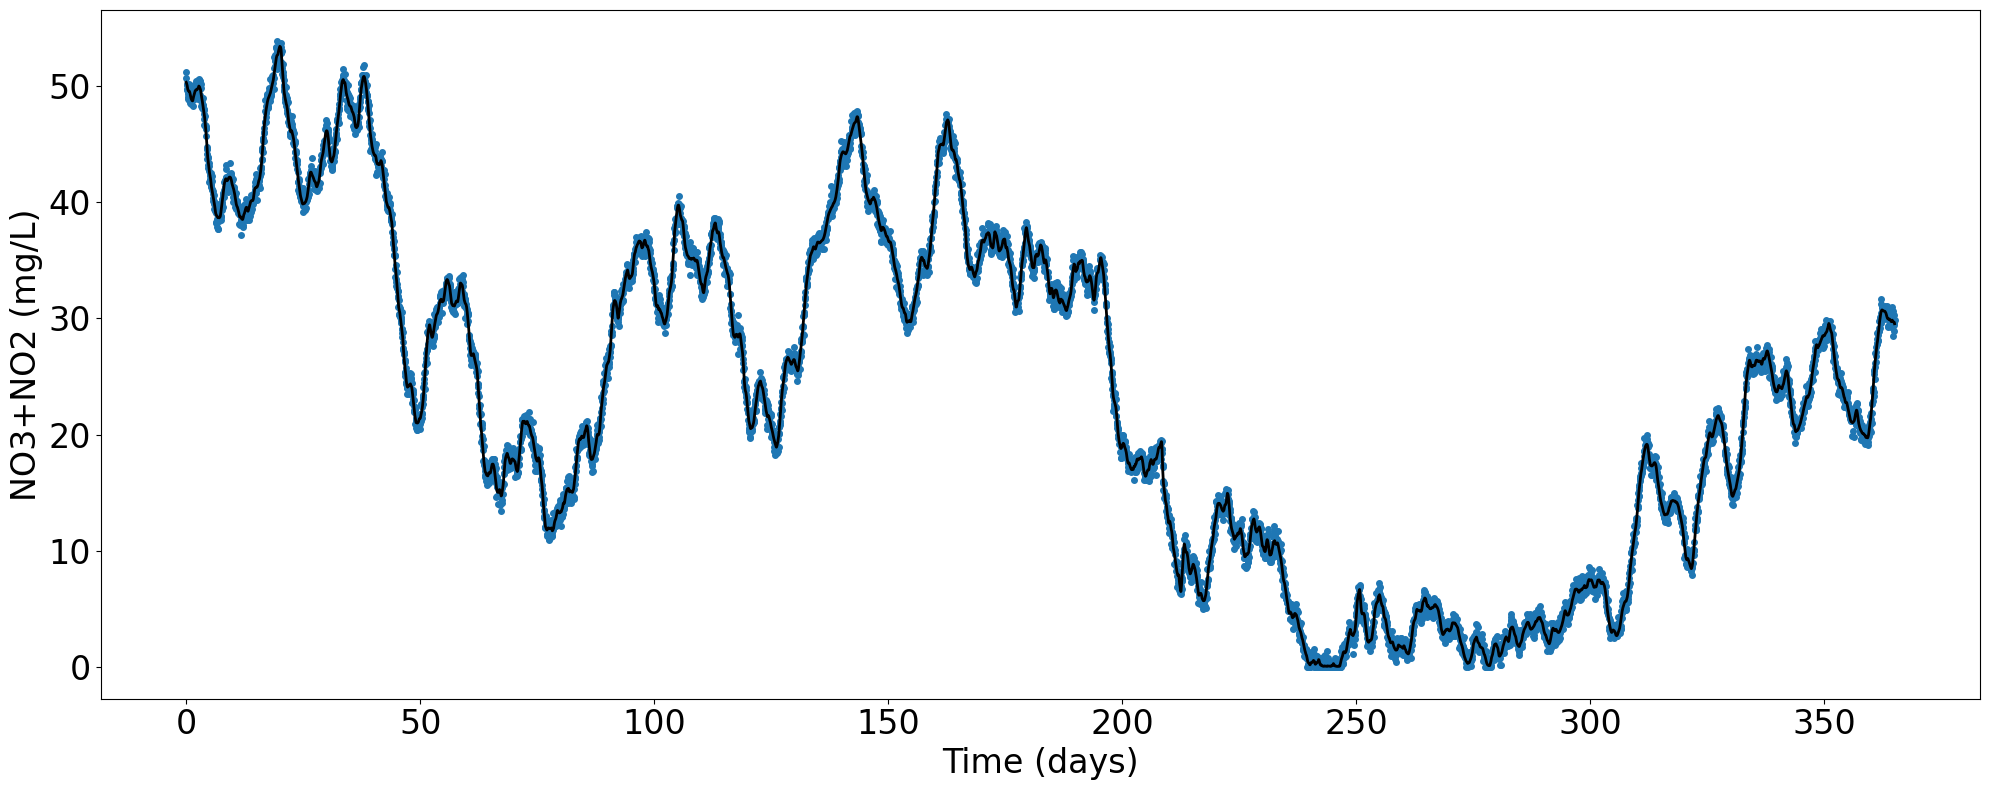

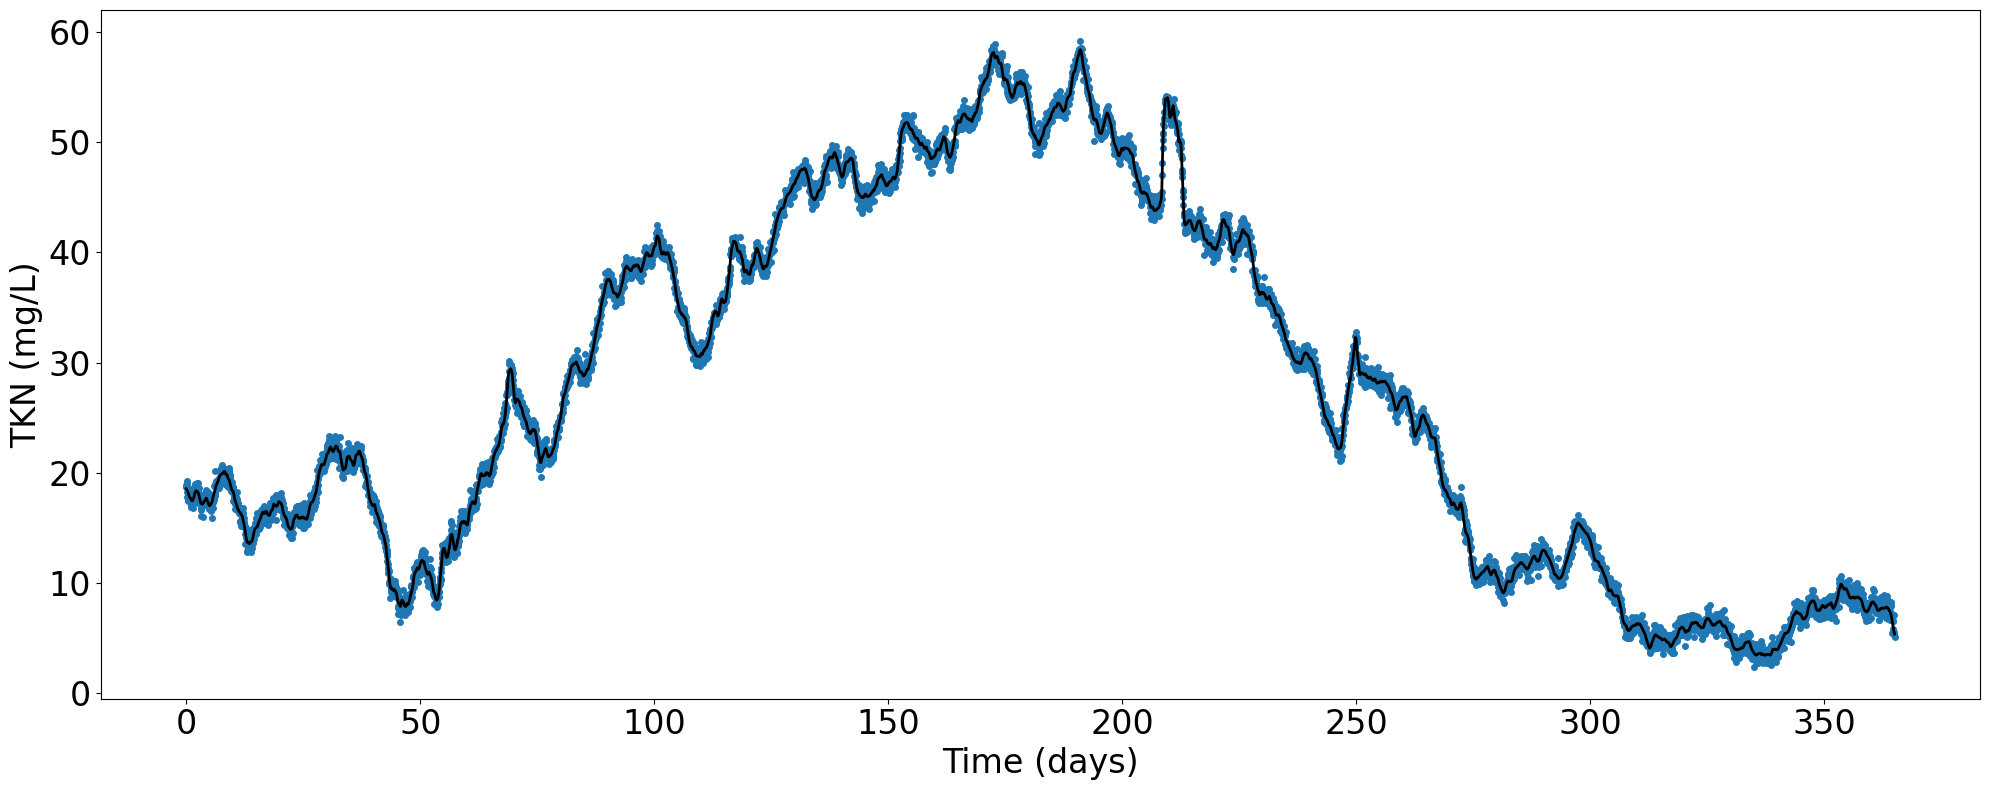

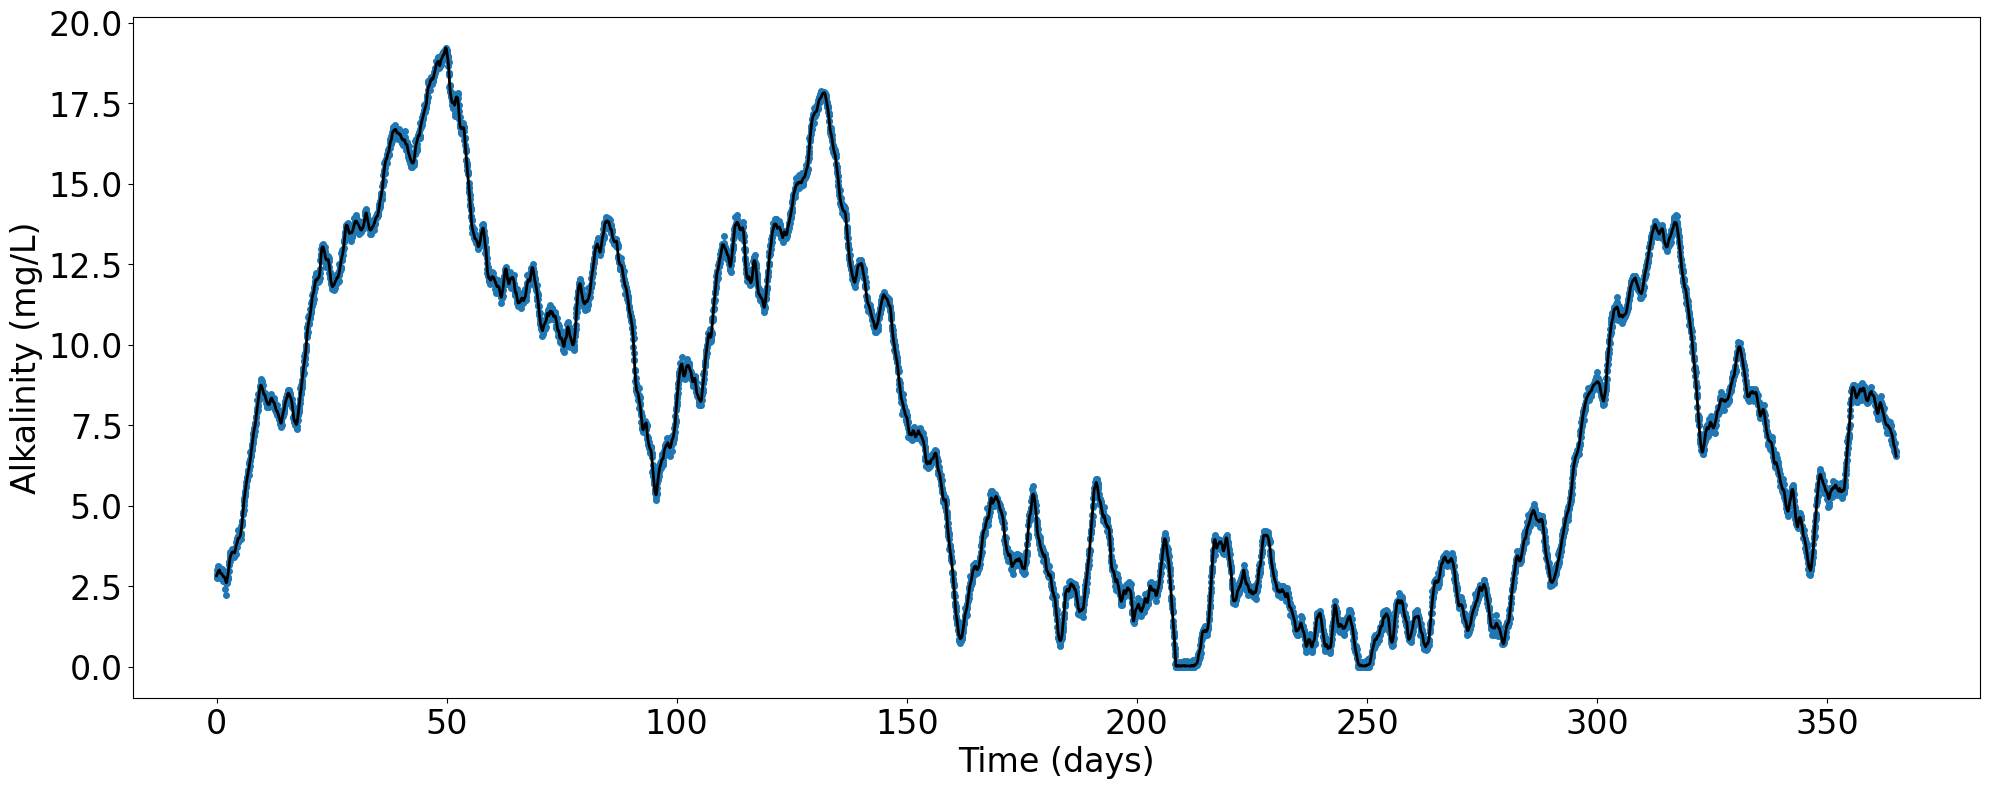

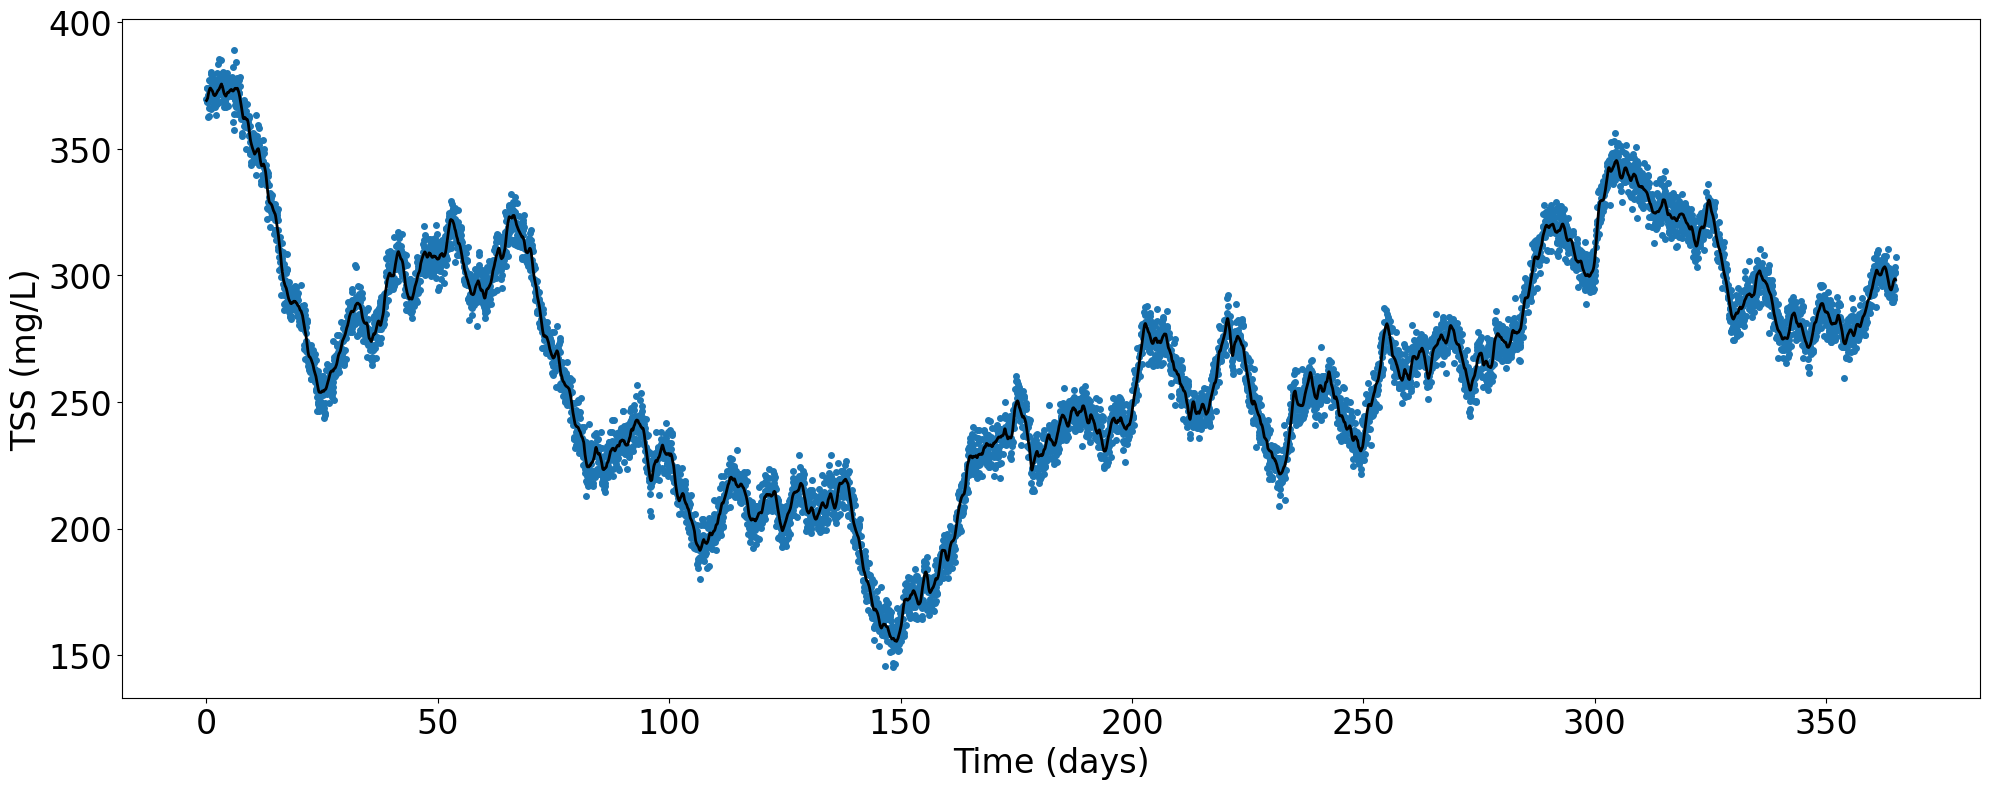

In [12]:
# -----------------------------
# GROUP: Effluents (States & Compounds) + true overlay
# -----------------------------
effluent_states_datasets = {k: v['effluent_states'] for k, v in data.items() if v['effluent_states'] is not None}
effluent_compounds_datasets = {k: v['effluent_compounds'] for k, v in data.items() if v['effluent_compounds'] is not None}

# print("--------------------------------------------------")
# print("Plotting ALL Effluent States (with True overlay if available)...")
# print("--------------------------------------------------")
# plot_all_group(effluent_states_datasets, 'effluent_states', effluent_true_df=effluent_true_states)

print("--------------------------------------------------")
print("Plotting ALL Effluent Compounds (with True overlay if available)...")
print("--------------------------------------------------")
plot_all_group(effluent_compounds_datasets, 'effluent_compounds', effluent_true_df=effluent_true_compounds)

# print("--------------------------------------------------")
# print("Plotting ALL Effluent Loadings (kg/day)...")
# print("--------------------------------------------------")
# plot_all_loadings(effluent_compounds_datasets, label_prefix="Effluent")


In [ ]:
# -----------------------------
# DIRECT COMPARISON (user-set)
# -----------------------------
compare_dataset_A = "HighRes"          # 'HighRes', 'Routine', 'Active', 'LongActive', 'LongRoutine', 'SuperRes'
compare_dataset_B = "Active"
compare_group     = "effluent_compounds"  # 'influent_states' | 'effluent_states' | 'influent_compounds' | 'effluent_compounds'
compare_variable  = "NO3+NO2"                 
    # states: 'Flowrate','S_O2','S_I','S_S','S_NH4','S_N2','S_NOX','S_ALK','X_I','X_S','X_H','X_STO','X_A','X_SS'
    # compounds: 'COD','NH4+NH3','NO3+NO2','TKN','Alkalinity','TSS','Flowrate'
max_plot_days = 365      # e.g. 180, 365, or None for automatic (full duration)

A_df = data[compare_dataset_A][compare_group]
B_df = data[compare_dataset_B][compare_group]
if A_df is None or B_df is None:
    raise ValueError(f"Selected datasets/group not available for comparison: {compare_dataset_A}, {compare_dataset_B}, {compare_group}")

# --- pick the window we're actually showing on X ---
def _in_window(df, tmax):
    if tmax is None:
        return df
    return df[df['Time'] <= tmax]

A_win = _in_window(A_df, max_plot_days)
B_win = _in_window(B_df, max_plot_days)

plt.figure(figsize=(20, 8))
font_size = 18
plt.rcParams['font.size'] = font_size

plt.plot(A_win['Time'], A_win[compare_variable], linestyle='None', marker='o', markersize=6, label=f"{compare_dataset_A}")
plt.plot(B_win['Time'], B_win[compare_variable], linestyle='None', marker='o', markersize=6, label=f"{compare_dataset_B}")

# True overlay over the union of A & B (clipped to true_df range and x-window)
y_series_for_limits = [A_win[compare_variable], B_win[compare_variable]]

if compare_group.startswith('effluent') and (effluent_true_states is not None or effluent_true_compounds is not None):
    true_df = effluent_true_states if 'states' in compare_group else effluent_true_compounds
    if compare_variable in true_df.columns:
        tmin_union = min(A_win['Time'].min(), B_win['Time'].min())
        tmax_union = max(A_win['Time'].max(), B_win['Time'].max())
        # Clip to true_df availability
        lo = max(tmin_union, true_df['Time'].min())
        hi = min(tmax_union, true_df['Time'].max())
        mask_true = (true_df['Time'] >= lo) & (true_df['Time'] <= hi)
        true_win = true_df.loc[mask_true]

        if not true_win.empty:
            plt.plot(true_win['Time'], true_win[compare_variable],
                     '-', linewidth=2, color='black', label='True (Super, no noise)', zorder=3)
            y_series_for_limits.append(true_win[compare_variable])

# X-limit
if max_plot_days is not None:
    plt.xlim(0, max_plot_days)

# --- Y-limits from the shown window only (A, B, and True if present) ---
# Concatenate, drop NaNs
y_concat = pd.concat(y_series_for_limits, axis=0).dropna()
if not y_concat.empty:
    ymin = float(y_concat.min())
    ymax = float(y_concat.max())
    if np.isfinite(ymin) and np.isfinite(ymax):
        if np.isclose(ymax, ymin):  # flat line: add absolute padding
            pad = max(1.0, 0.05 * max(abs(ymax), 1.0))
            plt.ylim(ymin - pad, ymax + pad)
        else:
            yrange = ymax - ymin
            pad = 0.08 * yrange  # 8% padding
            plt.ylim(ymin - pad, ymax + pad)

group_label = compare_group.replace('_', ' ').title()
var_label = compare_variable.replace('+', ' plus ')  # handle NH4+NH3 etc. nicely
title_text = f"{var_label} data – {compare_dataset_A} vs {compare_dataset_B} ({group_label})"
ylabel = f"{compare_variable} (mg/L)" if compare_variable != 'Flowrate' else "Flowrate (m³/day)"


plt.title(title_text, fontsize=font_size + 2)
plt.xlabel('Time (days)')
plt.ylabel(ylabel)
plt.legend()
plt.tight_layout()
plt.show()
